In [174]:
# import library.
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import glob
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import linear_model


def prepare_data(filename):
    # load data.
    data = []

    csvdata = open(filename,'r', encoding='utf-8')
    rdr = csv.reader(csvdata)
    for row in rdr:
        data.append(row)
    csvdata.close()

    # 설비 수와 작업 수 설정
    m = len(data[0]) # 설비 수
    n = len(data)     # 작업 수

    # Eij: 설비에 대한 작업 실행 시간
    Eij = []
    for i in range(len(data)):
        Eij.append(list(map(int,data[i])))

    # Cij: 설비에 대한 작업의 완료 시간 (작업 실행 시간과 동일)
    Cij = []
    for i in range(len(data)):
        Cij.append(list(map(int,data[i])))

    # rj: 설비 준비 시간 (준비 시간은 없음.)
    rj = []
    for i in range(m):
        rj.append(0)

    return m, n, Eij, Cij, rj

# Min-Min

In [2]:
def min_min(filename):
    MM = []

    m, n, Eij, Cij, rj = prepare_data(filename)

    # Min-Min 알고리즘
    for x in range(n):
        # mintime(최소완료시간) 집합 구하기
        mintime = []
        for i in range(len(Cij)):
            mintime.append(min(Cij[i]))

        # 구한 집합에서 min 값 구하기
        min_ptime = min(mintime)
        if min_ptime == 10000:
            break

        # 할당된 task와 machine 위치 찾기
        task_index = mintime.index(min_ptime)
        machine_index = Cij[task_index].index(min_ptime)

        # rj(설비 준비 시간) 업데이트
        rj[machine_index] = min_ptime

        # Cij = Eij + rj
        for i in range(len(Cij)):
            if Cij[i][machine_index] == 10000:
                continue
            else:
                Cij[i][machine_index] = Cij[i][machine_index] + Eij[task_index][machine_index]

        # 할당된 task를 10000로 만들기
        for i in range(len(Cij[task_index])):
            Cij[task_index][i] = 10000

        # 실행시간 및 과정
        ptime = Eij[task_index][machine_index]
        process = [task_index, machine_index, ptime]
        MM.append(ptime)
        # print(process)
    
    # 작업이 모두 할당된 설비(Rj) 상태
    # print("\n""작업(Ti)이 모두 할당된 설비(Rj) 상태 : ", rj)

    # makespan 구하기
    makespan = max(rj)
    
    return makespan, MM

# HASA

In [3]:
def hasa(filename):
    HASA = []
    
    m, n, Eij, Cij, rj = prepare_data(filename)

    # half average time(집합의 산술평균의 반) 구하기
    def average(mintime):
        return (sum(mintime) / (len(mintime) - mintime.count(0)))

    # mintime에서 half average time과 가까운 값 찾기
    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx]

    def remove_values_from_list(the_list, val):
        return [value for value in the_list if value != val]

    # HASA 알고리즘
    for x in range(n):
        # mintime(최소완료시간) 집합 구하기
        mintime = []
        for i in range(len(Cij)):
            mintime.append(min(Cij[i]))

        avg_time = average(mintime)
        if sum(mintime) == 0:
            break

        h_avg_time = (avg_time/2)

        sel_min = remove_values_from_list(mintime, 0)

        avg_ptime = find_nearest(sel_min, avg_time)

        h_avg_ptime = find_nearest(sel_min, h_avg_time)
    
        # h_avg_ptime = find_nearest(sel_min, poly_list[x])
        if h_avg_ptime == 0:
            h_avg_ptime = avg_ptime
    
        # 할당된 task와 machine 위치 찾기
        task_index = mintime.index(h_avg_ptime)
        machine_index = Cij[task_index].index(h_avg_ptime)
        # print(task_index, machine_index)

        # rj(설비 준비 시간) 업데이트
        rj[machine_index] = h_avg_ptime
    
        # Cij = Eij + rj
        for i in range(len(Cij)):
            if Cij[i][machine_index] == 0:
                continue
            else:
                Cij[i][machine_index] = Cij[i][machine_index] + Eij[task_index][machine_index]

        # U = U - {Ts}
        for i in range(len(Cij[task_index])):
            Cij[task_index][i] = 0

        # print(Cij)


        # 결과 확인
        # 실행시간 및 과정
        ptime = Eij[task_index][machine_index]
        process = [task_index, machine_index, ptime]
        # print(process)
        HASA.append(ptime)

    # 작업이 모두 할당된 설비(Rj) 상태
    # print("\n""작업(Ti)이 모두 할당된 설비(Rj) 상태 : ", rj)

    # makespan 구하기
    makespan = max(rj)
    
    return makespan, HASA

# Find both ptimes (Min-Min & HASA) 

In [4]:
def get_ptimes(filename):
    mm_makespan, mm_ptimes = min_min(filename)
    hasa_makespan, hasa_ptimes = hasa(filename)
    
    ptimes_list = []
    ptimes_list.append(mm_ptimes)
    ptimes_list.append(hasa_ptimes)
    
    return ptimes_list

# Polynomial regression

In [228]:
def polynomial_regression(ptimes, degree): 
    ptimes_enum = []
    
    for i, pt in enumerate(ptimes):
        ptimes_enum.append([i, pt])
    
    x = np.array(ptimes_enum)[:,0].reshape(-1,1)
    y = np.array(ptimes_enum)[:,1].reshape(-1,1)
    
    Input=[('polynomial', PolynomialFeatures(degree=degree)),('model', linear_model.LinearRegression())]
    pipe=Pipeline(Input)
    pipe.fit(x, y)

    pred_y=pipe.predict(x)
    
    # print(pred_y)
    
    return pred_y

In [110]:
def polynomial_job_shop_main(filename_list):
    filename_list.sort()

    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx]

    def remove_values_from_list(the_list, val):
        return [value for value in the_list if value != val]
    
    
    for filename in filename_list:
        POLY = []
        print(f"dataset: {filename}")
        ptimes_list = get_ptimes(filename)
        intercept, slope = get_average_polynomial_from_ptimes2(ptimes_list)
        
        m, n, Eij, Cij, rj = prepare_data(filename)
        
        hasa_makespan, hasa_list = hasa(filename)
        minmin_makespan, minmin_list = min_min(filename)
        
        newline = '\n'
        
        print(f"Min-Min makespan: {minmin_makespan}{newline}process: {minmin_list}{newline}")
        print(f"HASA makespan: {hasa_makespan}{newline}process: {hasa_list}{newline}")
        
        poly_list = []
        
        for i in range(1, n+1):
            poly_list.append(slope[1]*i**2 + slope[0]*i + intercept)
        
        print(poly_list)

        for x in range(n):
            mintime = []
            for i in range(len(Cij)):
                mintime.append(min(Cij[i]))

            if sum(mintime) == 0:
                break
    
            sel_min = remove_values_from_list(mintime, 0)

            nearest_ptime = find_nearest(sel_min, poly_list[x])

            task_index = mintime.index(nearest_ptime)
            machine_index = Cij[task_index].index(nearest_ptime)

            rj[machine_index] = nearest_ptime
    
            for i in range(len(Cij)):
                if Cij[i][machine_index] == 0:
                    continue
                else:
                    Cij[i][machine_index] = Cij[i][machine_index] + Eij[task_index][machine_index]

            for i in range(len(Cij[task_index])):
                Cij[task_index][i] = 0

            # 결과 확인
            # 실행시간 및 과정
            ptime = Eij[task_index][machine_index]
            process = [task_index, machine_index, ptime]
            # print(process)

            # 작업이 모두 할당된 설비(Rj) 상태
            # print("\n""작업(Ti)이 모두 할당된 설비(Rj) 상태 : ", rj)
            POLY.append(ptime)
    
        # makespan 구하기
        makespan = max(rj)
        print(f"Poly makespan: {makespan}{newline}process: {POLY}")
        print('\n\n')
        
        
        # plotting for visualization.
        hasa_plot = []
        minmin_plot = []
        
        for i, pt in enumerate(hasa_list):
            hasa_plot.append([i, pt])
            
        for i, pt in enumerate(minmin_list):
            minmin_plot.append([i, pt])

        x = np.array(hasa_plot)[:,0].reshape(-1,1)
        y1 = np.array(hasa_plot)[:,1].reshape(-1,1)
        y2 = np.array(minmin_plot)[:,1].reshape(-1,1)

        plt.rcParams["figure.figsize"] = (20,15)
        plt.plot(x, y1, 'o', label="HASA - Processing time", markersize=10)
        plt.plot(x, y2, '^', label="Min-Min - Processing time", markersize=10)
        plt.plot(x, slope[1]*x**2 + slope[0]*x + intercept, label="Polynomial")
        plt.xlabel("Assignment order", fontsize=24)
        plt.ylabel("Processing time", rotation=90, fontsize=24)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.legend(loc="upper left", fontsize=24)
        plt.show()

In [268]:
def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx]

In [269]:
    def remove_values_from_list(the_list, val):
        return [value for value in the_list if value != val]

In [122]:
def get_ptimes_from_optimal(r_filename):
    csvdata = open(r_filename,'r', encoding='utf-8')
    data = []
    rdr = csv.reader(csvdata)
    for row in rdr:
        data.append(row)
    csvdata.close()

    results = []

    for l in data:
        results.append(list(map(int, l)))
    
    # print(results)
    
    df = pd.DataFrame(results, columns=['order', 'ptime', 'machine'])
    df = df.sort_values(by=['order'])

    machine = list(df['machine'].unique())

    max_span = 0

    for m in machine:
        span = df.loc[df['machine'] == m, 'ptime'].sum()
        if span > max_span:
            max_span = span
        
    ptimes = list(df['ptime'])

    return max_span, ptimes

In [273]:
def get_poly_makespan(file, r_file, poly_list):
    POLY = []
    m, n, Eij, Cij, rj = prepare_data(file)
            
    for x in range(n):
        mintime = []
        for i in range(len(Cij)):
            mintime.append(min(Cij[i]))

        if sum(mintime) == 0:
            break
    
        sel_min = remove_values_from_list(mintime, 0)

        nearest_ptime = find_nearest(sel_min, poly_list[x])

        task_index = mintime.index(nearest_ptime)
        machine_index = Cij[task_index].index(nearest_ptime)

        rj[machine_index] = nearest_ptime
    
        for i in range(len(Cij)):
            if Cij[i][machine_index] == 0:
                continue
            else:
                Cij[i][machine_index] = Cij[i][machine_index] + Eij[task_index][machine_index]

        for i in range(len(Cij[task_index])):
            Cij[task_index][i] = 0

        # 결과 확인
        # 실행시간 및 과정
        ptime = Eij[task_index][machine_index]
        process = [task_index, machine_index, ptime]
        # print(process)

        # 작업이 모두 할당된 설비(Rj) 상태
        # print("\n""작업(Ti)이 모두 할당된 설비(Rj) 상태 : ", rj)
        POLY.append(ptime)
    
    # makespan 구하기
    makespan = max(rj)
    # print(f'makespan = {makespan}, degree={degree}')
    return makespan, POLY

# job shop with polynomial regression (generalize Opt)

In [274]:
def polynomial_job_shop_main_optimal(filenames_list, results_list, tests_file = [], tests_results_file = []):
    filename_list.sort()
    result_list.sort()
    
    optimal_lists = []
    
    degrees = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80]
    
    for filenames, r_filenames in zip(filenames_list, results_list):
        poly_opt_makespan = 10000
        optimal_degree = 0
        for degree in degrees:
            y_pred_list = []
            for file, r_file in zip(filenames, r_filenames):
                # print(f"dataset: {file}")
        
                optimal_makespan, optimal_list = get_ptimes_from_optimal(r_file)
                y_pred = polynomial_regression(optimal_list, degree)
            
                y_pred_list.append(y_pred)
            
                # print(len(y_pred))
            
            pred_average = [0] * len(y_pred)
            
            for y in y_pred_list:
                for i in range(len(y)):
                    pred_average[i] += y[i]
        
            pred_average = list(map(lambda x:x/len(y_pred_list), pred_average))
            poly_list = pred_average
            
            sum_makespan = 0
            
            for file, r_file in zip(filenames, r_filenames):
                makespan, POLY = get_poly_makespan(file, r_file, poly_list)
                sum_makespan += makespan
            
            # print(sum_makespan)
                
            
            if sum_makespan < poly_opt_makespan:
                poly_opt_makespan = sum_makespan
                optimal_degree = degree
                
        
        y_pred_list = []
        print(optimal_degree)
        for file, r_file in zip(filenames, r_filenames):
            POLY = []
            print(f"dataset: {file}")
        
            optimal_makespan, optimal_list = get_ptimes_from_optimal(r_file)
            y_pred = polynomial_regression(optimal_list, optimal_degree)
            
            y_pred_list.append(y_pred)
            
            # print(len(y_pred))
            
        pred_average = [0] * len(y_pred)
            
        for y in y_pred_list:
            for i in range(len(y)):
                pred_average[i] += y[i]
        
        pred_average = list(map(lambda x:x/len(y_pred_list), pred_average))
        poly_list = pred_average
        # print(pred_average)
        
            
        
        
        for file, r_file in zip(filenames, r_filenames):
            makespan, POLY = get_poly_makespan(file, r_file, poly_list)

            hasa_makespan, hasa_list = hasa(file)
            minmin_makespan, minmin_list = min_min(file)
            optimal_makespan, optimal_list = get_ptimes_from_optimal(r_file)
        
            newline = '\n'
        
            print(f"Min-Min makespan: {minmin_makespan}{newline}process: {minmin_list}{newline}")
            print(f"HASA makespan: {hasa_makespan}{newline}process: {hasa_list}{newline}")
            print(f"Optimal makespan: {optimal_makespan}{newline}process: {optimal_list}{newline}")
            print(f"Poly makespan: {makespan}{newline}process: {POLY}")
            print('\n\n')

            # plotting for visualization.
            hasa_plot = []
            minmin_plot = []
            optimal_plot = []
            poly_plot = []
        
            for i, pt in enumerate(hasa_list):
                hasa_plot.append([i, pt])
            
            for i, pt in enumerate(minmin_list):
                minmin_plot.append([i, pt])
            
            for i, pt in enumerate(optimal_list):
                optimal_plot.append([i, pt])
                
            for i, pt in enumerate(poly_list):
                poly_plot.append([i, pt])
                
            

            x = np.array(hasa_plot)[:,0].reshape(-1,1)
            y1 = np.array(hasa_plot)[:,1].reshape(-1,1)
            y2 = np.array(minmin_plot)[:,1].reshape(-1,1)
            y3 = np.array(optimal_plot)[:,1].reshape(-1,1)
            y4 = np.array(poly_plot)[:,1].reshape(-1,1)
        
            # print(y3)

            plt.rcParams["figure.figsize"] = (20,15)
            # plt.plot(x, y1, 'o', label="HASA - Processing time", markersize=10)
            # plt.plot(x, y2, '^', label="Min-Min - Processing time", markersize=10)
            plt.plot(x, y3, '*', label="Optimal - Processing time", markersize=10)
            plt.plot(x, y4, 'o', label="Polynomial", markersize = 10)
            plt.xlabel("Assignment order", fontsize=24)
            plt.ylabel("Processing time", rotation=90, fontsize=24)
            plt.xticks(fontsize=18)
            plt.yticks(fontsize=18)
            plt.legend(loc="upper left", fontsize=24)
            plt.show()

# job shop with polynomial regression (generalize Min-Min + HASA)

In [304]:
def polynomial_job_shop_main_mh(filenames_list, results_list, tests_file = [], tests_results_file = []):
    filename_list.sort()
    result_list.sort()
    
    optimal_lists = []
    
    degrees = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80]
    
    for filenames, r_filenames in zip(filenames_list, results_list):
        poly_opt_makespan = 10000
        optimal_degree = 0
        for degree in degrees:
            y_pred_list = []
            for file, r_file in zip(filenames, r_filenames):
                ptimes_list = get_ptimes(file)
                
                y_pred_mm = polynomial_regression(ptimes_list[0], degree)
                y_pred_hasa = polynomial_regression(ptimes_list[1], degree)
            
                y_pred_list.append(y_pred_mm)
                y_pred_list.append(y_pred_hasa)
            
            pred_average = [0] * len(y_pred_mm)
            
            for y in y_pred_list:
                for i in range(len(y)):
                    pred_average[i] += y[i]
        
            pred_average = list(map(lambda x:x/len(y_pred_list), pred_average))
            poly_list = pred_average
            
            sum_makespan = 0
            
            for file, r_file in zip(filenames, r_filenames):
                makespan, POLY = get_poly_makespan(file, r_file, poly_list)
                sum_makespan += makespan
            
            # print(sum_makespan)
                
            
            if sum_makespan < poly_opt_makespan:
                poly_opt_makespan = sum_makespan
                optimal_degree = degree
                
        
        y_pred_list = []
        print(optimal_degree)
        for file, r_file in zip(filenames, r_filenames):
            POLY = []
            print(f"dataset: {file}")
        
            ptimes_list = get_ptimes(file)
                
            y_pred_mm = polynomial_regression(ptimes_list[0], degree)
            y_pred_hasa = polynomial_regression(ptimes_list[1], degree)
            
            y_pred_list.append(y_pred_mm)
            y_pred_list.append(y_pred_hasa)
            
            # print(len(y_pred))
            
        pred_average = [0] * len(y_pred_mm)
            
        for y in y_pred_list:
            for i in range(len(y)):
                pred_average[i] += y[i]
        
        pred_average = list(map(lambda x:x/len(y_pred_list), pred_average))
        poly_list = pred_average
        
            
        
        
        for file, r_file in zip(filenames, r_filenames):
            makespan, POLY = get_poly_makespan(file, r_file, poly_list)

            hasa_makespan, hasa_list = hasa(file)
            minmin_makespan, minmin_list = min_min(file)
            optimal_makespan, optimal_list = get_ptimes_from_optimal(r_file)
        
            newline = '\n'
        
            print(f"Min-Min makespan: {minmin_makespan}{newline}process: {minmin_list}{newline}")
            print(f"HASA makespan: {hasa_makespan}{newline}process: {hasa_list}{newline}")
            print(f"Optimal makespan: {optimal_makespan}{newline}process: {optimal_list}{newline}")
            print(f"Poly makespan: {makespan}{newline}process: {POLY}")
            print('\n\n')

            # plotting for visualization.
            hasa_plot = []
            minmin_plot = []
            optimal_plot = []
            poly_plot = []
        
            for i, pt in enumerate(hasa_list):
                hasa_plot.append([i, pt])
            
            for i, pt in enumerate(minmin_list):
                minmin_plot.append([i, pt])
            
            for i, pt in enumerate(optimal_list):
                optimal_plot.append([i, pt])
                
            for i, pt in enumerate(poly_list):
                poly_plot.append([i, pt])
                
            

            x = np.array(hasa_plot)[:,0].reshape(-1,1)
            y1 = np.array(hasa_plot)[:,1].reshape(-1,1)
            y2 = np.array(minmin_plot)[:,1].reshape(-1,1)
            y3 = np.array(optimal_plot)[:,1].reshape(-1,1)
            y4 = np.array(poly_plot)[:,1].reshape(-1,1)
        
            # print(y3)

            plt.rcParams["figure.figsize"] = (20,15)
            # plt.plot(x, y1, 'o', label="HASA - Processing time", markersize=10)
            # plt.plot(x, y2, '^', label="Min-Min - Processing time", markersize=10)
            plt.plot(x, y3, '*', label="Optimal - Processing time", markersize=10)
            plt.plot(x, y4, 'o', label="Polynomial", markersize = 10)
            plt.xlabel("Assignment order", fontsize=24)
            plt.ylabel("Processing time", rotation=90, fontsize=24)
            plt.xticks(fontsize=18)
            plt.yticks(fontsize=18)
            plt.legend(loc="upper left", fontsize=24)
            plt.show()

# main
After compiling all above cells, run this cell to see the result for all datasets.

9
dataset: ./all_data/2x50/2x50-1.csv
dataset: ./all_data/2x50/2x50-2.csv
dataset: ./all_data/2x50/2x50-3.csv
dataset: ./all_data/2x50/2x50-4.csv
dataset: ./all_data/2x50/2x50-5.csv
Min-Min makespan: 909
process: [1, 2, 3, 4, 8, 4, 5, 10, 9, 11, 10, 14, 15, 18, 19, 21, 20, 22, 20, 22, 22, 24, 23, 28, 28, 30, 29, 33, 34, 37, 37, 40, 43, 45, 58, 46, 65, 52, 68, 53, 56, 69, 67, 75, 73, 77, 78, 81, 80, 91]

HASA makespan: 909
process: [18, 3, 22, 8, 9, 2, 1, 4, 10, 4, 5, 11, 10, 14, 15, 21, 19, 22, 20, 22, 20, 24, 23, 28, 28, 30, 29, 33, 34, 37, 37, 40, 43, 45, 58, 46, 65, 52, 68, 53, 56, 69, 67, 75, 73, 77, 78, 81, 80, 91]

Optimal makespan: 884
process: [56, 33, 20, 21, 24, 23, 2, 33, 10, 5, 19, 65, 37, 45, 22, 52, 1, 81, 79, 75, 29, 8, 28, 73, 9, 80, 22, 11, 15, 3, 53, 10, 18, 13, 4, 4, 34, 22, 20, 40, 77, 43, 58, 65, 28, 77, 37, 81, 56, 46]

Poly makespan: 910
process: [52, 37, 1, 2, 4, 4, 5, 3, 9, 8, 10, 10, 11, 13, 15, 18, 19, 21, 20, 22, 20, 22, 22, 24, 23, 28, 28, 30, 29, 33, 34, 3

/tmp/ipykernel_395369/2015407290.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


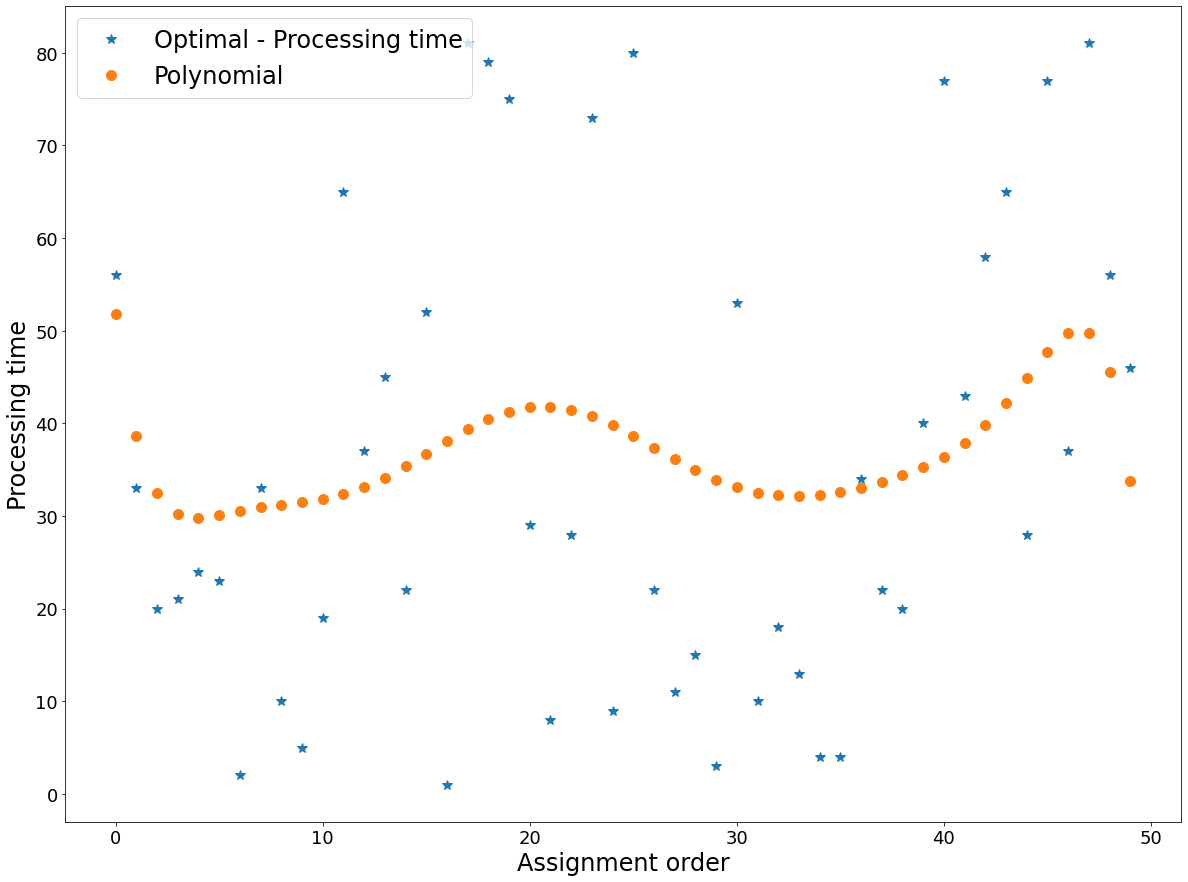

Min-Min makespan: 967
process: [1, 3, 2, 3, 3, 6, 9, 7, 7, 18, 8, 14, 23, 20, 24, 21, 25, 31, 25, 34, 25, 28, 38, 28, 40, 29, 41, 33, 38, 52, 38, 54, 41, 55, 46, 46, 57, 48, 57, 51, 74, 54, 77, 73, 80, 77, 80, 82, 84, 100]

HASA makespan: 967
process: [18, 3, 21, 9, 14, 1, 2, 3, 3, 6, 7, 23, 7, 8, 24, 20, 25, 31, 25, 34, 25, 28, 38, 28, 40, 29, 41, 33, 38, 52, 38, 54, 41, 55, 46, 46, 57, 48, 57, 51, 74, 54, 77, 73, 80, 77, 80, 82, 84, 100]

Optimal makespan: 951
process: [20, 28, 38, 7, 54, 41, 23, 88, 31, 74, 28, 54, 24, 55, 3, 46, 48, 25, 9, 1, 51, 73, 38, 14, 38, 57, 46, 8, 57, 52, 29, 40, 34, 84, 25, 3, 6, 77, 41, 82, 21, 25, 3, 18, 80, 82, 2, 77, 33, 7]

Poly makespan: 967
process: [52, 38, 3, 3, 9, 1, 2, 3, 6, 7, 18, 7, 8, 23, 14, 24, 20, 21, 25, 25, 31, 25, 34, 28, 38, 28, 29, 40, 33, 41, 38, 54, 41, 55, 46, 46, 57, 48, 57, 51, 74, 54, 77, 73, 80, 77, 80, 82, 84, 100]





/tmp/ipykernel_395369/2015407290.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


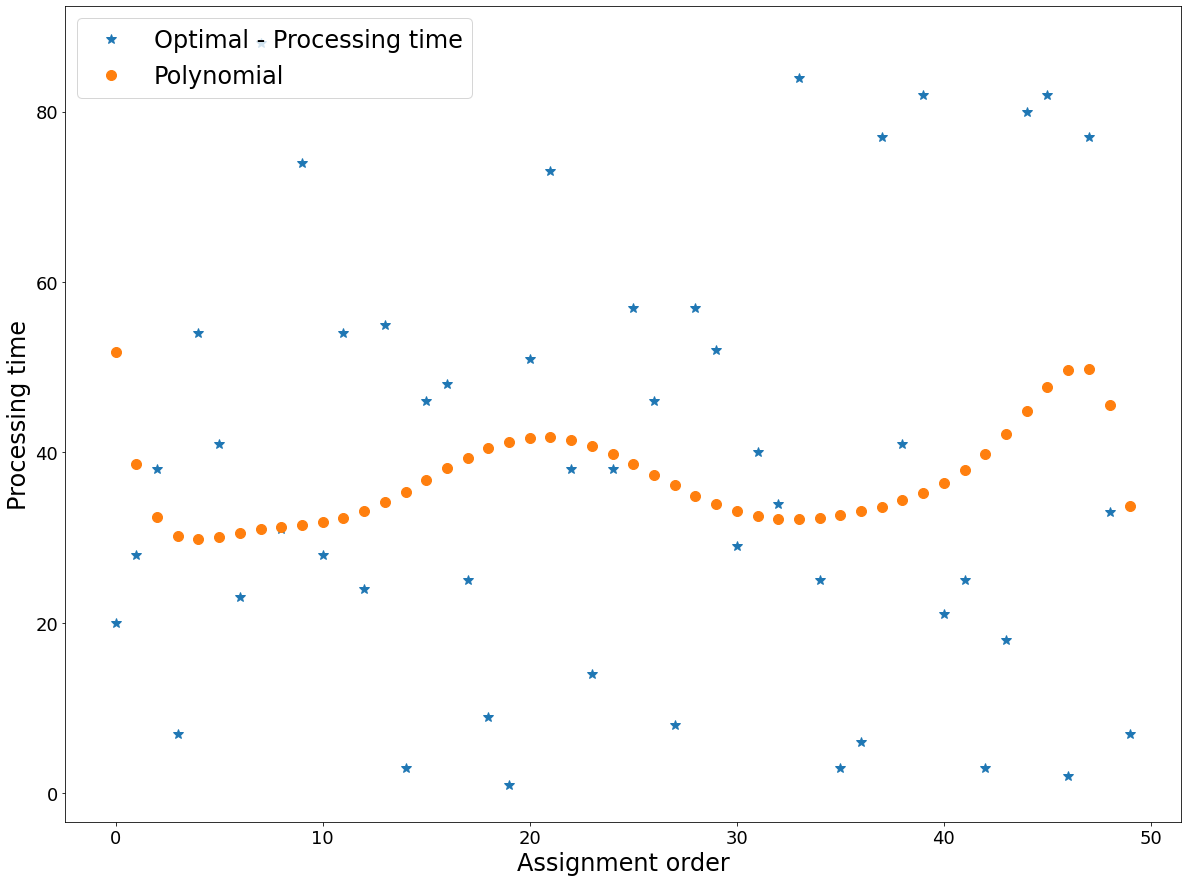

Min-Min makespan: 977
process: [1, 2, 4, 5, 4, 6, 7, 8, 8, 10, 17, 17, 21, 22, 23, 24, 25, 25, 28, 29, 34, 34, 34, 37, 35, 38, 37, 38, 39, 39, 41, 46, 47, 48, 47, 52, 50, 55, 55, 60, 57, 60, 65, 66, 65, 74, 80, 85, 83, 96]

HASA makespan: 977
process: [17, 22, 6, 4, 4, 21, 1, 2, 8, 5, 7, 10, 8, 17, 23, 24, 25, 25, 28, 29, 34, 34, 34, 37, 35, 38, 37, 38, 39, 39, 41, 46, 47, 48, 47, 52, 50, 55, 55, 60, 57, 60, 65, 66, 65, 74, 80, 85, 83, 96]

Optimal makespan: 944
process: [37, 41, 60, 4, 38, 47, 17, 55, 37, 24, 53, 55, 29, 39, 47, 6, 34, 2, 25, 22, 57, 52, 46, 21, 39, 34, 7, 25, 60, 35, 5, 91, 10, 28, 65, 23, 17, 48, 80, 1, 4, 81, 34, 38, 74, 90, 8, 66, 65, 8]

Poly makespan: 977
process: [52, 39, 1, 2, 5, 7, 4, 4, 8, 6, 8, 17, 10, 21, 17, 22, 23, 24, 25, 25, 28, 29, 34, 34, 34, 37, 35, 38, 37, 38, 41, 39, 47, 46, 47, 48, 50, 55, 55, 60, 57, 60, 65, 66, 65, 74, 80, 85, 83, 96]





/tmp/ipykernel_395369/2015407290.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


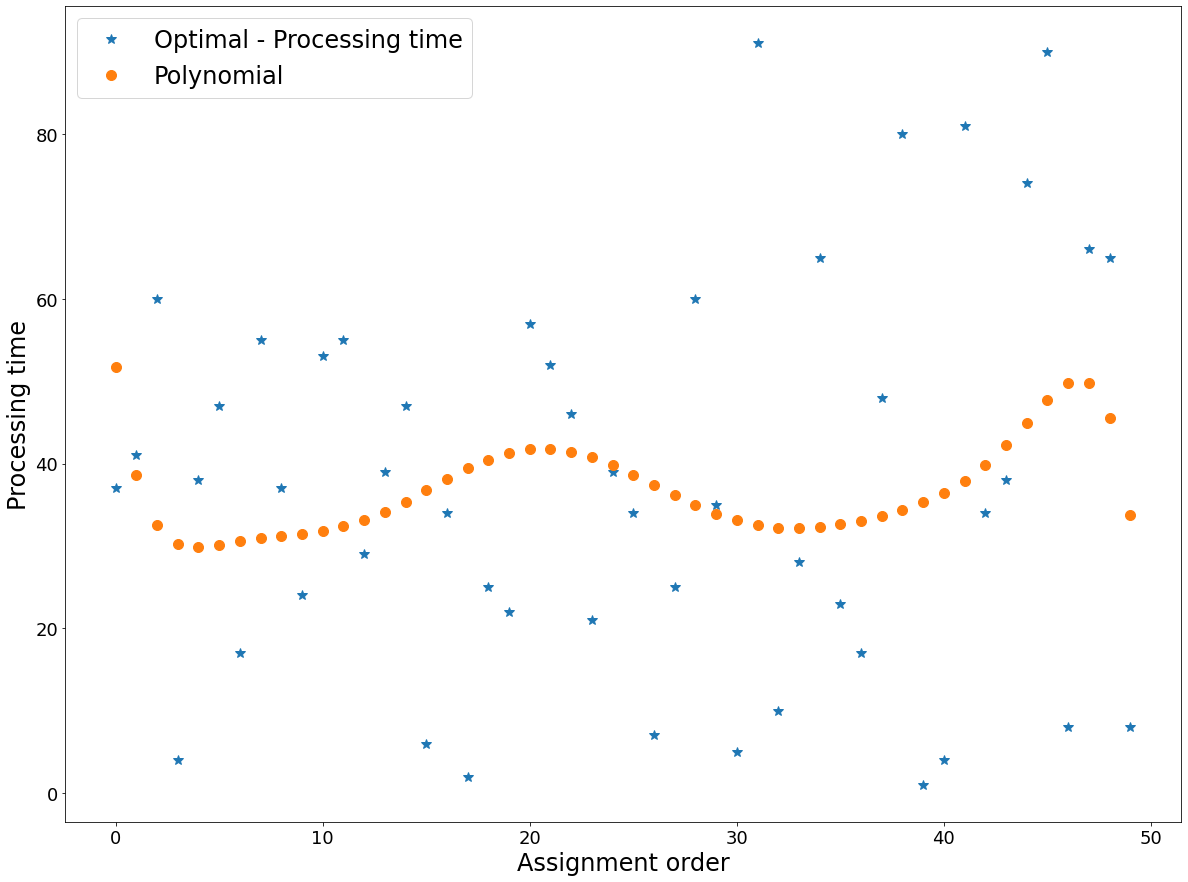

Min-Min makespan: 986
process: [2, 4, 3, 5, 6, 11, 7, 11, 11, 13, 13, 14, 17, 17, 19, 19, 20, 22, 21, 22, 28, 35, 34, 36, 35, 38, 35, 41, 54, 41, 55, 44, 56, 51, 55, 57, 56, 58, 56, 60, 68, 61, 63, 75, 74, 75, 76, 90, 96, 91]

HASA makespan: 1011
process: [19, 5, 25, 7, 4, 11, 3, 2, 6, 11, 11, 13, 17, 14, 20, 17, 21, 19, 22, 28, 22, 34, 35, 35, 36, 35, 38, 54, 41, 41, 55, 44, 56, 51, 57, 55, 58, 56, 60, 56, 61, 68, 63, 75, 74, 75, 76, 90, 96, 91]

Optimal makespan: 982
process: [63, 90, 3, 19, 58, 2, 54, 19, 32, 41, 11, 38, 35, 11, 7, 44, 55, 81, 35, 17, 74, 56, 57, 35, 75, 90, 60, 51, 4, 5, 56, 21, 56, 36, 20, 13, 22, 68, 41, 55, 13, 28, 61, 11, 34, 6, 17, 14, 91, 76]

Poly makespan: 986
process: [51, 35, 4, 5, 6, 2, 3, 7, 11, 11, 11, 13, 13, 17, 14, 19, 17, 20, 19, 21, 22, 22, 28, 35, 34, 35, 36, 38, 54, 41, 55, 41, 44, 56, 55, 57, 56, 58, 56, 60, 68, 61, 63, 75, 74, 75, 76, 90, 96, 91]





/tmp/ipykernel_395369/2015407290.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


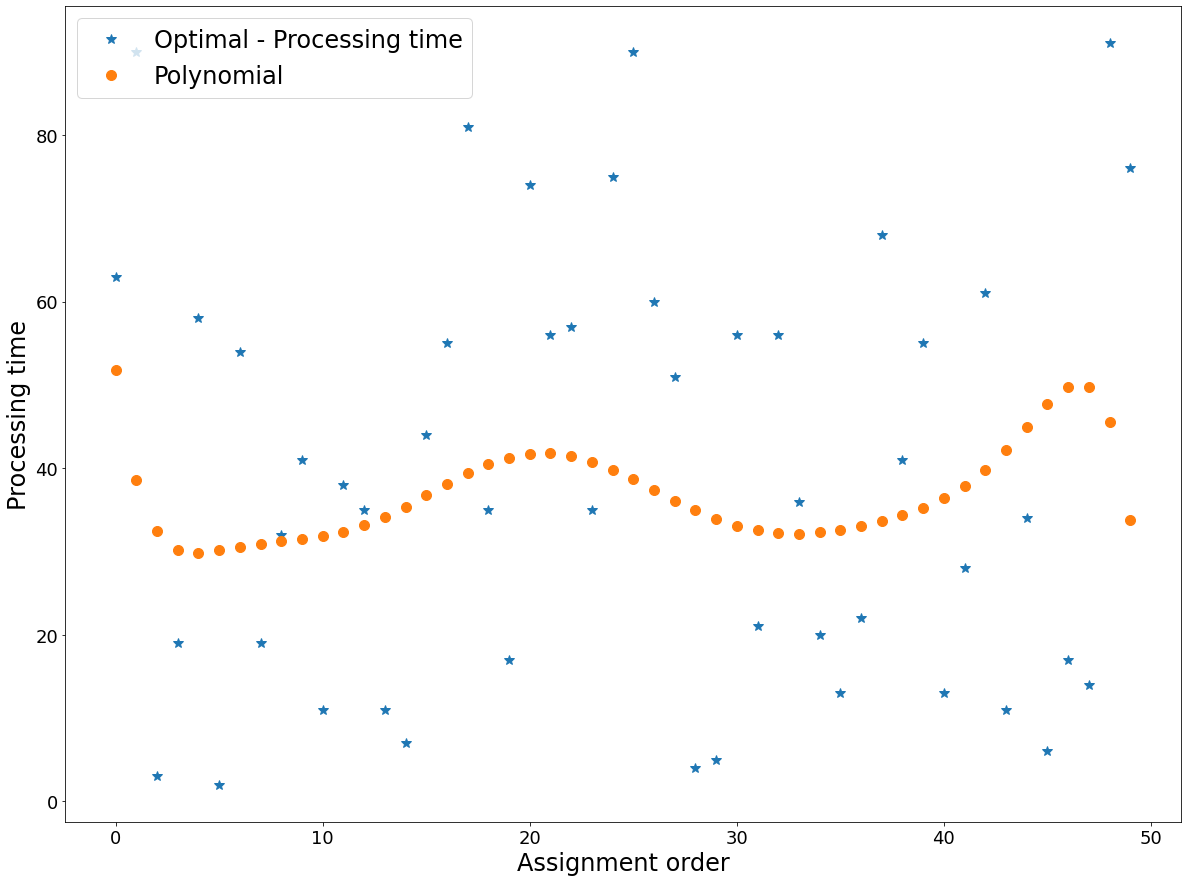

Min-Min makespan: 895
process: [1, 2, 2, 6, 3, 4, 5, 10, 6, 11, 7, 7, 8, 17, 13, 24, 15, 17, 26, 17, 18, 33, 19, 33, 23, 26, 36, 33, 37, 37, 39, 39, 50, 39, 51, 45, 49, 68, 50, 69, 50, 74, 57, 67, 75, 71, 87, 72, 90, 94]

HASA makespan: 898
process: [17, 19, 8, 2, 2, 11, 6, 1, 5, 3, 6, 10, 7, 7, 7, 24, 13, 15, 26, 17, 33, 17, 18, 33, 23, 26, 36, 33, 37, 37, 39, 39, 50, 39, 51, 45, 61, 50, 50, 68, 57, 69, 67, 74, 71, 75, 72, 87, 94, 90]

Optimal makespan: 858
process: [76, 17, 74, 33, 57, 4, 39, 33, 2, 23, 39, 6, 7, 53, 19, 26, 67, 36, 75, 93, 7, 37, 13, 17, 1, 7, 50, 18, 49, 15, 87, 39, 90, 26, 5, 6, 50, 3, 45, 2, 50, 8, 33, 68, 51, 17, 72, 37, 24, 10]

Poly makespan: 887
process: [51, 39, 2, 2, 3, 4, 1, 5, 6, 6, 7, 10, 7, 7, 17, 8, 13, 24, 15, 17, 26, 17, 33, 18, 19, 33, 23, 36, 26, 33, 37, 37, 39, 39, 50, 45, 61, 50, 68, 50, 57, 69, 67, 74, 71, 75, 72, 87, 94, 90]





/tmp/ipykernel_395369/2015407290.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


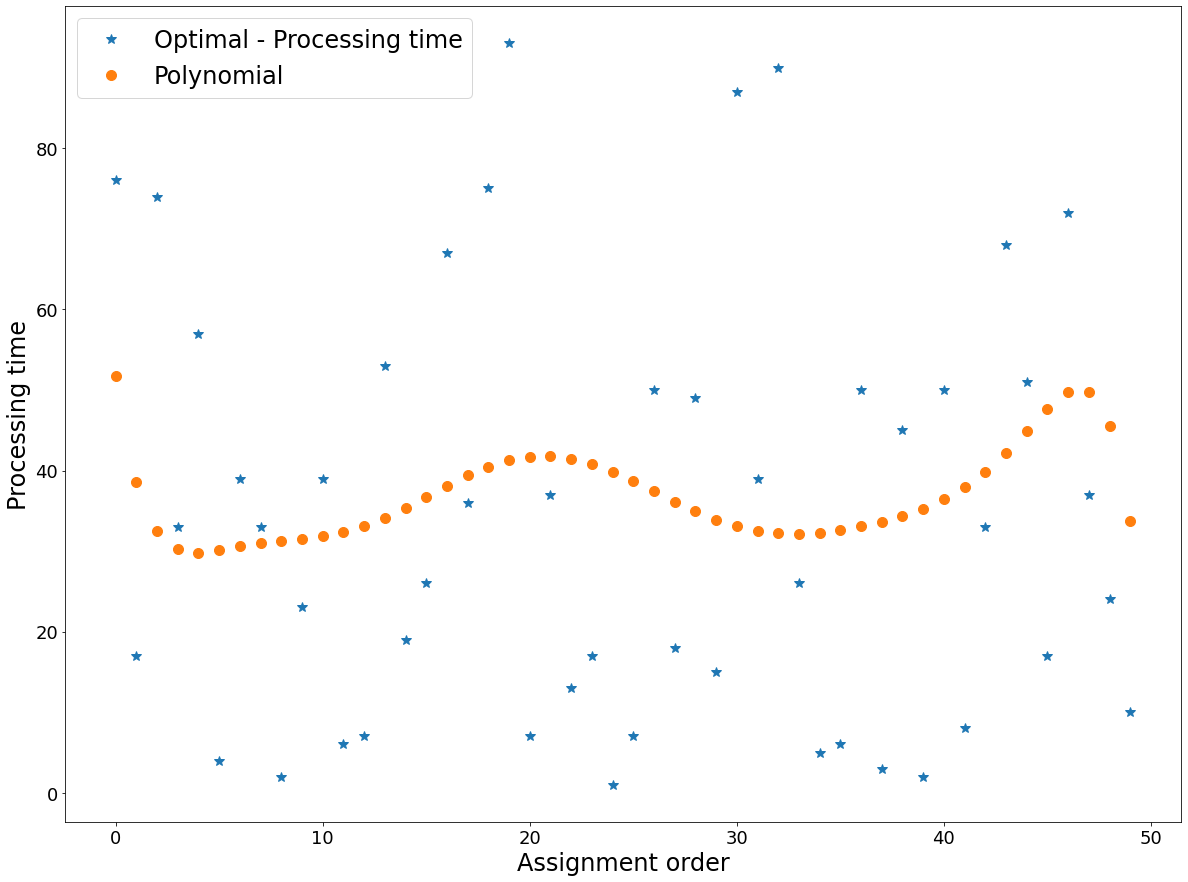

15
dataset: ./all_data/4x50/4x50-1.csv
dataset: ./all_data/4x50/4x50-2.csv
dataset: ./all_data/4x50/4x50-3.csv
dataset: ./all_data/4x50/4x50-4.csv
dataset: ./all_data/4x50/4x50-5.csv
Min-Min makespan: 307
process: [1, 1, 3, 3, 4, 4, 6, 6, 4, 11, 6, 6, 15, 8, 7, 14, 11, 15, 15, 13, 21, 18, 19, 14, 22, 19, 23, 20, 24, 26, 21, 29, 30, 26, 29, 34, 31, 34, 31, 35, 33, 40, 42, 46, 41, 42, 48, 53, 75, 62]

HASA makespan: 307
process: [11, 14, 15, 1, 15, 4, 3, 7, 3, 6, 1, 6, 4, 11, 4, 6, 6, 15, 8, 13, 21, 18, 19, 14, 22, 19, 23, 20, 24, 26, 21, 29, 30, 26, 29, 34, 31, 34, 31, 35, 33, 40, 42, 46, 41, 42, 48, 53, 75, 62]

Optimal makespan: 288
process: [30, 40, 23, 19, 4, 20, 42, 33, 18, 15, 34, 15, 26, 19, 14, 6, 11, 65, 22, 3, 14, 15, 6, 21, 34, 11, 6, 7, 13, 21, 41, 47, 4, 62, 1, 3, 35, 29, 42, 48, 1, 4, 31, 8, 6, 24, 46, 31, 26, 35]

Poly makespan: 307
process: [24, 23, 1, 26, 21, 3, 1, 4, 4, 3, 6, 4, 6, 6, 11, 6, 7, 15, 8, 14, 11, 15, 15, 13, 21, 18, 19, 14, 22, 19, 20, 29, 30, 26, 29, 34, 

/tmp/ipykernel_395369/2015407290.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


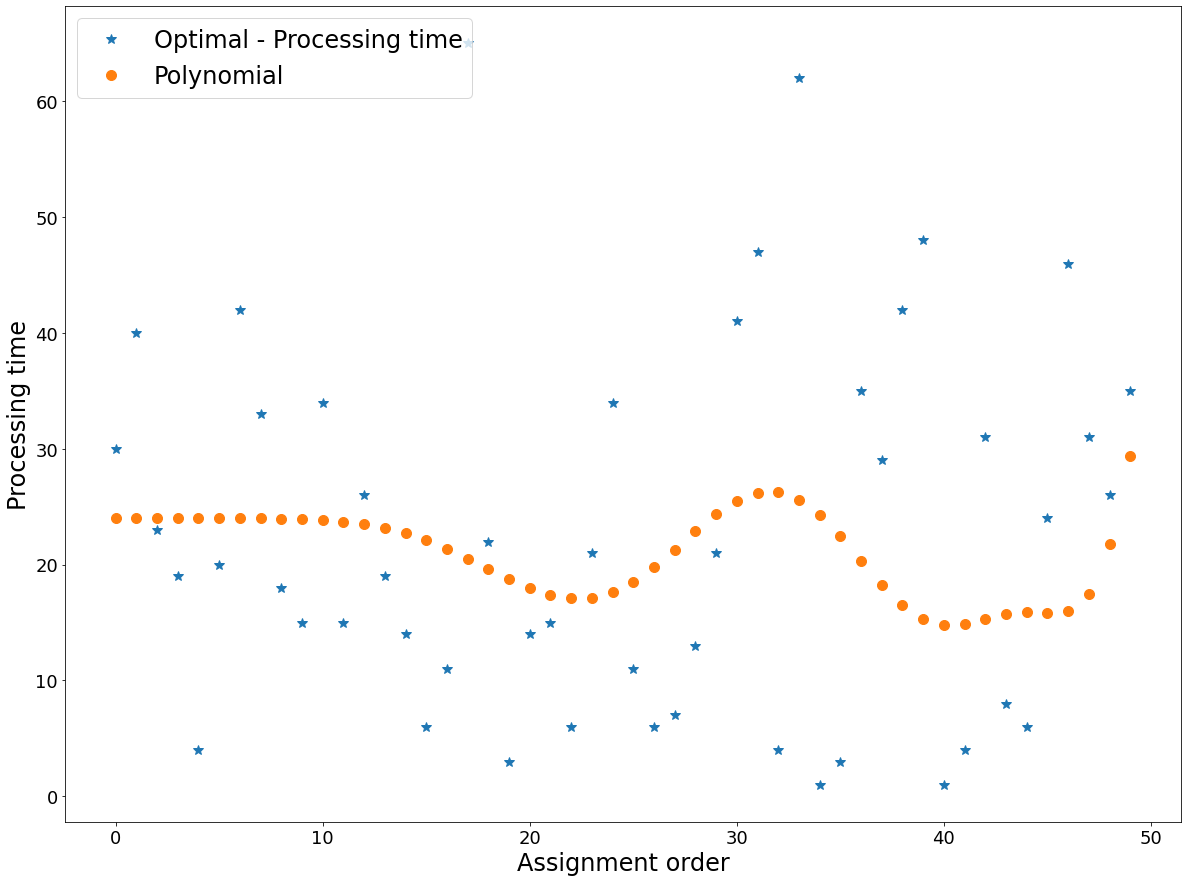

Min-Min makespan: 283
process: [1, 1, 2, 2, 3, 5, 6, 8, 7, 9, 8, 8, 10, 10, 9, 14, 10, 10, 11, 11, 14, 12, 15, 16, 16, 15, 17, 19, 19, 22, 18, 24, 21, 19, 32, 25, 22, 32, 32, 22, 33, 34, 27, 44, 50, 43, 42, 45, 54, 89]

HASA makespan: 283
process: [10, 11, 1, 1, 2, 14, 15, 3, 5, 6, 8, 1, 7, 9, 8, 10, 8, 10, 11, 14, 9, 10, 15, 16, 16, 12, 17, 17, 23, 22, 18, 21, 24, 19, 32, 32, 22, 25, 32, 22, 33, 34, 27, 44, 43, 50, 42, 45, 54, 89]

Optimal makespan: 251
process: [1, 45, 27, 50, 17, 32, 22, 64, 15, 22, 8, 10, 32, 9, 10, 10, 44, 1, 36, 22, 15, 11, 11, 5, 18, 7, 32, 25, 50, 3, 16, 24, 19, 32, 42, 2, 8, 14, 2, 8, 19, 11, 6, 54, 9, 12, 21, 16, 17, 14]

Poly makespan: 288
process: [24, 2, 22, 25, 1, 1, 1, 22, 3, 5, 6, 8, 9, 7, 8, 10, 8, 14, 10, 9, 10, 11, 14, 10, 11, 15, 12, 16, 16, 15, 18, 17, 23, 18, 32, 32, 25, 19, 22, 32, 34, 33, 27, 44, 43, 50, 42, 45, 54, 89]





/tmp/ipykernel_395369/2015407290.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


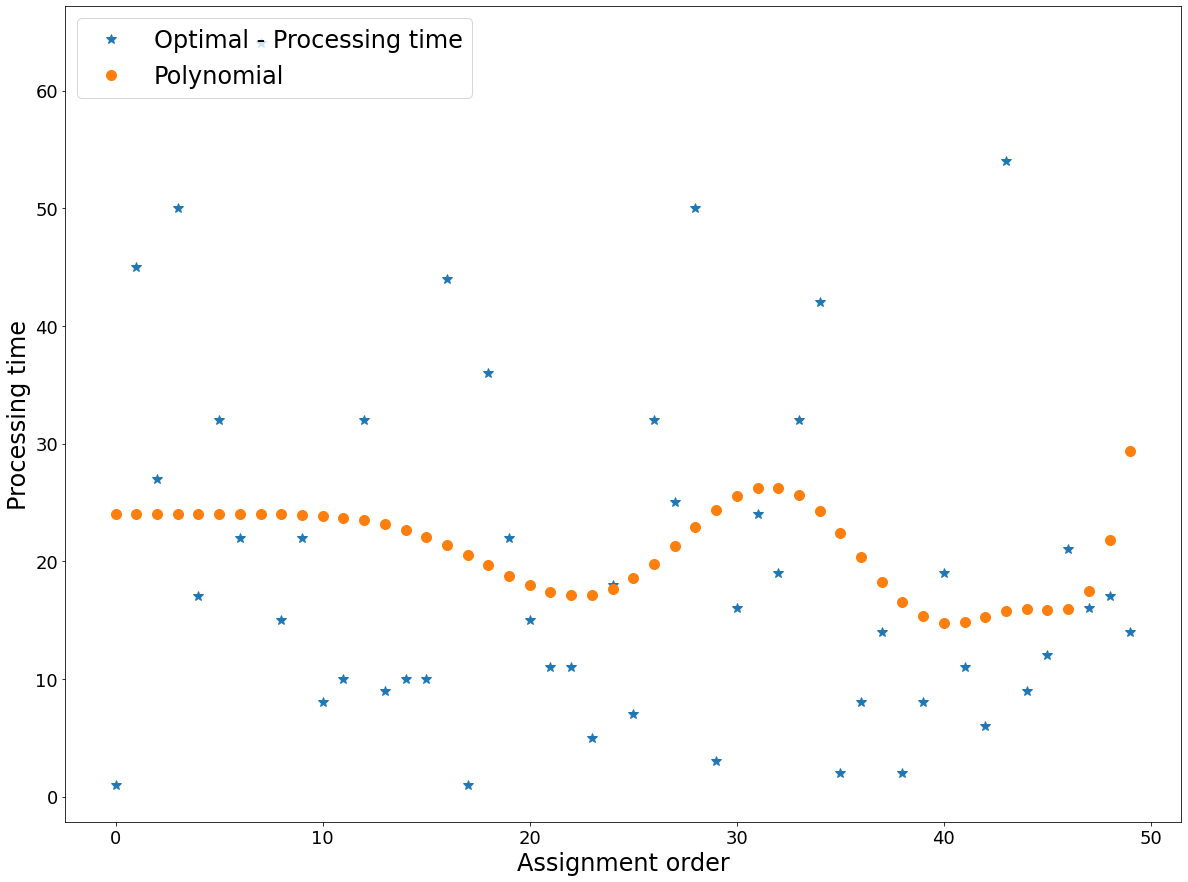

Min-Min makespan: 289
process: [1, 2, 3, 3, 2, 5, 3, 3, 5, 4, 4, 7, 5, 4, 9, 6, 5, 11, 8, 10, 11, 11, 12, 11, 15, 14, 12, 19, 12, 21, 20, 14, 22, 23, 26, 19, 25, 32, 33, 34, 32, 36, 34, 37, 38, 44, 68, 45, 44, 76]

HASA makespan: 289
process: [9, 10, 11, 12, 4, 4, 2, 3, 1, 3, 11, 5, 5, 3, 4, 5, 3, 7, 5, 4, 6, 11, 11, 8, 15, 12, 14, 19, 12, 21, 20, 14, 22, 23, 19, 26, 25, 32, 33, 34, 32, 36, 34, 37, 38, 68, 44, 45, 44, 76]

Optimal makespan: 240
process: [95, 12, 36, 25, 1, 39, 38, 2, 4, 26, 44, 15, 6, 5, 12, 14, 21, 19, 20, 3, 43, 3, 34, 10, 19, 12, 45, 14, 23, 3, 11, 44, 5, 11, 7, 21, 33, 8, 9, 32, 11, 5, 4, 2, 3, 4, 5, 34, 32, 22]

Poly makespan: 259
process: [25, 23, 25, 1, 26, 3, 2, 3, 2, 4, 5, 3, 5, 4, 7, 9, 5, 4, 6, 5, 11, 11, 8, 10, 11, 12, 15, 11, 14, 12, 21, 22, 12, 20, 14, 23, 32, 19, 33, 32, 34, 34, 43, 36, 43, 44, 38, 45, 95, 44]





/tmp/ipykernel_395369/2015407290.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


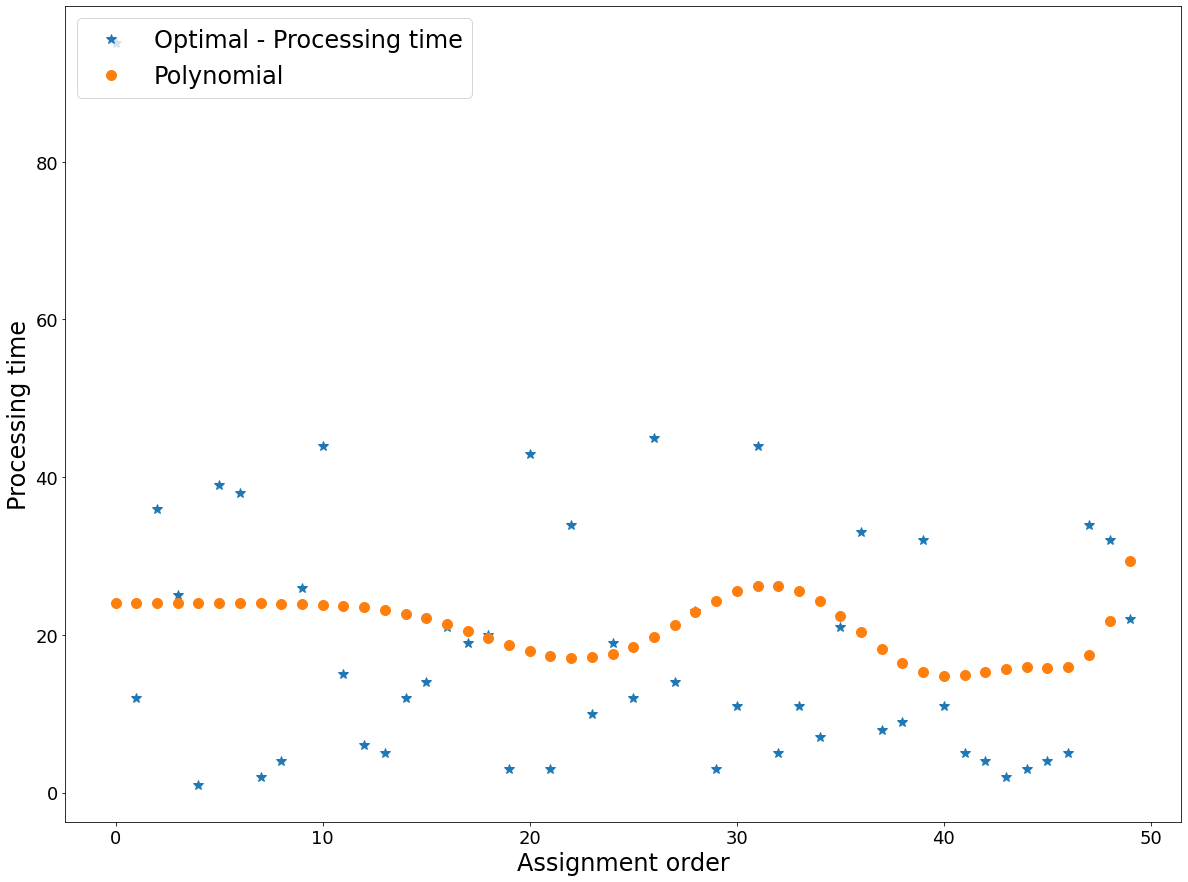

Min-Min makespan: 269
process: [1, 1, 1, 1, 1, 2, 2, 4, 3, 3, 3, 5, 3, 7, 4, 10, 7, 8, 6, 7, 8, 12, 16, 16, 9, 15, 17, 17, 14, 22, 15, 20, 25, 19, 28, 26, 28, 25, 29, 28, 35, 36, 36, 46, 47, 43, 60, 49, 60, 88]

HASA makespan: 266
process: [9, 10, 2, 12, 2, 14, 7, 4, 1, 4, 7, 3, 1, 1, 5, 3, 3, 16, 1, 6, 7, 3, 8, 8, 15, 17, 16, 14, 17, 22, 15, 25, 20, 19, 28, 28, 25, 26, 29, 28, 35, 36, 36, 46, 37, 56, 43, 60, 60, 90]

Optimal makespan: 246
process: [25, 10, 22, 36, 15, 2, 49, 1, 8, 28, 4, 5, 2, 8, 17, 7, 28, 1, 15, 7, 17, 7, 47, 37, 43, 3, 9, 35, 12, 7, 4, 60, 90, 26, 16, 19, 38, 20, 3, 3, 6, 14, 25, 36, 3, 16, 1, 1, 28, 60]

Poly makespan: 269
process: [25, 25, 26, 1, 22, 2, 1, 1, 1, 2, 1, 3, 4, 3, 3, 3, 5, 4, 7, 10, 7, 6, 8, 7, 12, 8, 16, 16, 9, 15, 17, 17, 14, 15, 28, 20, 28, 19, 29, 28, 35, 36, 36, 46, 47, 43, 60, 49, 60, 88]





/tmp/ipykernel_395369/2015407290.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


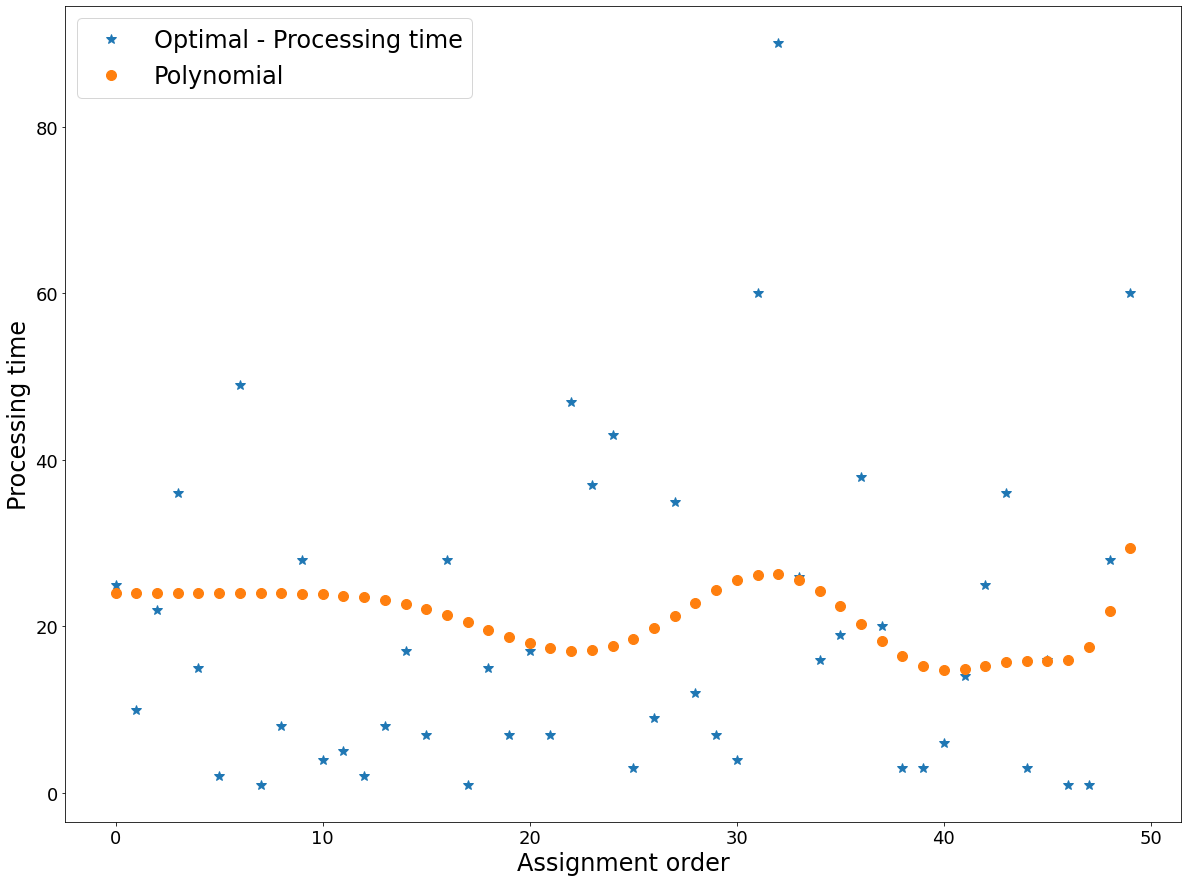

Min-Min makespan: 339
process: [1, 1, 1, 2, 2, 2, 2, 3, 5, 8, 3, 8, 6, 5, 6, 6, 10, 6, 8, 11, 23, 10, 12, 12, 12, 12, 25, 18, 18, 15, 15, 24, 29, 22, 34, 35, 46, 45, 47, 46, 49, 82, 47, 55, 57, 53, 86, 57, 65, 68]

HASA makespan: 360
process: [12, 1, 13, 1, 2, 2, 12, 6, 2, 5, 2, 23, 1, 3, 6, 11, 3, 8, 6, 5, 8, 6, 8, 12, 10, 14, 23, 18, 15, 24, 25, 15, 21, 22, 34, 45, 46, 35, 46, 49, 47, 82, 57, 55, 47, 86, 65, 57, 53, 68]

Optimal makespan: 303
process: [22, 1, 92, 57, 5, 45, 53, 46, 47, 61, 2, 24, 47, 2, 2, 1, 6, 58, 1, 12, 5, 12, 18, 82, 55, 6, 8, 11, 3, 18, 6, 60, 12, 55, 10, 25, 34, 8, 2, 35, 8, 15, 21, 10, 49, 15, 6, 3, 12, 14]

Poly makespan: 365
process: [24, 1, 25, 26, 25, 1, 1, 2, 2, 2, 2, 5, 3, 8, 8, 3, 6, 5, 6, 11, 6, 6, 8, 23, 12, 10, 12, 13, 12, 14, 34, 18, 15, 15, 22, 45, 55, 35, 49, 46, 47, 55, 57, 82, 47, 57, 65, 53, 86, 68]





/tmp/ipykernel_395369/2015407290.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


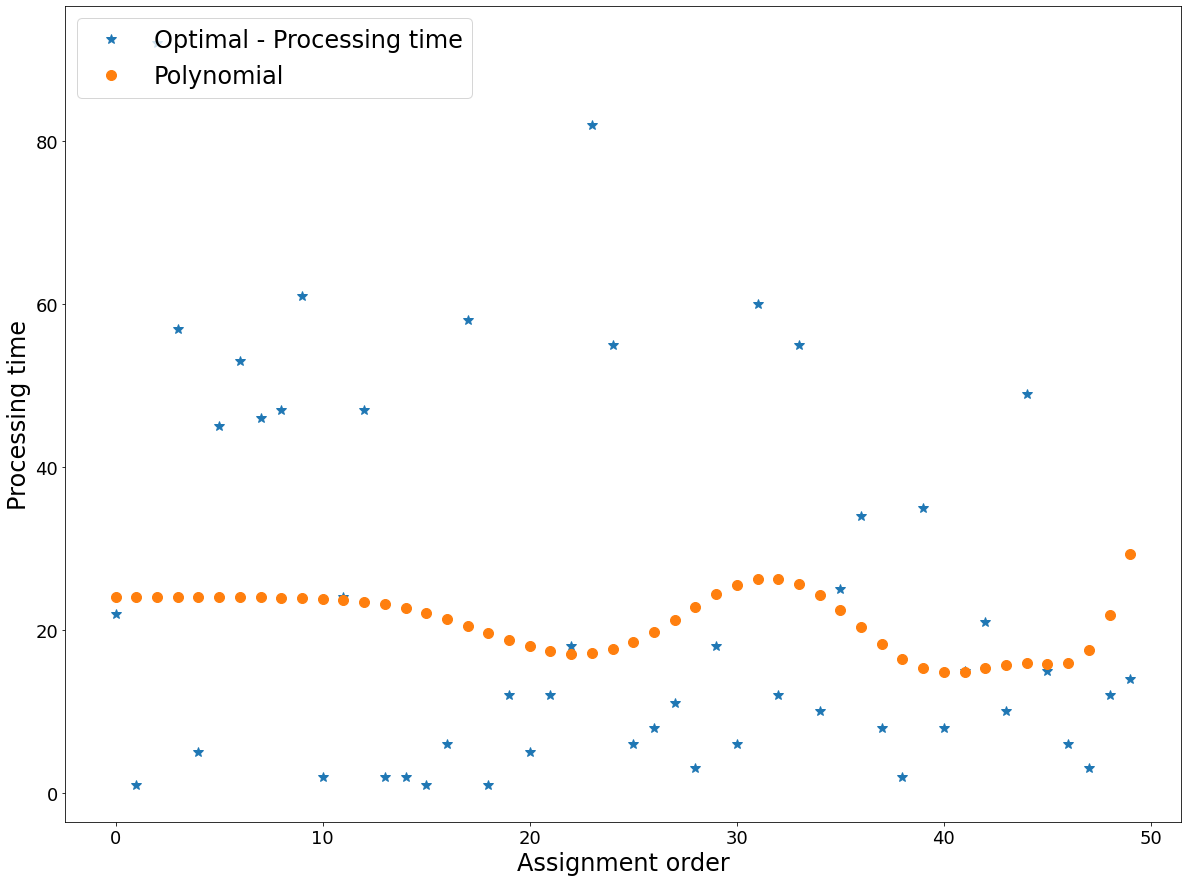

10
dataset: ./all_data/5x20/5x20-1.csv
dataset: ./all_data/5x20/5x20-2.csv
dataset: ./all_data/5x20/5x20-3.csv
dataset: ./all_data/5x20/5x20-4.csv
dataset: ./all_data/5x20/5x20-5.csv
Min-Min makespan: 139
process: [1, 2, 2, 5, 7, 9, 7, 8, 19, 11, 27, 25, 20, 40, 30, 29, 46, 48, 41, 41]

HASA makespan: 110
process: [11, 2, 9, 8, 18, 8, 23, 4, 7, 27, 19, 7, 29, 20, 43, 36, 40, 39, 60, 46]

Optimal makespan: 96
process: [2, 7, 2, 42, 40, 46, 17, 39, 20, 30, 11, 27, 7, 36, 29, 8, 4, 29, 60, 9]

Poly makespan: 115
process: [11, 19, 8, 2, 23, 27, 29, 1, 5, 2, 7, 14, 7, 20, 36, 43, 41, 39, 41, 46]





/tmp/ipykernel_395369/2015407290.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


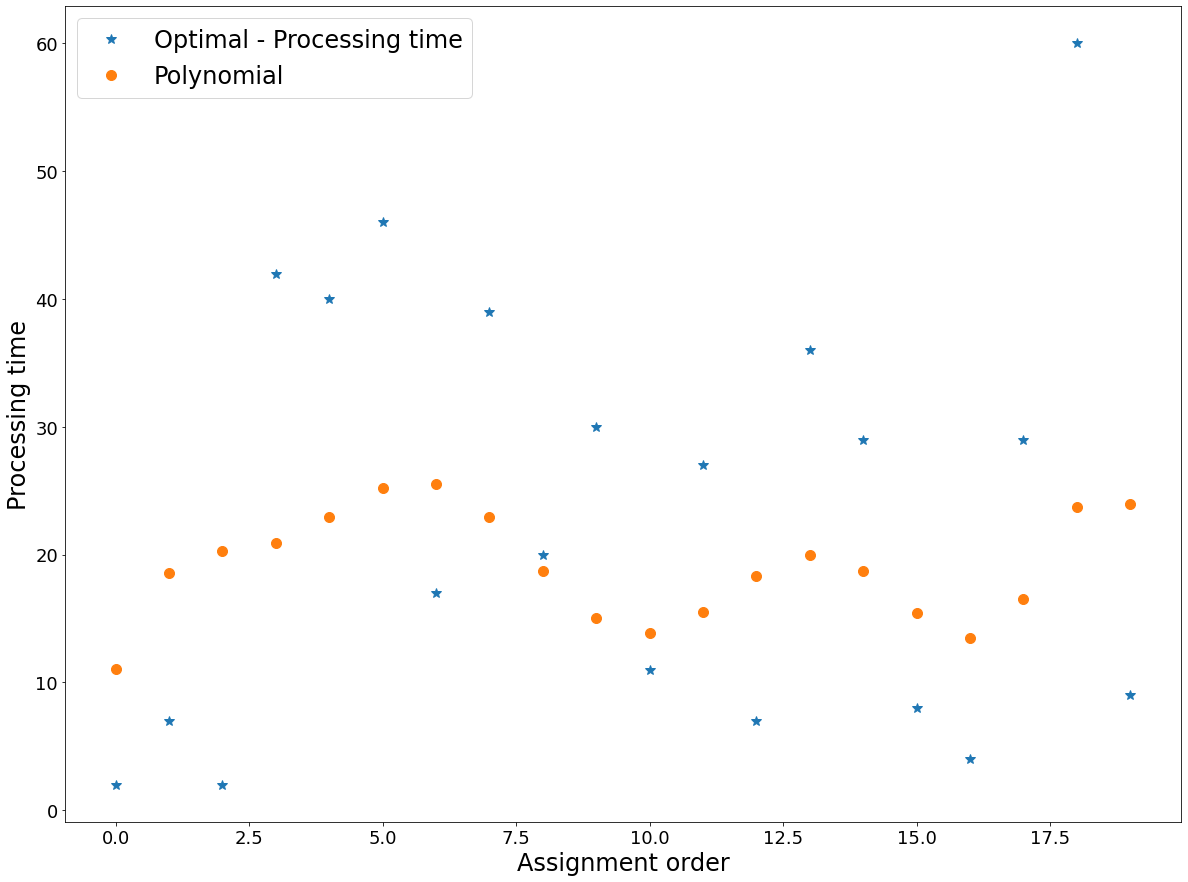

Min-Min makespan: 103
process: [1, 1, 3, 4, 6, 9, 13, 13, 12, 12, 20, 16, 12, 28, 20, 26, 36, 55, 33, 49]

HASA makespan: 103
process: [9, 1, 12, 13, 13, 1, 3, 20, 12, 4, 6, 16, 12, 28, 20, 26, 36, 55, 33, 49]

Optimal makespan: 80
process: [13, 20, 29, 13, 62, 9, 29, 22, 15, 26, 4, 28, 12, 20, 16, 6, 1, 1, 3, 54]

Poly makespan: 88
process: [12, 19, 20, 1, 22, 3, 26, 12, 1, 4, 6, 13, 12, 13, 26, 31, 29, 29, 49, 55]





/tmp/ipykernel_395369/2015407290.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


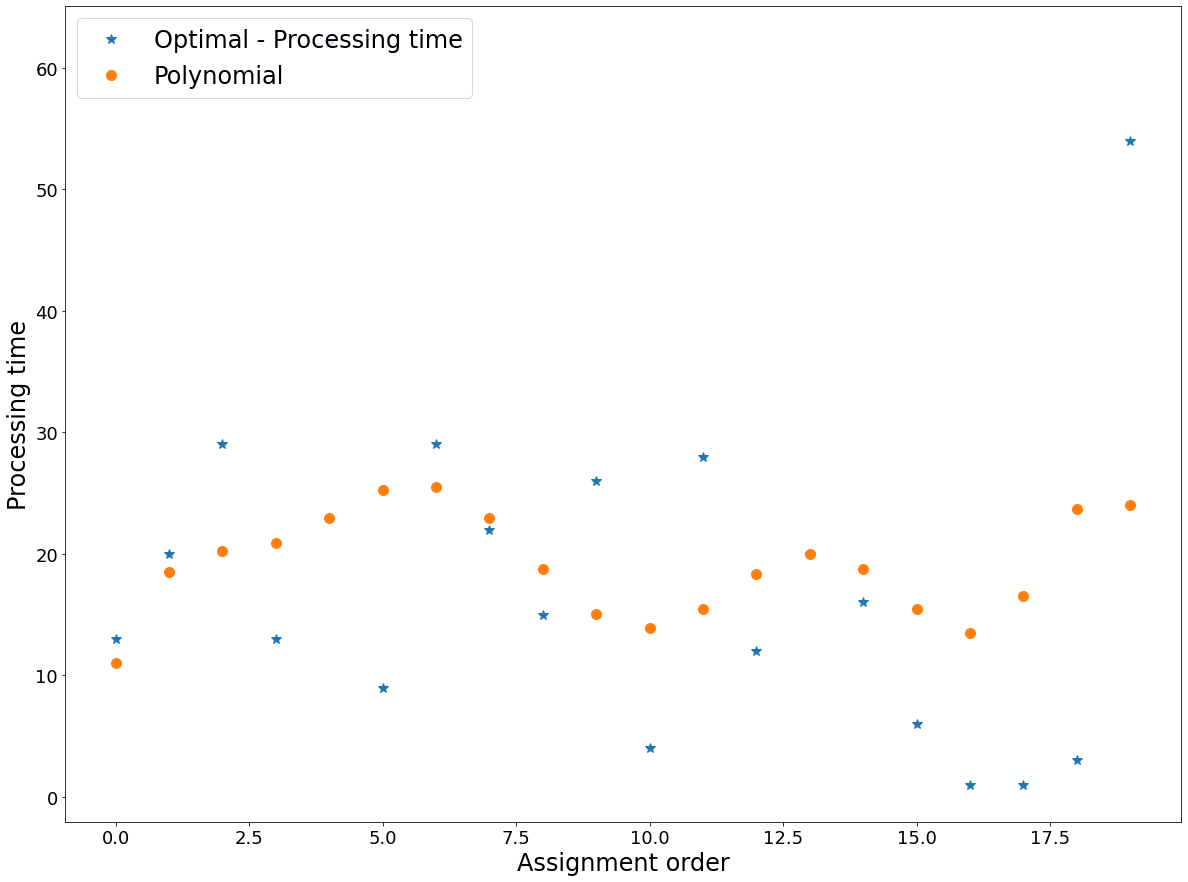

Min-Min makespan: 136
process: [1, 2, 4, 5, 5, 5, 4, 4, 10, 14, 18, 20, 30, 19, 21, 52, 44, 37, 51, 97]

HASA makespan: 131
process: [10, 14, 5, 1, 8, 4, 2, 20, 5, 30, 6, 18, 4, 19, 21, 52, 44, 37, 51, 97]

Optimal makespan: 85
process: [4, 20, 8, 30, 5, 18, 51, 14, 10, 44, 5, 1, 51, 2, 37, 4, 5, 70, 19, 21]

Poly makespan: 123
process: [10, 19, 20, 21, 11, 5, 29, 5, 4, 1, 4, 2, 4, 21, 18, 51, 37, 54, 51, 70]





/tmp/ipykernel_395369/2015407290.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


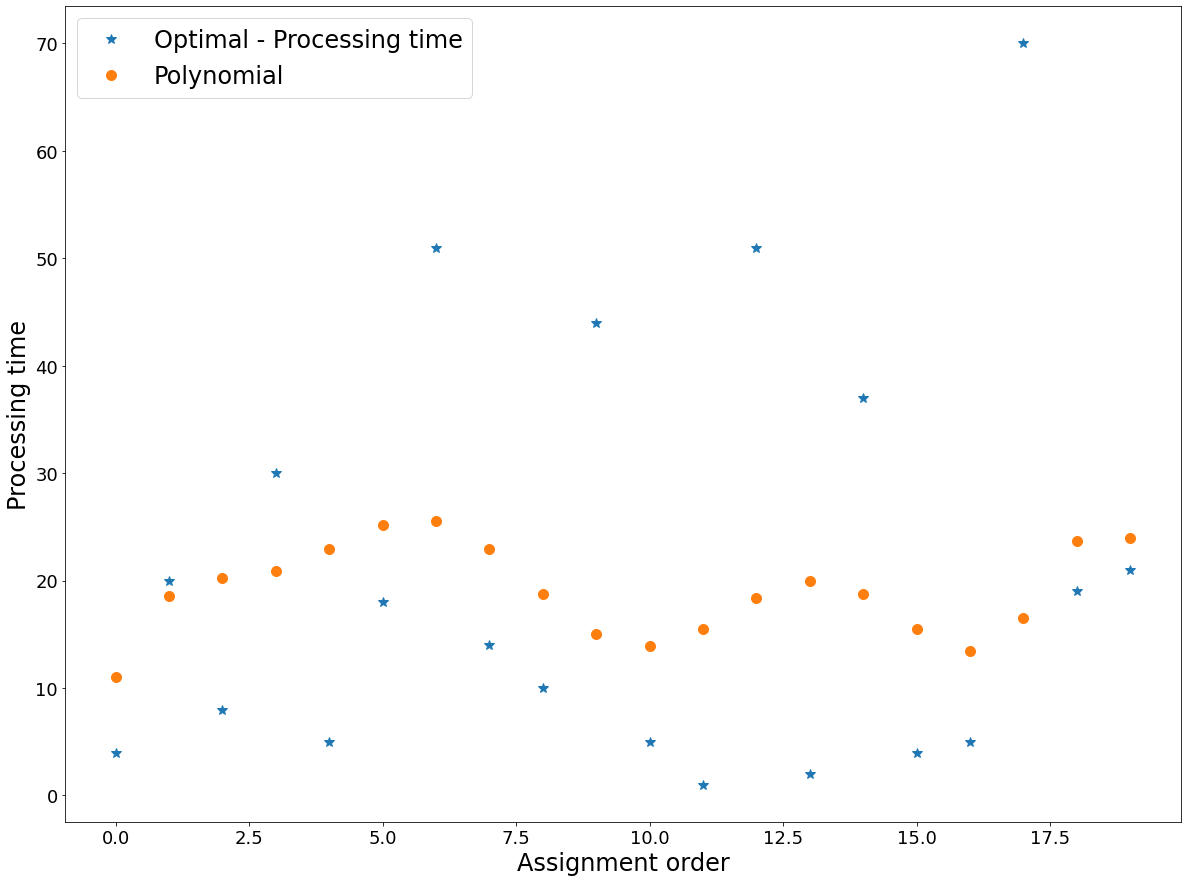

Min-Min makespan: 86
process: [2, 4, 4, 7, 7, 6, 13, 11, 9, 13, 12, 10, 18, 18, 16, 16, 13, 19, 34, 50]

HASA makespan: 86
process: [7, 7, 2, 9, 11, 13, 4, 4, 6, 13, 12, 10, 18, 18, 16, 16, 13, 19, 34, 50]

Optimal makespan: 64
process: [18, 2, 50, 15, 13, 13, 7, 4, 13, 11, 12, 10, 24, 4, 27, 6, 34, 7, 16, 13]

Poly makespan: 107
process: [11, 18, 19, 19, 4, 18, 6, 21, 2, 7, 12, 4, 9, 13, 28, 10, 16, 16, 34, 50]





/tmp/ipykernel_395369/2015407290.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


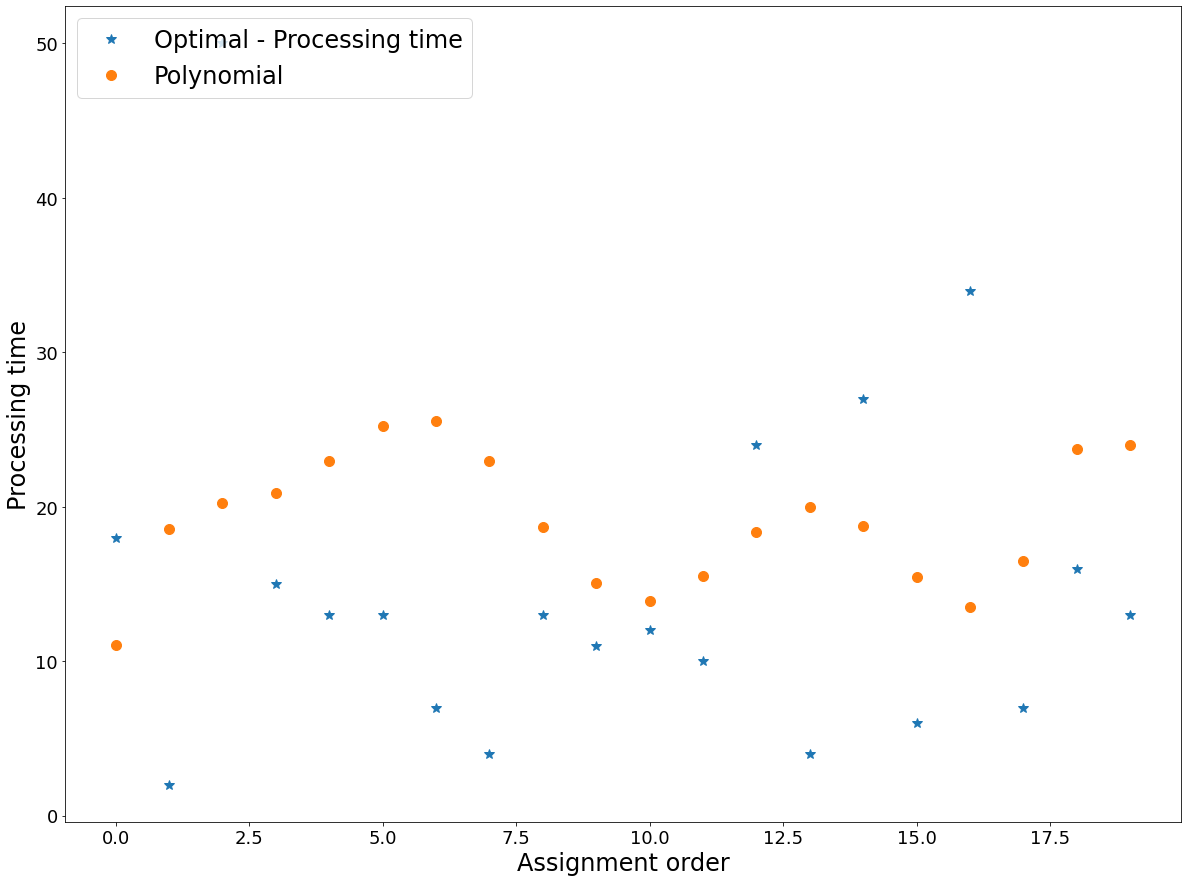

Min-Min makespan: 95
process: [1, 2, 2, 2, 2, 2, 2, 3, 9, 10, 6, 9, 19, 17, 25, 45, 46, 37, 45, 59]

HASA makespan: 88
process: [9, 9, 2, 1, 2, 3, 18, 3, 19, 6, 9, 4, 2, 25, 36, 17, 37, 50, 45, 46]

Optimal makespan: 77
process: [17, 50, 2, 2, 18, 19, 37, 10, 45, 3, 4, 2, 9, 35, 1, 46, 2, 2, 9, 25]

Poly makespan: 92
process: [9, 19, 17, 2, 9, 19, 2, 6, 3, 2, 2, 4, 2, 9, 36, 25, 37, 50, 46, 45]





/tmp/ipykernel_395369/2015407290.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


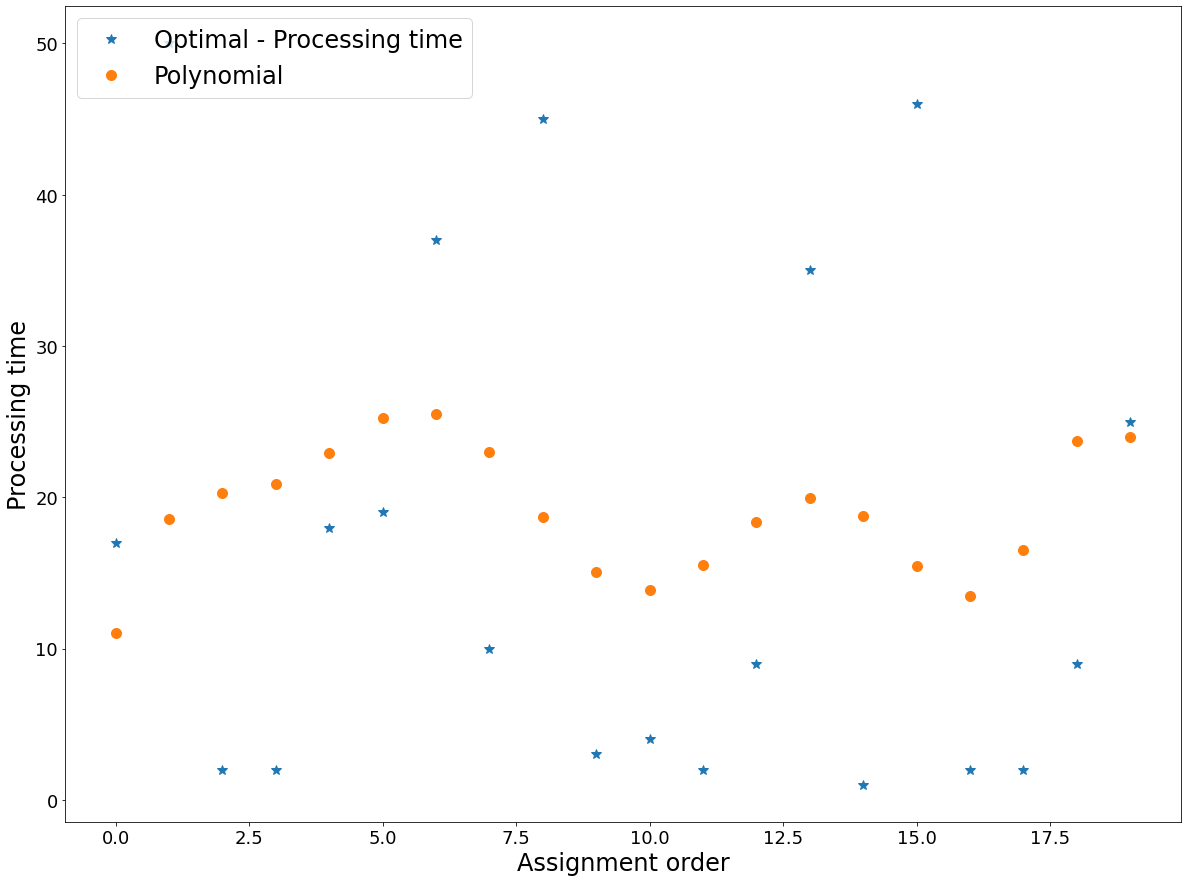

4
dataset: ./all_data/5x40/5x40-1.csv
dataset: ./all_data/5x40/5x40-2.csv
dataset: ./all_data/5x40/5x40-3.csv
dataset: ./all_data/5x40/5x40-4.csv
dataset: ./all_data/5x40/5x40-5.csv
Min-Min makespan: 144
process: [1, 1, 1, 2, 2, 3, 1, 2, 3, 3, 3, 6, 5, 4, 5, 5, 7, 5, 13, 7, 7, 14, 19, 13, 15, 18, 20, 23, 15, 17, 17, 34, 19, 18, 38, 46, 41, 56, 51, 57]

HASA makespan: 144
process: [7, 2, 7, 3, 1, 3, 1, 1, 13, 14, 4, 3, 2, 5, 2, 19, 1, 5, 3, 7, 5, 6, 5, 13, 15, 18, 20, 23, 15, 17, 17, 34, 19, 18, 38, 46, 41, 56, 51, 57]

Optimal makespan: 134
process: [56, 1, 56, 32, 4, 13, 7, 34, 3, 5, 46, 3, 1, 41, 3, 18, 1, 7, 15, 2, 1, 15, 2, 3, 5, 57, 23, 26, 7, 24, 17, 2, 13, 19, 20, 18, 7, 19, 5, 17]

Poly makespan: 146
process: [26, 24, 23, 22, 21, 2, 1, 3, 3, 2, 1, 1, 2, 1, 4, 6, 3, 3, 5, 5, 7, 13, 7, 7, 19, 14, 18, 13, 15, 20, 17, 17, 30, 34, 18, 46, 41, 57, 51, 56]





/tmp/ipykernel_395369/2015407290.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


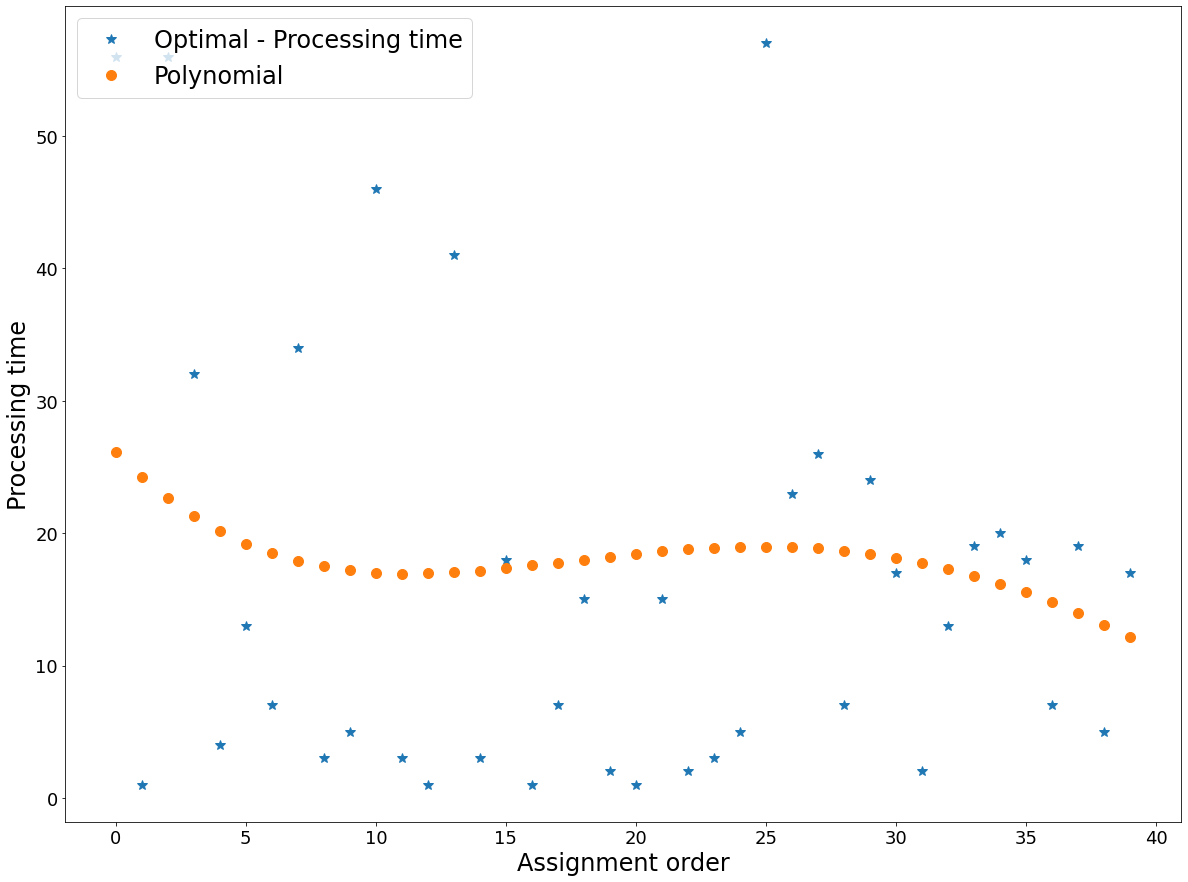

Min-Min makespan: 160
process: [1, 1, 1, 3, 4, 4, 6, 3, 6, 4, 4, 4, 7, 7, 4, 12, 5, 8, 8, 6, 11, 11, 17, 11, 16, 13, 14, 15, 17, 23, 18, 28, 26, 33, 39, 43, 54, 33, 77, 54]

HASA makespan: 158
process: [8, 8, 7, 11, 4, 12, 6, 1, 7, 4, 1, 4, 1, 3, 6, 4, 4, 3, 11, 4, 9, 5, 17, 6, 16, 13, 14, 15, 17, 23, 18, 28, 26, 33, 43, 39, 54, 33, 77, 54]

Optimal makespan: 137
process: [33, 9, 4, 33, 11, 7, 54, 36, 17, 11, 8, 54, 19, 18, 23, 1, 14, 9, 4, 1, 3, 77, 16, 13, 6, 7, 22, 6, 28, 5, 39, 4, 4, 25, 6, 4, 1, 17, 17, 8]

Poly makespan: 176
process: [28, 23, 22, 21, 24, 1, 4, 4, 3, 1, 3, 4, 4, 6, 4, 6, 8, 8, 4, 7, 12, 5, 9, 6, 11, 16, 11, 17, 14, 13, 15, 17, 18, 39, 54, 33, 43, 33, 77, 54]





/tmp/ipykernel_395369/2015407290.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


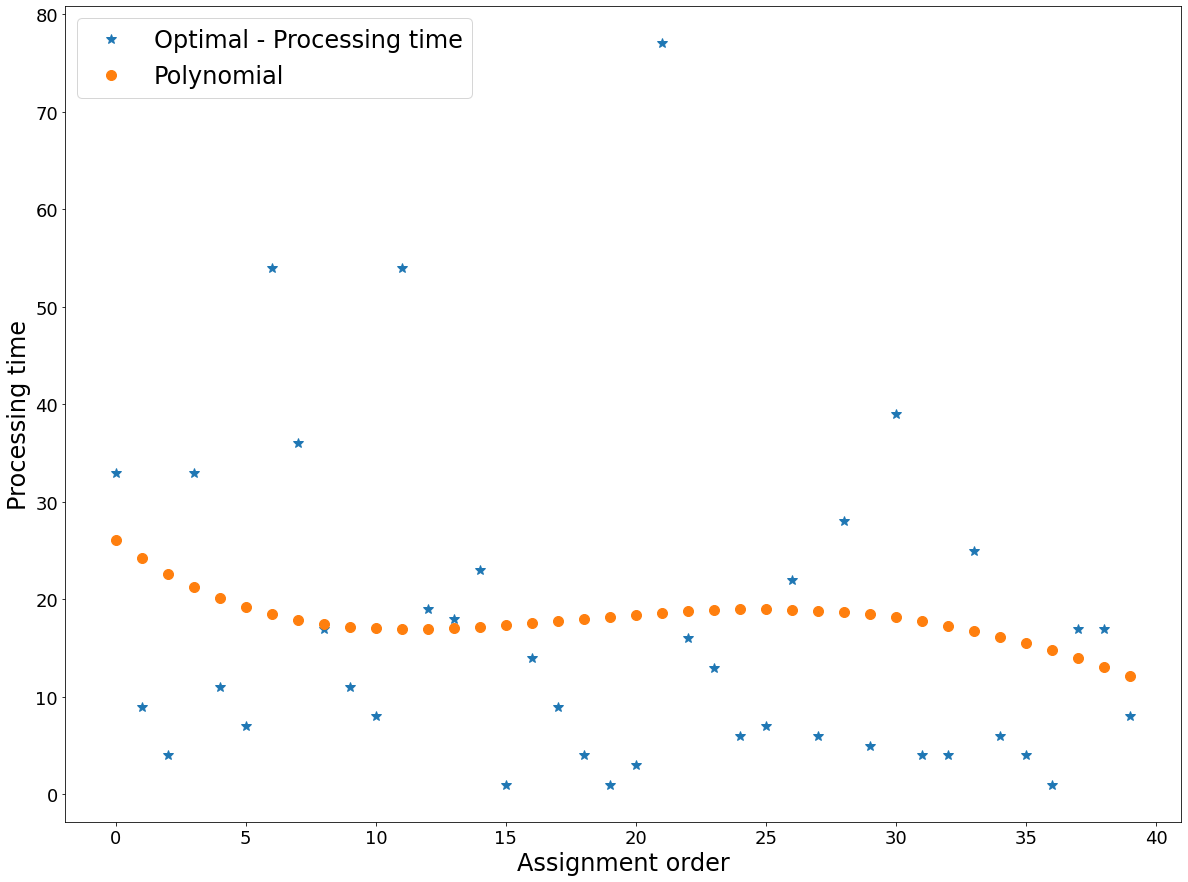

Min-Min makespan: 192
process: [2, 2, 2, 5, 3, 6, 5, 4, 8, 9, 5, 8, 6, 16, 17, 10, 8, 16, 11, 18, 18, 21, 21, 22, 22, 26, 41, 22, 27, 37, 31, 41, 38, 43, 42, 39, 72, 61, 44, 48]

HASA makespan: 192
process: [10, 11, 2, 5, 3, 16, 17, 16, 4, 6, 5, 8, 2, 9, 5, 2, 6, 8, 8, 18, 18, 21, 21, 22, 22, 26, 41, 22, 27, 37, 31, 41, 38, 43, 42, 39, 72, 61, 44, 48]

Optimal makespan: 177
process: [8, 61, 21, 72, 39, 17, 2, 6, 18, 2, 5, 31, 35, 3, 6, 44, 22, 48, 26, 6, 11, 51, 22, 9, 41, 8, 13, 38, 4, 5, 22, 37, 43, 27, 21, 12, 18, 6, 16, 5]

Poly makespan: 192
process: [26, 22, 22, 21, 2, 16, 2, 2, 3, 5, 6, 8, 4, 5, 5, 8, 9, 6, 17, 16, 8, 10, 11, 18, 18, 21, 41, 22, 27, 37, 31, 41, 38, 43, 42, 39, 72, 61, 44, 48]





/tmp/ipykernel_395369/2015407290.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


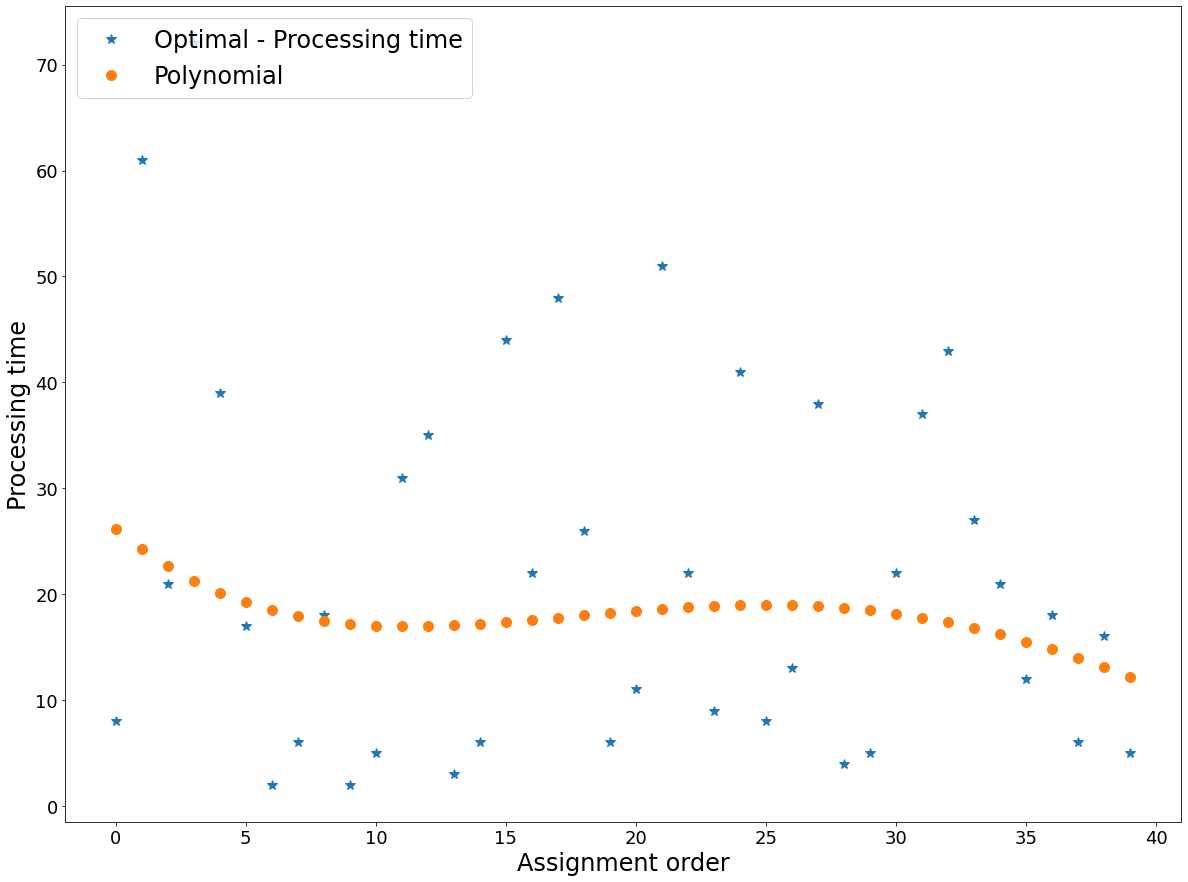

Min-Min makespan: 179
process: [1, 1, 1, 2, 1, 6, 5, 6, 7, 10, 7, 7, 8, 14, 7, 8, 12, 7, 14, 10, 15, 13, 22, 11, 19, 19, 18, 22, 29, 26, 19, 22, 24, 30, 27, 39, 44, 46, 40, 62]

HASA makespan: 179
process: [8, 2, 10, 13, 1, 14, 1, 14, 6, 1, 1, 5, 6, 7, 7, 12, 7, 8, 10, 7, 15, 15, 11, 19, 18, 19, 22, 22, 19, 26, 22, 29, 24, 31, 27, 39, 44, 53, 40, 62]

Optimal makespan: 148
process: [10, 5, 22, 24, 2, 6, 15, 11, 18, 6, 8, 1, 1, 14, 62, 7, 31, 21, 22, 1, 8, 41, 7, 40, 47, 14, 10, 26, 12, 46, 44, 19, 29, 7, 19, 15, 13, 22, 22, 1]

Poly makespan: 170
process: [26, 24, 22, 21, 21, 1, 1, 1, 6, 1, 5, 6, 10, 7, 7, 8, 14, 8, 7, 12, 10, 7, 14, 11, 15, 13, 22, 19, 19, 18, 22, 29, 19, 27, 39, 44, 30, 46, 40, 62]





/tmp/ipykernel_395369/2015407290.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


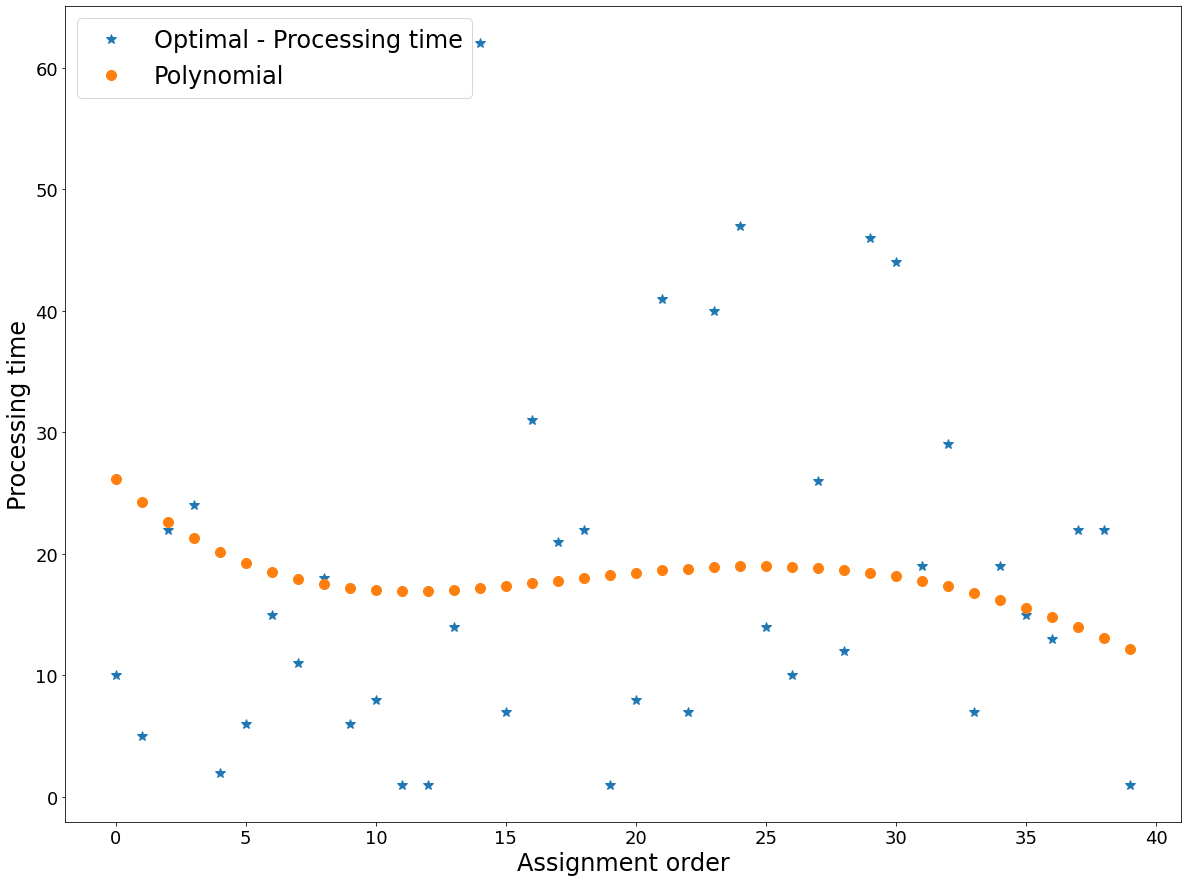

Min-Min makespan: 168
process: [1, 1, 2, 2, 1, 3, 3, 5, 6, 6, 6, 6, 13, 8, 9, 12, 12, 8, 11, 11, 21, 15, 17, 16, 17, 21, 19, 30, 20, 19, 26, 26, 31, 23, 54, 41, 34, 28, 51, 40]

HASA makespan: 168
process: [8, 9, 10, 2, 12, 13, 3, 3, 5, 1, 8, 6, 6, 6, 6, 1, 1, 11, 11, 12, 21, 17, 16, 15, 21, 19, 30, 17, 20, 19, 28, 26, 31, 23, 41, 34, 28, 54, 51, 40]

Optimal makespan: 139
process: [34, 2, 29, 19, 3, 13, 6, 28, 37, 45, 23, 21, 15, 19, 23, 16, 3, 12, 9, 6, 40, 20, 1, 28, 34, 2, 1, 21, 17, 8, 35, 6, 11, 5, 6, 1, 12, 8, 31, 30]

Poly makespan: 168
process: [26, 23, 1, 21, 20, 19, 2, 2, 1, 1, 3, 6, 6, 5, 6, 8, 13, 6, 9, 8, 12, 11, 12, 11, 21, 17, 15, 16, 19, 17, 30, 26, 19, 54, 31, 41, 34, 28, 51, 40]





/tmp/ipykernel_395369/2015407290.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


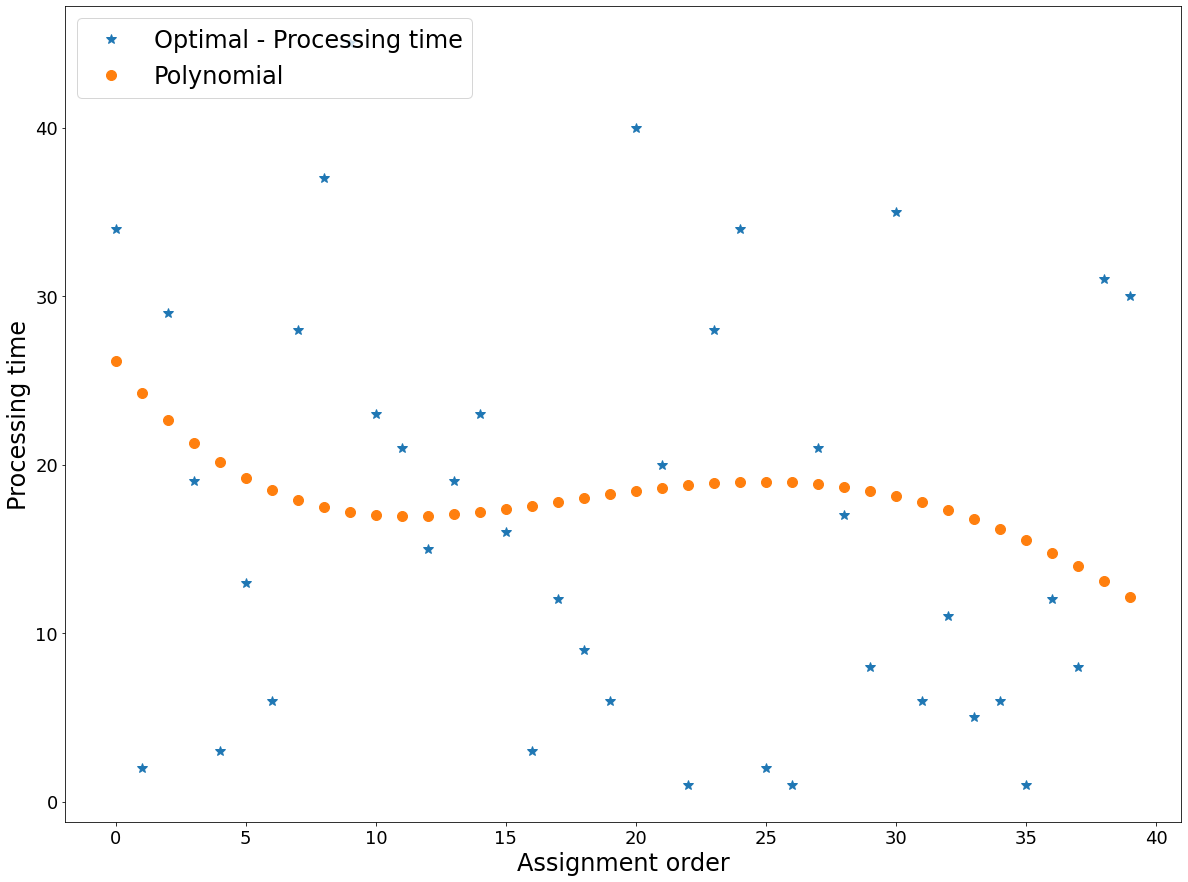

7
dataset: ./all_data/5x80/5x80-1.csv
dataset: ./all_data/5x80/5x80-2.csv
dataset: ./all_data/5x80/5x80-3.csv
dataset: ./all_data/5x80/5x80-4.csv
dataset: ./all_data/5x80/5x80-5.csv
Min-Min makespan: 279
process: [1, 1, 1, 2, 1, 3, 2, 3, 3, 3, 4, 3, 3, 6, 4, 4, 3, 5, 4, 6, 7, 5, 6, 6, 6, 8, 8, 11, 8, 7, 8, 8, 7, 8, 11, 9, 9, 9, 9, 14, 14, 13, 11, 10, 14, 17, 13, 19, 16, 18, 15, 22, 18, 25, 17, 27, 19, 23, 19, 25, 23, 24, 27, 22, 28, 23, 27, 29, 24, 28, 27, 27, 29, 37, 29, 37, 45, 40, 61, 59]

HASA makespan: 276
process: [7, 8, 9, 10, 3, 1, 3, 12, 6, 2, 3, 1, 3, 4, 1, 3, 3, 6, 3, 5, 1, 4, 6, 3, 6, 4, 5, 8, 11, 6, 6, 8, 8, 7, 8, 11, 8, 7, 9, 9, 9, 10, 17, 11, 14, 13, 16, 13, 18, 22, 19, 15, 18, 23, 17, 27, 25, 19, 19, 23, 27, 24, 25, 22, 23, 27, 29, 28, 24, 27, 27, 29, 28, 37, 37, 29, 35, 44, 55, 59]

Optimal makespan: 246
process: [19, 15, 9, 6, 8, 44, 8, 3, 3, 29, 4, 7, 40, 30, 6, 8, 1, 17, 2, 3, 9, 37, 2, 37, 6, 23, 1, 3, 17, 25, 17, 28, 27, 6, 16, 27, 3, 13, 19, 7, 9, 4, 28, 3, 29, 1

/tmp/ipykernel_395369/2015407290.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


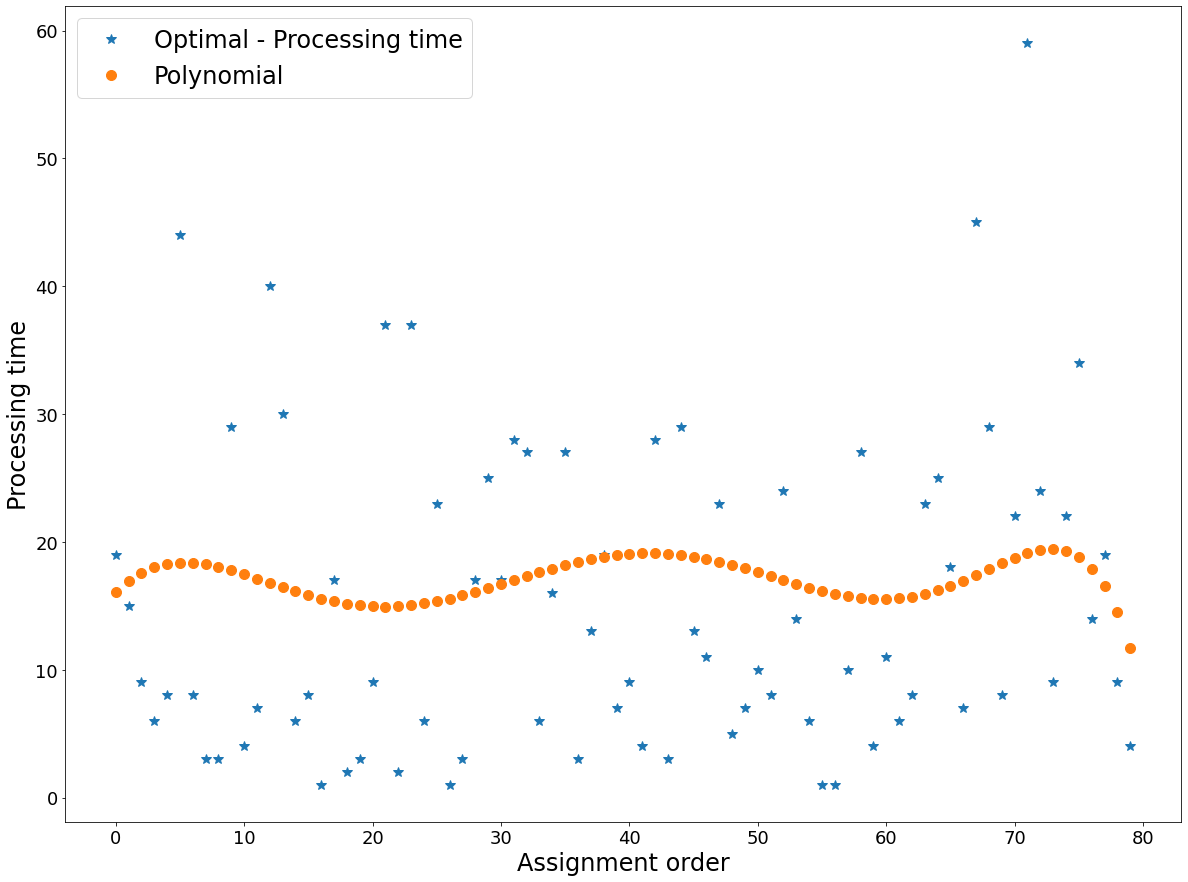

Min-Min makespan: 320
process: [1, 1, 2, 2, 1, 1, 2, 4, 4, 4, 5, 3, 5, 4, 5, 6, 7, 5, 5, 6, 5, 9, 6, 9, 5, 7, 8, 10, 7, 9, 7, 13, 10, 10, 11, 11, 11, 12, 16, 13, 19, 13, 15, 15, 20, 14, 26, 16, 19, 16, 22, 18, 17, 21, 33, 23, 25, 18, 24, 24, 20, 37, 27, 25, 21, 29, 30, 27, 25, 29, 51, 33, 36, 31, 57, 57, 43, 45, 61, 77]

HASA makespan: 334
process: [9, 9, 10, 11, 4, 13, 5, 2, 4, 1, 2, 7, 1, 5, 2, 1, 5, 1, 4, 3, 5, 4, 5, 6, 5, 10, 6, 6, 9, 5, 7, 10, 8, 7, 11, 7, 11, 16, 13, 13, 19, 12, 14, 15, 20, 15, 26, 16, 19, 16, 22, 17, 21, 18, 33, 23, 18, 24, 25, 20, 24, 37, 25, 21, 30, 29, 25, 25, 39, 29, 49, 35, 45, 31, 51, 43, 57, 53, 57, 100]

Optimal makespan: 284
process: [11, 27, 10, 24, 61, 5, 7, 1, 11, 27, 45, 5, 15, 17, 2, 7, 4, 24, 25, 2, 5, 12, 6, 14, 26, 21, 5, 4, 15, 5, 18, 21, 2, 30, 12, 25, 22, 13, 10, 9, 20, 5, 33, 29, 36, 6, 43, 43, 16, 9, 19, 57, 7, 1, 28, 25, 1, 18, 20, 37, 6, 10, 16, 9, 4, 16, 63, 11, 31, 29, 51, 33, 9, 13, 4, 8, 26, 3, 7, 1]

Poly makespan: 320
process: [16, 

/tmp/ipykernel_395369/2015407290.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


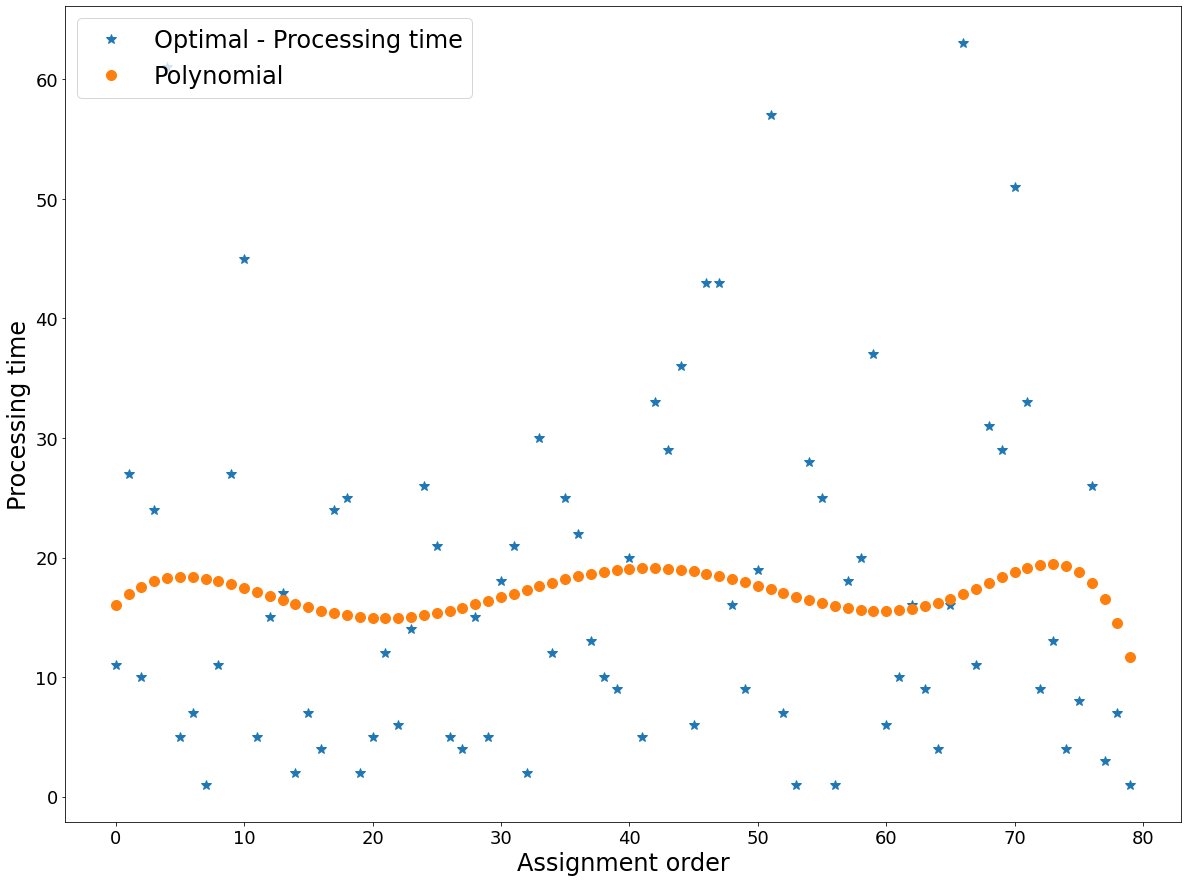

Min-Min makespan: 309
process: [1, 1, 1, 2, 1, 3, 3, 3, 3, 4, 4, 4, 3, 5, 4, 4, 11, 10, 5, 5, 6, 6, 6, 8, 10, 12, 6, 8, 8, 10, 8, 8, 14, 9, 11, 10, 11, 11, 16, 13, 15, 13, 11, 17, 16, 14, 12, 16, 16, 18, 15, 15, 16, 15, 16, 21, 21, 28, 24, 24, 21, 32, 31, 26, 28, 29, 35, 28, 30, 36, 42, 35, 31, 32, 31, 47, 71, 63, 37, 94]

HASA makespan: 309
process: [8, 9, 10, 1, 3, 2, 1, 12, 1, 13, 4, 4, 3, 4, 4, 3, 1, 5, 3, 3, 5, 4, 10, 11, 6, 5, 6, 8, 10, 6, 8, 14, 6, 8, 11, 8, 11, 11, 16, 10, 15, 13, 11, 17, 16, 14, 12, 16, 16, 18, 15, 15, 16, 15, 16, 21, 21, 28, 24, 24, 21, 32, 31, 26, 28, 29, 35, 28, 30, 36, 42, 35, 31, 32, 31, 47, 71, 63, 37, 94]

Optimal makespan: 275
process: [16, 24, 4, 35, 8, 8, 8, 8, 1, 14, 5, 4, 3, 3, 11, 10, 32, 10, 42, 11, 1, 47, 32, 5, 13, 24, 10, 4, 11, 16, 2, 15, 3, 6, 31, 10, 18, 38, 32, 6, 11, 16, 8, 4, 15, 13, 21, 15, 26, 17, 88, 21, 36, 5, 16, 28, 37, 14, 9, 11, 1, 6, 3, 21, 3, 28, 6, 12, 31, 4, 16, 21, 15, 64, 12, 1, 30, 15, 41, 36]

Poly makespan: 301
process: 

/tmp/ipykernel_395369/2015407290.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


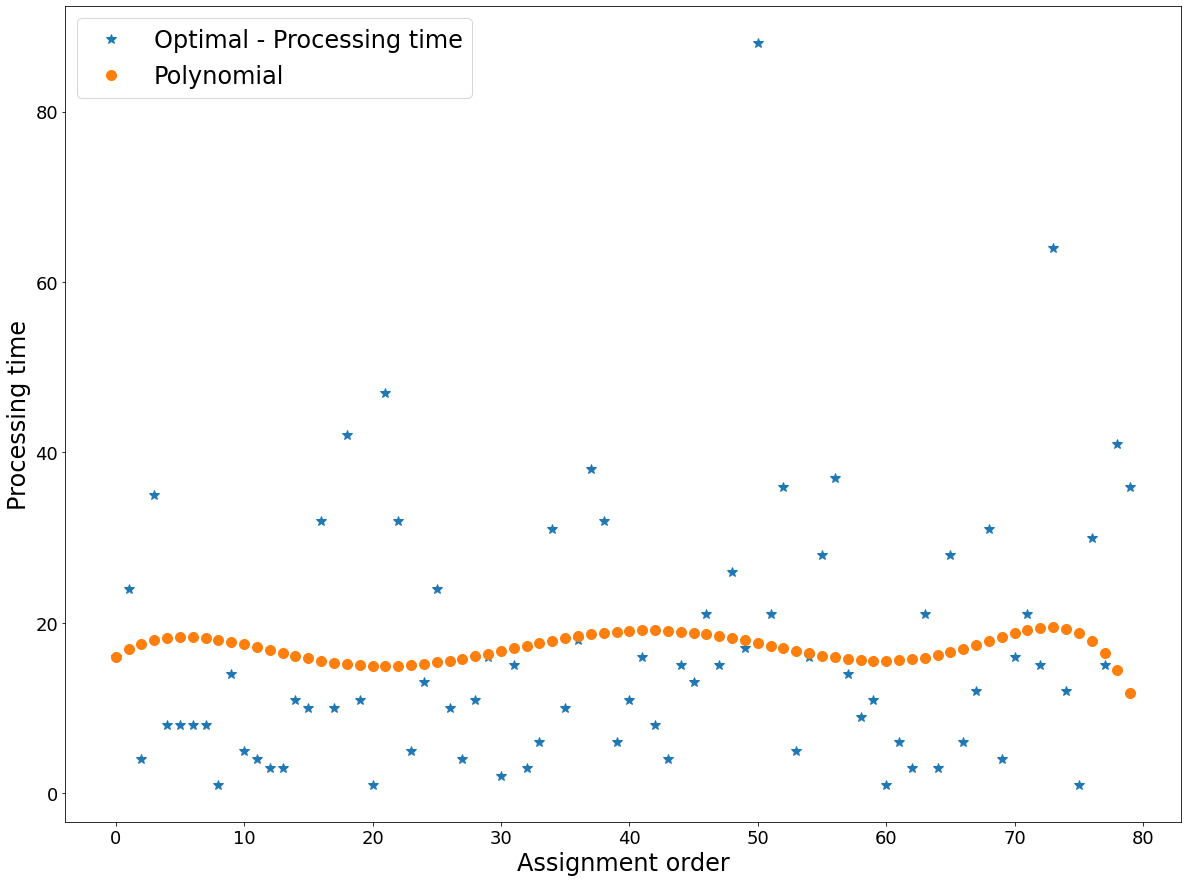

Min-Min makespan: 335
process: [1, 1, 3, 3, 3, 5, 6, 3, 3, 5, 3, 4, 6, 7, 4, 5, 8, 6, 4, 5, 9, 7, 6, 8, 5, 6, 8, 11, 10, 8, 18, 12, 8, 13, 14, 10, 14, 19, 16, 17, 16, 15, 19, 17, 21, 18, 19, 26, 19, 22, 29, 22, 22, 31, 26, 30, 26, 27, 34, 27, 31, 32, 28, 27, 36, 28, 36, 44, 28, 37, 31, 38, 32, 49, 41, 44, 58, 48, 61, 56]

HASA makespan: 330
process: [10, 10, 11, 1, 12, 3, 5, 3, 1, 5, 17, 3, 5, 4, 3, 3, 6, 6, 3, 4, 8, 4, 6, 7, 5, 8, 5, 7, 9, 6, 14, 8, 13, 8, 8, 18, 14, 17, 16, 16, 15, 19, 17, 21, 18, 19, 19, 26, 22, 29, 19, 22, 31, 22, 26, 30, 27, 26, 34, 27, 28, 32, 31, 27, 36, 28, 44, 28, 36, 31, 37, 32, 38, 49, 41, 58, 48, 44, 56, 61]

Optimal makespan: 313
process: [7, 8, 8, 31, 58, 3, 26, 1, 36, 14, 40, 5, 11, 30, 32, 6, 32, 26, 5, 28, 21, 11, 49, 6, 10, 18, 19, 1, 7, 48, 3, 56, 5, 3, 17, 9, 27, 32, 44, 8, 19, 22, 31, 61, 3, 6, 27, 8, 38, 16, 3, 16, 27, 10, 8, 4, 22, 17, 29, 5, 25, 18, 37, 5, 19, 37, 4, 3, 22, 19, 15, 14, 12, 15, 31, 28, 38, 6, 34, 4]

Poly makespan: 347
process: [

/tmp/ipykernel_395369/2015407290.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


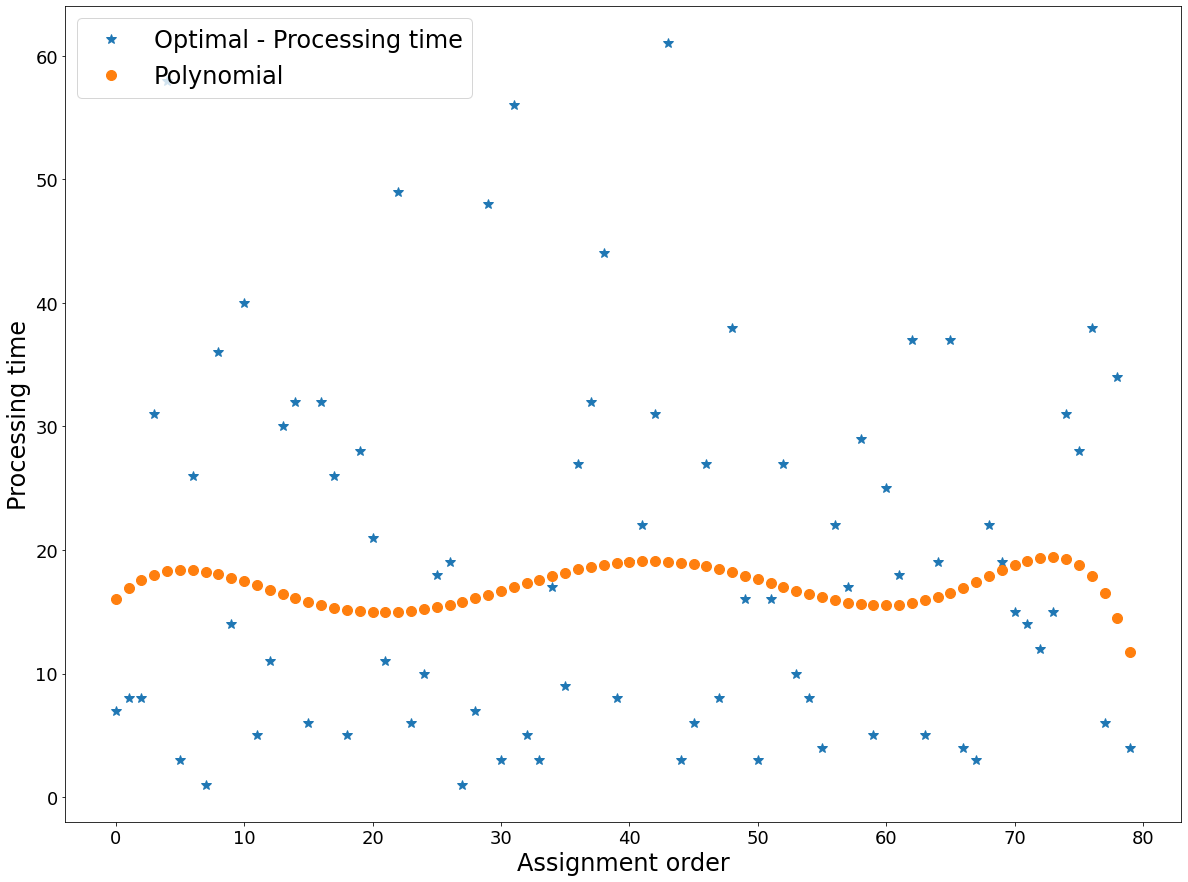

Min-Min makespan: 302
process: [1, 1, 2, 2, 1, 1, 1, 2, 2, 4, 4, 3, 4, 3, 4, 5, 7, 4, 4, 4, 5, 5, 7, 5, 11, 6, 6, 5, 7, 6, 6, 8, 8, 11, 7, 8, 8, 11, 10, 13, 12, 10, 14, 19, 15, 17, 10, 18, 12, 16, 20, 25, 12, 24, 19, 13, 22, 27, 20, 16, 27, 24, 18, 25, 34, 20, 33, 34, 27, 35, 28, 36, 34, 43, 31, 61, 49, 70, 60, 89]

HASA makespan: 315
process: [8, 8, 9, 2, 11, 2, 1, 12, 4, 3, 7, 4, 2, 4, 1, 1, 1, 2, 4, 1, 4, 3, 7, 4, 5, 5, 4, 5, 5, 6, 7, 11, 6, 5, 6, 6, 10, 7, 11, 8, 17, 10, 14, 15, 10, 20, 25, 18, 10, 15, 12, 22, 20, 16, 26, 13, 20, 16, 24, 24, 27, 18, 25, 27, 33, 20, 34, 27, 34, 28, 34, 35, 36, 31, 49, 43, 70, 61, 60, 83]

Optimal makespan: 259
process: [11, 10, 20, 18, 75, 6, 16, 61, 18, 15, 36, 8, 5, 2, 3, 7, 2, 17, 49, 43, 34, 24, 10, 7, 1, 12, 25, 34, 27, 5, 8, 36, 15, 25, 4, 5, 13, 28, 14, 1, 31, 55, 20, 20, 12, 16, 7, 8, 1, 5, 27, 17, 6, 27, 12, 10, 28, 4, 2, 33, 61, 2, 11, 4, 11, 5, 3, 4, 4, 8, 4, 6, 4, 19, 7, 10, 1, 22, 6, 1]

Poly makespan: 285
process: [16, 17, 18, 1, 19, 1

/tmp/ipykernel_395369/2015407290.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


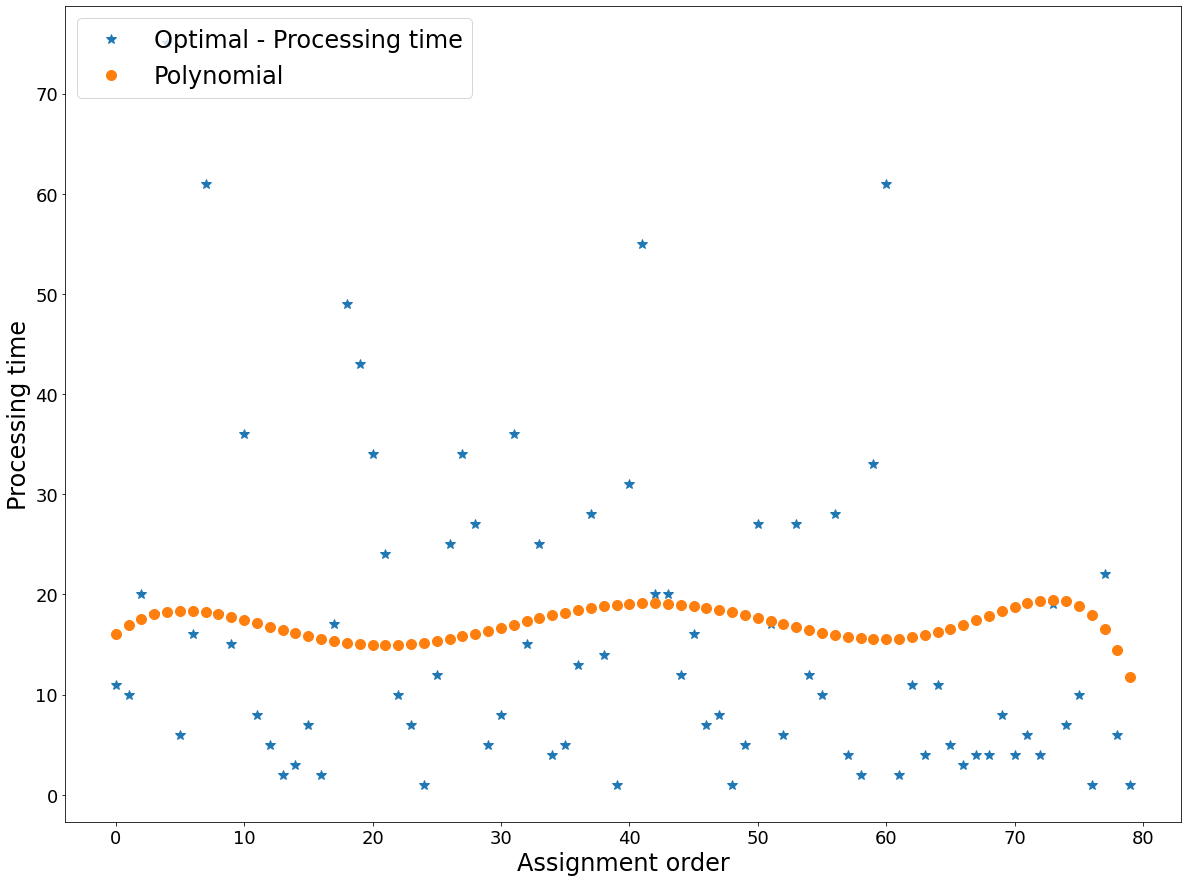

6
dataset: ./all_data/8x50/8x50-1.csv
dataset: ./all_data/8x50/8x50-2.csv
dataset: ./all_data/8x50/8x50-3.csv
dataset: ./all_data/8x50/8x50-4.csv
dataset: ./all_data/8x50/8x50-5.csv
Min-Min makespan: 115
process: [1, 1, 1, 2, 2, 1, 1, 4, 4, 4, 3, 4, 4, 6, 4, 3, 6, 5, 6, 8, 6, 8, 6, 9, 8, 7, 9, 12, 11, 10, 11, 12, 11, 11, 14, 11, 13, 17, 22, 16, 18, 25, 16, 31, 18, 25, 20, 26, 33, 59]

HASA makespan: 115
process: [6, 6, 6, 6, 7, 1, 2, 8, 1, 9, 1, 1, 4, 11, 1, 4, 2, 4, 3, 3, 4, 4, 11, 12, 5, 7, 8, 6, 10, 8, 12, 9, 11, 11, 11, 22, 14, 13, 17, 18, 31, 16, 18, 18, 25, 20, 25, 26, 49, 59]

Optimal makespan: 81
process: [59, 6, 4, 6, 12, 16, 26, 2, 11, 18, 4, 4, 33, 1, 2, 1, 20, 33, 8, 11, 25, 10, 22, 1, 6, 14, 11, 9, 4, 25, 15, 8, 9, 7, 21, 1, 13, 31, 6, 26, 1, 6, 4, 20, 8, 5, 6, 17, 3, 18]

Poly makespan: 110
process: [20, 16, 13, 13, 12, 11, 11, 11, 1, 2, 1, 2, 4, 4, 4, 4, 1, 1, 3, 6, 2, 3, 6, 6, 8, 6, 4, 8, 6, 9, 7, 9, 8, 10, 11, 17, 12, 22, 14, 18, 11, 18, 13, 18, 31, 25, 25, 26, 49, 64]

/tmp/ipykernel_395369/2015407290.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


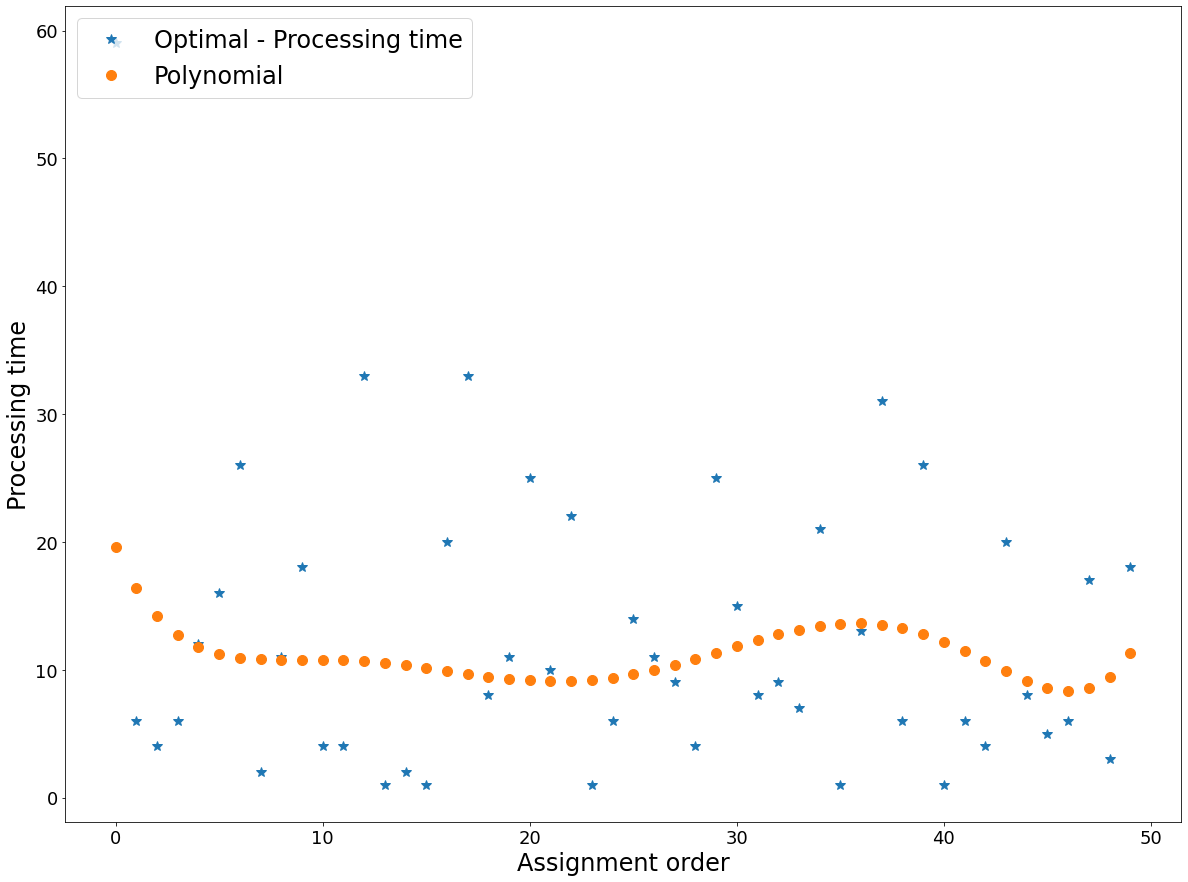

Min-Min makespan: 96
process: [1, 1, 1, 2, 1, 1, 3, 3, 4, 5, 3, 4, 3, 3, 4, 4, 4, 5, 5, 5, 8, 7, 7, 7, 5, 5, 10, 8, 9, 6, 8, 13, 12, 12, 11, 11, 11, 13, 17, 15, 12, 16, 17, 24, 18, 29, 20, 45, 37, 60]

HASA makespan: 96
process: [5, 5, 5, 1, 1, 7, 7, 7, 1, 1, 8, 1, 10, 3, 5, 3, 4, 4, 3, 2, 3, 4, 4, 5, 3, 5, 4, 8, 9, 6, 8, 13, 12, 12, 11, 11, 11, 13, 17, 15, 12, 16, 17, 24, 18, 29, 20, 45, 37, 60]

Optimal makespan: 67
process: [1, 37, 8, 2, 11, 17, 18, 7, 19, 11, 4, 5, 12, 13, 3, 7, 23, 4, 1, 6, 3, 5, 5, 13, 3, 4, 20, 25, 2, 17, 5, 4, 5, 1, 5, 29, 28, 16, 1, 14, 12, 19, 3, 4, 15, 8, 3, 5, 10, 24]

Poly makespan: 98
process: [20, 16, 15, 13, 12, 11, 11, 1, 2, 1, 7, 3, 3, 2, 4, 3, 1, 4, 3, 4, 5, 4, 1, 5, 3, 7, 5, 8, 7, 5, 15, 5, 10, 5, 8, 8, 6, 9, 12, 17, 11, 18, 17, 11, 12, 29, 24, 25, 37, 37]





/tmp/ipykernel_395369/2015407290.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


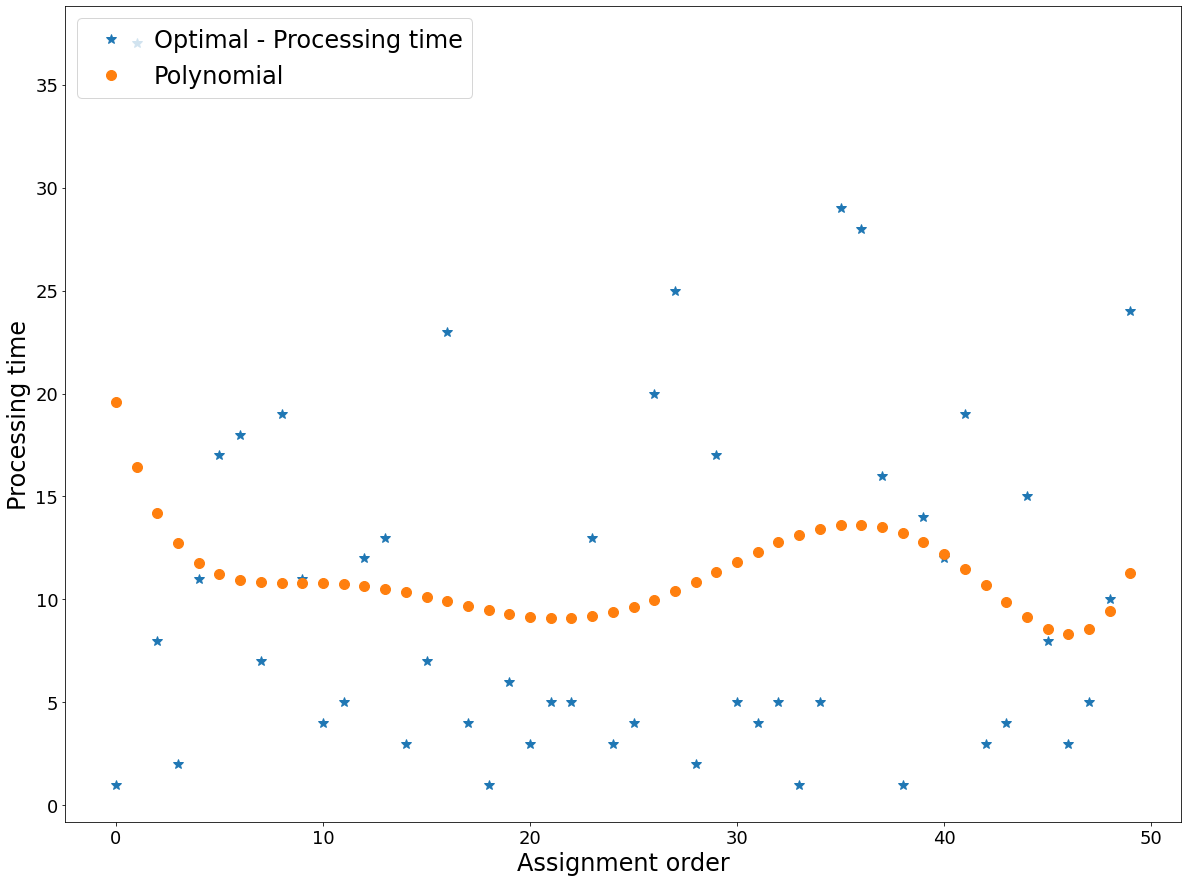

Min-Min makespan: 107
process: [1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 4, 2, 2, 5, 6, 3, 4, 5, 5, 7, 6, 6, 11, 8, 9, 7, 7, 13, 7, 9, 9, 13, 9, 13, 18, 27, 16, 19, 15, 27, 25, 28, 19, 29, 32, 27, 19, 51, 60]

HASA makespan: 110
process: [5, 6, 6, 7, 8, 1, 6, 2, 9, 1, 1, 4, 1, 10, 1, 6, 2, 2, 3, 2, 1, 4, 7, 11, 4, 2, 7, 5, 9, 7, 13, 11, 9, 13, 18, 16, 13, 25, 27, 15, 27, 28, 19, 19, 32, 27, 29, 19, 51, 26]

Optimal makespan: 75
process: [12, 18, 6, 5, 6, 4, 8, 13, 23, 9, 33, 19, 9, 5, 1, 19, 26, 4, 22, 2, 1, 25, 6, 27, 6, 1, 2, 28, 18, 19, 4, 16, 12, 2, 27, 9, 32, 29, 3, 7, 2, 1, 28, 1, 11, 9, 1, 1, 2, 13]

Poly makespan: 103
process: [19, 16, 14, 13, 12, 9, 1, 9, 2, 1, 12, 1, 2, 5, 4, 2, 2, 2, 1, 1, 7, 3, 4, 6, 5, 5, 5, 6, 7, 11, 6, 9, 7, 18, 18, 13, 9, 13, 27, 25, 15, 19, 27, 32, 28, 19, 29, 27, 60, 26]





/tmp/ipykernel_395369/2015407290.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


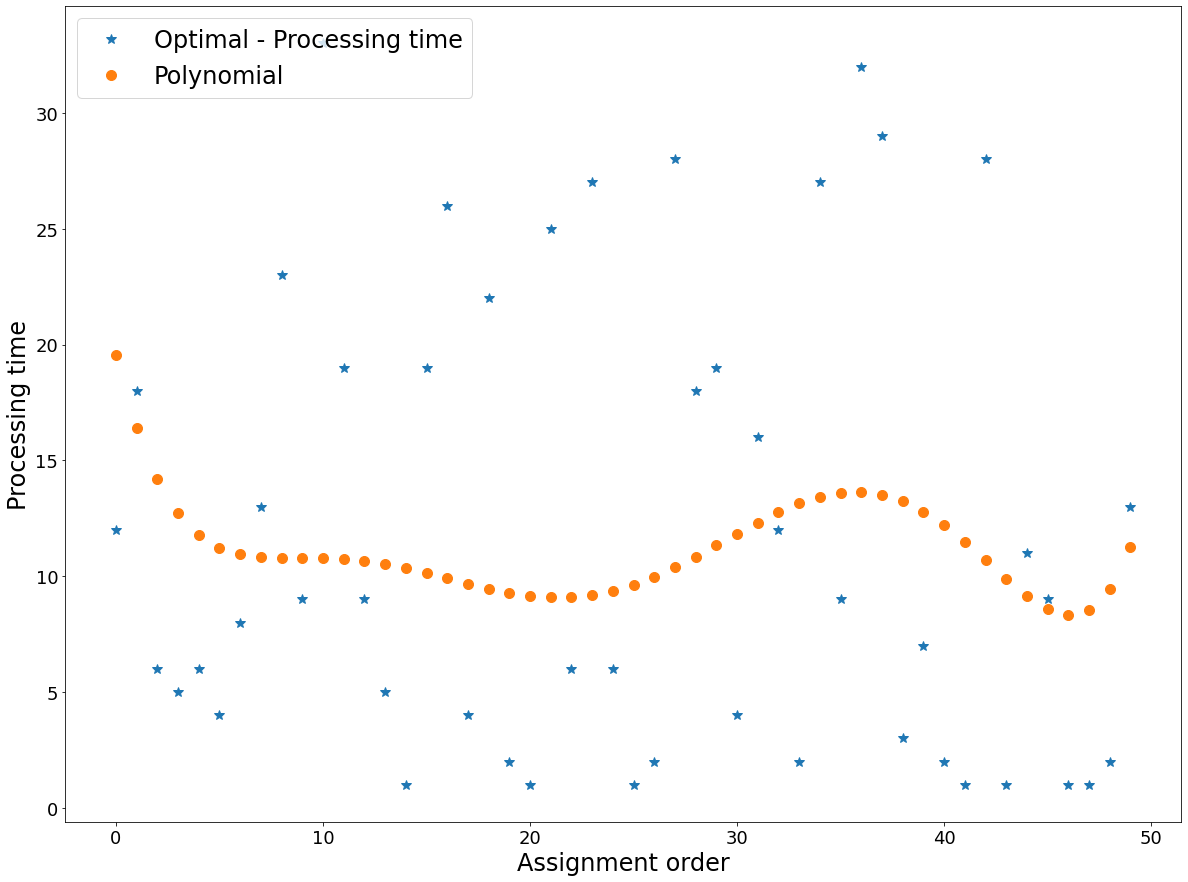

Min-Min makespan: 78
process: [1, 1, 1, 1, 2, 1, 2, 3, 3, 3, 5, 6, 3, 8, 5, 6, 4, 5, 9, 5, 5, 6, 5, 7, 10, 12, 9, 9, 8, 10, 9, 15, 13, 12, 10, 11, 18, 26, 23, 14, 14, 16, 20, 17, 30, 22, 30, 28, 19, 29]

HASA makespan: 78
process: [5, 6, 6, 6, 1, 7, 7, 3, 8, 9, 2, 1, 3, 5, 1, 1, 3, 6, 2, 1, 5, 4, 5, 10, 9, 12, 9, 8, 10, 9, 9, 15, 13, 10, 12, 11, 18, 26, 14, 16, 23, 14, 20, 17, 30, 30, 22, 19, 28, 29]

Optimal makespan: 72
process: [30, 13, 12, 3, 9, 9, 30, 15, 7, 8, 15, 1, 5, 12, 9, 2, 5, 7, 3, 23, 6, 10, 11, 14, 2, 6, 9, 6, 4, 6, 28, 16, 26, 7, 22, 10, 5, 20, 19, 26, 9, 1, 10, 29, 22, 1, 8, 17, 3, 1]

Poly makespan: 81
process: [19, 16, 14, 13, 12, 11, 10, 1, 1, 9, 1, 1, 2, 3, 2, 1, 3, 3, 5, 3, 6, 9, 4, 5, 5, 5, 8, 5, 6, 5, 10, 9, 9, 12, 10, 18, 14, 9, 15, 13, 10, 17, 23, 15, 30, 30, 19, 22, 29, 37]





/tmp/ipykernel_395369/2015407290.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


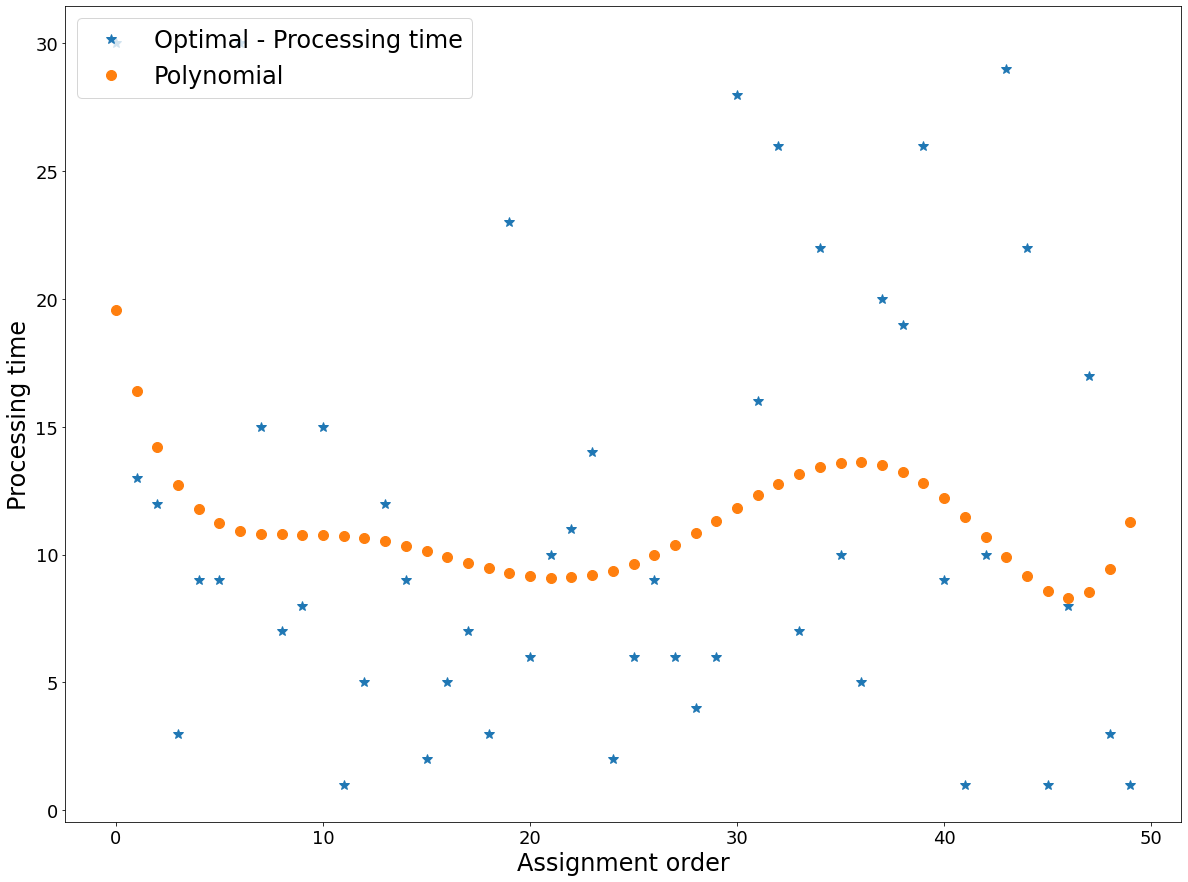

Min-Min makespan: 97
process: [1, 1, 1, 1, 1, 3, 3, 3, 2, 2, 5, 5, 5, 3, 3, 4, 5, 4, 5, 6, 6, 5, 6, 11, 4, 8, 7, 8, 6, 9, 13, 9, 13, 8, 17, 11, 11, 9, 14, 21, 18, 19, 17, 12, 18, 22, 19, 18, 23, 31]

HASA makespan: 97
process: [4, 5, 5, 1, 6, 1, 6, 1, 3, 1, 8, 1, 2, 2, 11, 3, 5, 6, 3, 4, 15, 4, 5, 8, 7, 4, 6, 9, 11, 11, 5, 9, 8, 11, 13, 13, 9, 17, 18, 14, 21, 18, 17, 12, 19, 17, 18, 22, 23, 31]

Optimal makespan: 62
process: [18, 2, 16, 31, 5, 27, 3, 12, 18, 1, 10, 4, 11, 8, 3, 9, 11, 5, 6, 3, 1, 3, 3, 17, 1, 3, 7, 19, 11, 17, 9, 14, 19, 6, 5, 4, 8, 6, 1, 13, 22, 4, 1, 21, 2, 18, 25, 5, 16, 5]

Poly makespan: 74
process: [19, 16, 13, 12, 11, 1, 10, 1, 1, 9, 2, 1, 1, 2, 7, 3, 4, 3, 3, 3, 5, 3, 5, 5, 5, 4, 6, 6, 5, 5, 11, 8, 7, 6, 8, 8, 9, 13, 11, 21, 9, 22, 18, 14, 25, 18, 21, 22, 18, 31]





/tmp/ipykernel_395369/2015407290.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


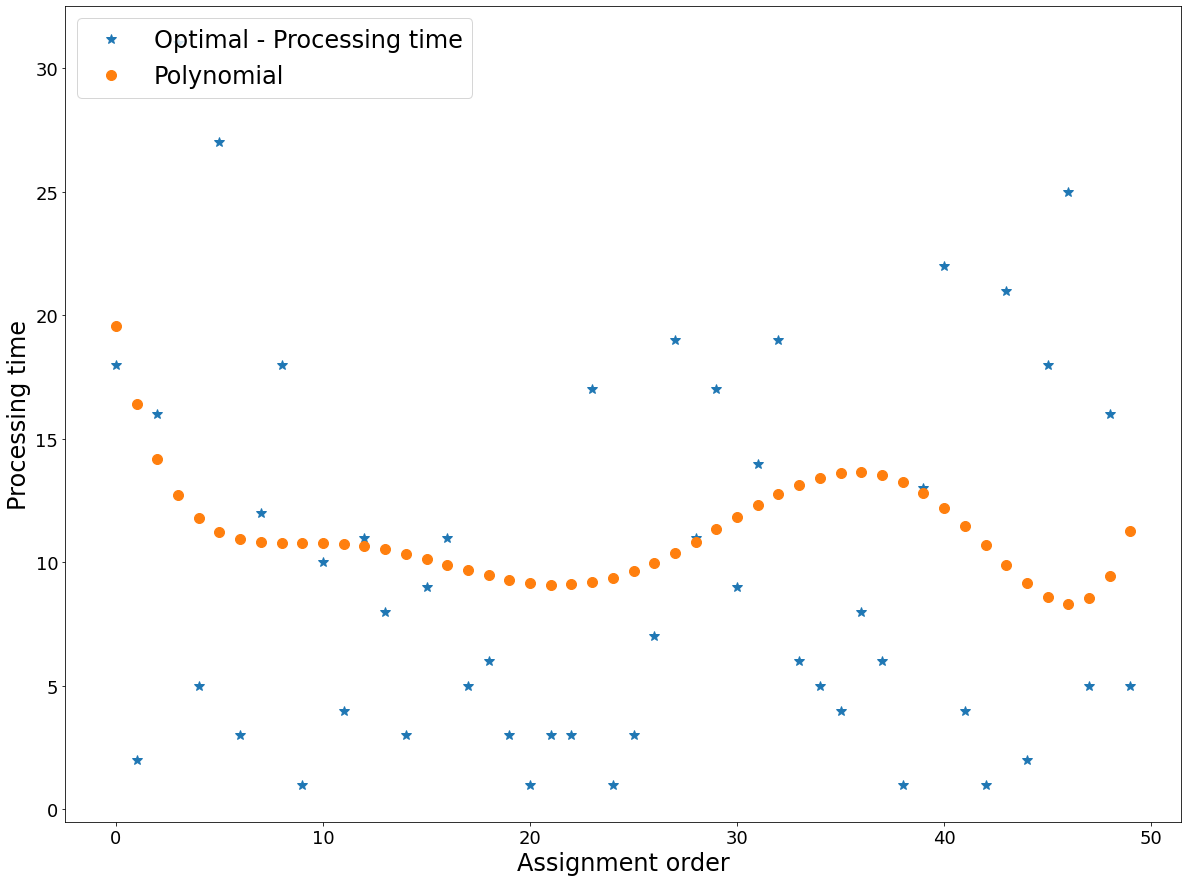

2
dataset: ./all_data/100x10/100x10-1.csv
dataset: ./all_data/100x10/100x10-2.csv
dataset: ./all_data/100x10/100x10-3.csv
dataset: ./all_data/100x10/100x10-4.csv
dataset: ./all_data/100x10/100x10-5.csv
Min-Min makespan: 128
process: [1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 4, 2, 4, 5, 4, 3, 3, 5, 3, 5, 5, 4, 4, 4, 5, 5, 4, 6, 8, 5, 6, 5, 6, 8, 4, 7, 6, 5, 8, 7, 13, 11, 10, 9, 8, 12, 9, 7, 9, 10, 12, 12, 12, 8, 9, 15, 13, 10, 10, 18, 13, 12, 12, 11, 14, 11, 17, 18, 21, 12, 14, 18, 16, 16, 18, 31, 26, 13, 19, 26, 19, 27, 20, 19, 19, 27, 31, 27, 43, 36, 30, 34, 37]

HASA makespan: 130
process: [5, 5, 6, 6, 6, 1, 2, 1, 1, 8, 8, 8, 2, 1, 1, 2, 2, 2, 1, 1, 5, 4, 1, 1, 12, 2, 13, 4, 2, 4, 1, 6, 5, 4, 4, 5, 2, 4, 7, 4, 3, 7, 5, 6, 4, 8, 5, 5, 10, 9, 8, 7, 5, 9, 10, 11, 9, 8, 12, 12, 9, 15, 13, 10, 10, 12, 18, 14, 12, 12, 11, 17, 11, 18, 13, 21, 16, 12, 18, 16, 14, 18, 31, 26, 13, 26, 19, 27, 23, 20, 19, 19, 31, 36, 35, 27, 30, 34, 37, 42]

Optimal makespan: 113
process: [4, 6, 8, 43

/tmp/ipykernel_395369/2015407290.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


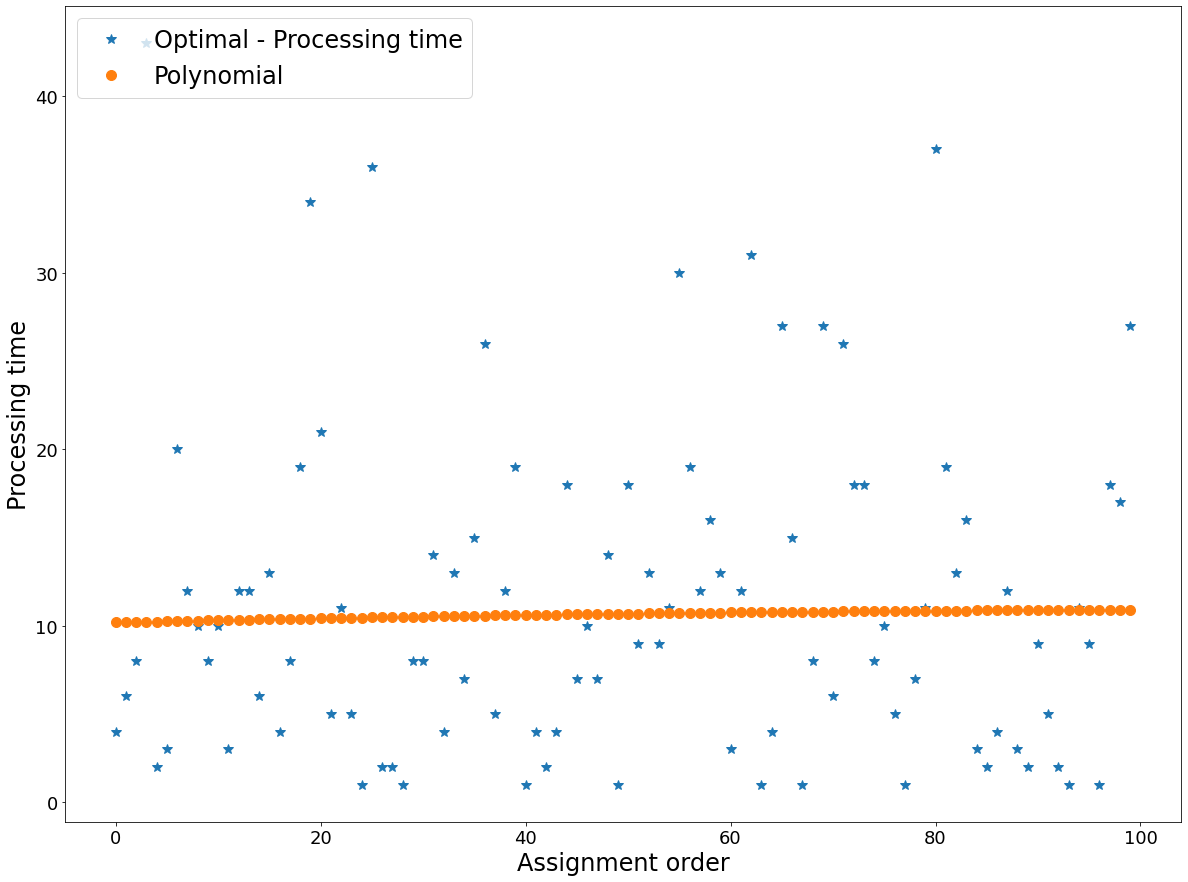

Min-Min makespan: 140
process: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 3, 3, 5, 3, 3, 3, 3, 5, 4, 3, 7, 4, 4, 4, 5, 3, 5, 8, 6, 8, 3, 4, 5, 8, 8, 6, 6, 8, 7, 7, 8, 8, 9, 7, 10, 10, 6, 8, 9, 11, 7, 10, 6, 11, 15, 11, 7, 16, 10, 12, 13, 13, 14, 13, 16, 11, 16, 13, 17, 19, 16, 19, 13, 21, 19, 14, 17, 17, 30, 22, 17, 23, 23, 20, 32, 21, 18, 20, 21, 52, 37, 38, 32, 35, 37, 34]

HASA makespan: 144
process: [6, 6, 6, 6, 1, 7, 7, 1, 8, 1, 8, 1, 3, 9, 1, 3, 1, 1, 3, 5, 11, 3, 1, 1, 3, 7, 5, 3, 3, 4, 3, 3, 5, 4, 3, 4, 4, 3, 5, 7, 6, 8, 8, 4, 8, 5, 8, 6, 7, 7, 8, 9, 10, 8, 6, 10, 11, 10, 15, 7, 10, 12, 13, 11, 14, 14, 16, 11, 16, 16, 13, 13, 19, 19, 13, 16, 17, 21, 14, 17, 22, 17, 19, 17, 17, 23, 32, 20, 35, 18, 23, 32, 21, 52, 35, 34, 32, 37, 37, 38]

Optimal makespan: 118
process: [18, 13, 17, 17, 12, 3, 1, 3, 8, 1, 10, 22, 1, 1, 20, 16, 7, 8, 3, 4, 6, 14, 8, 3, 1, 6, 23, 3, 16, 19, 9, 5, 23, 28, 13, 1, 10, 11, 8, 3, 8, 1, 3, 16, 19, 3, 7, 15, 32, 13, 13, 7, 9, 19, 7, 6, 37, 5, 7, 35, 16, 1,

/tmp/ipykernel_395369/2015407290.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


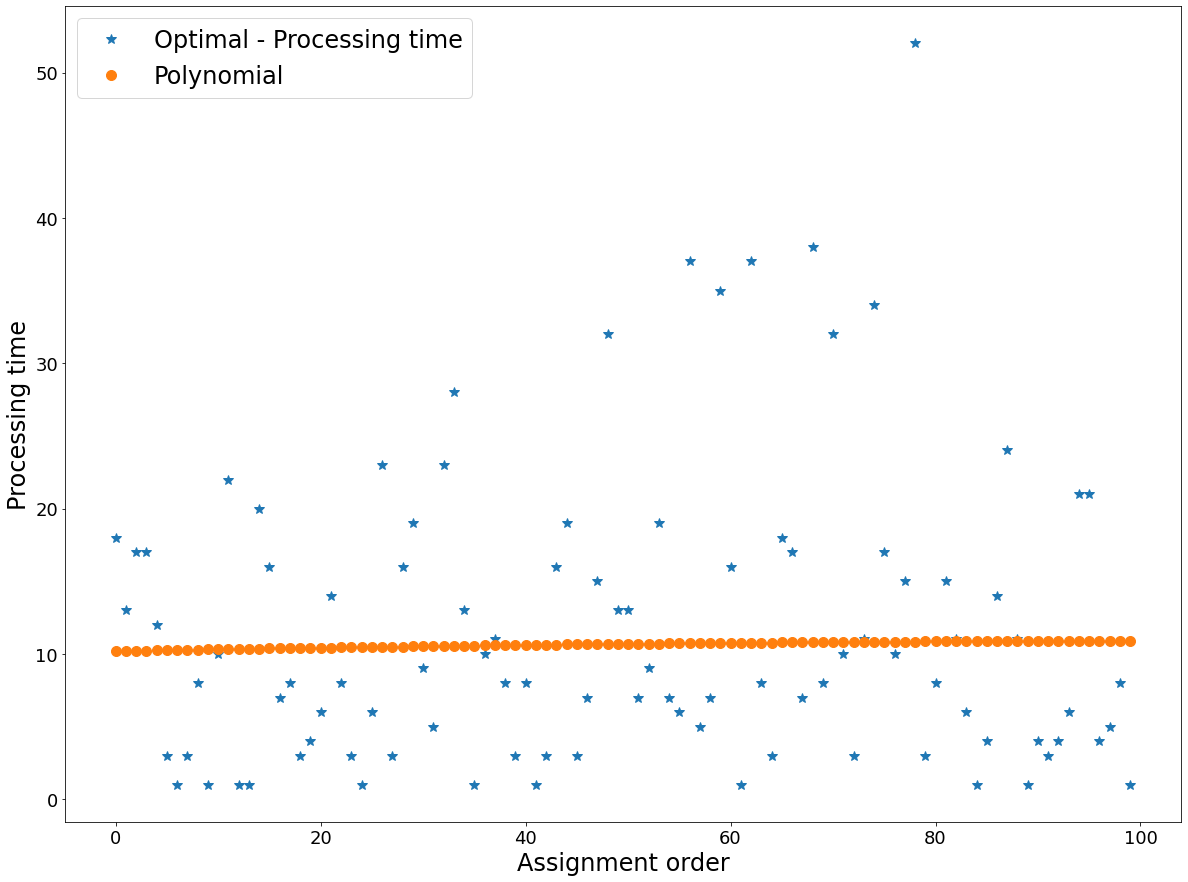

Min-Min makespan: 122
process: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 2, 3, 2, 2, 3, 2, 3, 3, 2, 2, 2, 2, 2, 3, 4, 4, 2, 3, 3, 4, 4, 3, 3, 4, 5, 5, 3, 4, 4, 8, 12, 5, 8, 4, 9, 8, 10, 6, 5, 4, 7, 9, 12, 9, 7, 9, 7, 11, 14, 7, 14, 8, 7, 10, 13, 14, 12, 18, 8, 14, 16, 13, 11, 19, 15, 13, 18, 15, 13, 20, 22, 19, 14, 23, 16, 22, 26, 22, 29, 21, 33, 37, 38, 34, 43, 37, 46]

HASA makespan: 128
process: [5, 5, 5, 6, 1, 5, 6, 7, 2, 1, 2, 1, 2, 2, 8, 1, 9, 4, 3, 3, 1, 2, 2, 2, 1, 3, 12, 1, 2, 2, 1, 2, 4, 3, 1, 4, 2, 3, 2, 4, 4, 8, 1, 4, 3, 3, 4, 5, 3, 8, 7, 4, 7, 9, 7, 12, 12, 9, 14, 9, 8, 7, 7, 10, 9, 12, 13, 8, 8, 14, 16, 11, 14, 18, 14, 13, 13, 20, 18, 13, 19, 15, 19, 15, 14, 22, 23, 16, 22, 21, 26, 22, 29, 33, 37, 43, 38, 34, 46, 41]

Optimal makespan: 105
process: [33, 4, 1, 3, 21, 1, 19, 5, 1, 3, 3, 2, 1, 15, 38, 3, 11, 2, 1, 2, 37, 2, 14, 9, 10, 7, 23, 20, 15, 9, 15, 16, 3, 7, 22, 4, 1, 13, 7, 12, 4, 11, 26, 3, 13, 4, 6, 4, 3, 1, 1, 9, 4, 4, 5, 10, 14, 7, 2, 30, 10, 8, 18, 5, 8, 9, 2, 3,

/tmp/ipykernel_395369/2015407290.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


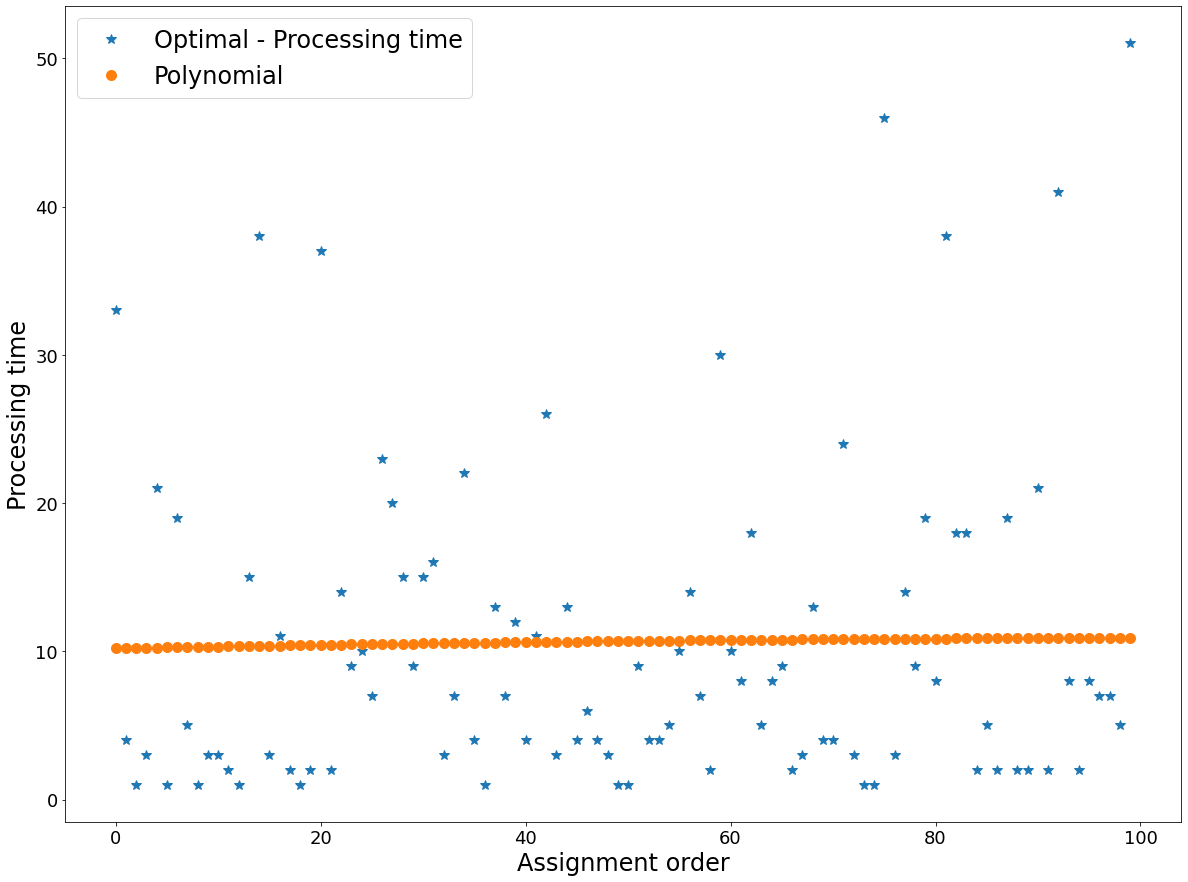

Min-Min makespan: 116
process: [1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 3, 3, 4, 3, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 4, 5, 5, 6, 6, 4, 6, 5, 8, 6, 6, 5, 6, 7, 5, 5, 7, 7, 6, 6, 7, 6, 5, 11, 8, 6, 9, 6, 8, 13, 13, 9, 8, 7, 7, 9, 8, 14, 11, 9, 9, 13, 9, 14, 12, 12, 12, 9, 14, 15, 16, 14, 21, 13, 12, 19, 16, 14, 20, 16, 24, 23, 17, 23, 29, 18, 15, 27, 18, 27, 32, 27, 35, 43]

HASA makespan: 124
process: [5, 5, 5, 6, 6, 6, 7, 1, 7, 7, 1, 1, 1, 3, 2, 3, 3, 1, 3, 1, 1, 2, 10, 1, 4, 1, 2, 3, 3, 3, 3, 3, 5, 4, 6, 5, 4, 6, 8, 6, 4, 7, 6, 5, 6, 6, 5, 13, 7, 7, 5, 11, 6, 7, 9, 9, 8, 8, 8, 7, 13, 13, 9, 8, 12, 11, 9, 14, 9, 9, 14, 14, 12, 12, 9, 14, 13, 15, 16, 21, 12, 16, 14, 19, 16, 20, 24, 23, 17, 23, 15, 18, 29, 27, 18, 20, 32, 40, 27, 47]

Optimal makespan: 101
process: [12, 6, 5, 4, 7, 43, 25, 23, 11, 14, 6, 21, 13, 9, 6, 4, 7, 8, 3, 29, 5, 13, 1, 1, 1, 15, 5, 10, 9, 6, 7, 1, 1, 1, 24, 4, 3, 21, 32, 4, 3, 5, 3, 2, 17, 2, 14, 8, 3, 18, 18, 27, 19, 8, 5, 11, 7, 6, 7, 14, 12, 20, 9, 28, 16, 6, 7, 4, 3

/tmp/ipykernel_395369/2015407290.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


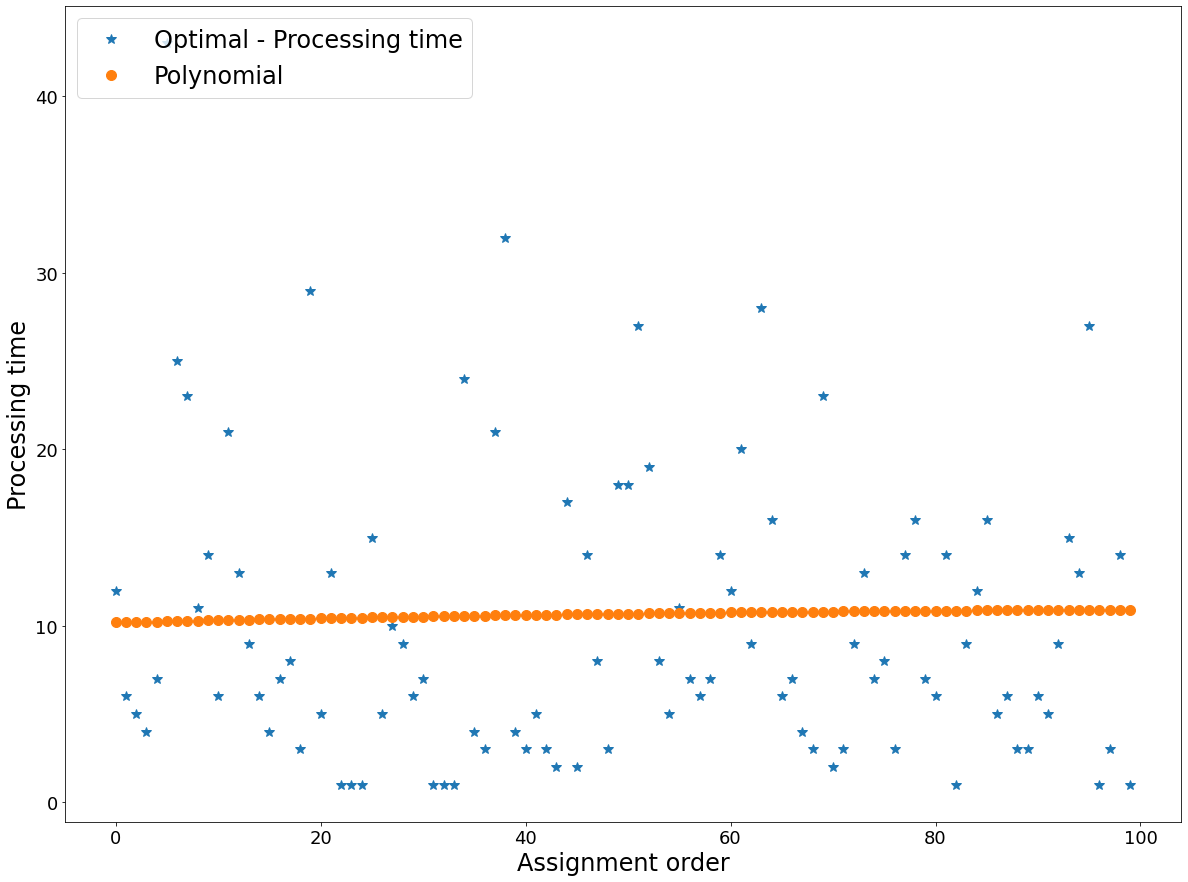

Min-Min makespan: 129
process: [1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 3, 2, 3, 3, 3, 2, 2, 2, 4, 2, 3, 3, 2, 2, 3, 4, 4, 3, 5, 5, 3, 4, 4, 4, 4, 4, 5, 4, 4, 6, 6, 7, 6, 7, 7, 4, 5, 6, 8, 7, 8, 5, 8, 6, 9, 8, 12, 11, 11, 8, 11, 11, 9, 13, 12, 16, 13, 9, 11, 15, 11, 15, 13, 13, 11, 14, 16, 20, 13, 17, 19, 14, 14, 13, 17, 20, 17, 20, 19, 14, 16, 15, 37, 18, 18, 29, 40, 28, 38, 53]

HASA makespan: 132
process: [5, 5, 5, 5, 1, 1, 6, 6, 2, 7, 7, 1, 2, 1, 2, 2, 3, 9, 4, 1, 3, 10, 1, 2, 2, 2, 3, 2, 3, 3, 3, 4, 4, 2, 6, 6, 4, 4, 6, 4, 4, 4, 4, 4, 4, 6, 7, 4, 8, 9, 7, 6, 8, 5, 8, 11, 8, 8, 11, 11, 12, 12, 13, 11, 9, 9, 16, 15, 11, 15, 13, 13, 11, 13, 11, 12, 20, 16, 17, 14, 17, 13, 14, 18, 17, 14, 19, 20, 20, 15, 16, 37, 19, 18, 29, 18, 28, 38, 46, 53]

Optimal makespan: 100
process: [24, 42, 2, 22, 14, 1, 5, 5, 8, 4, 13, 2, 11, 6, 8, 8, 18, 3, 3, 11, 19, 1, 15, 10, 1, 8, 3, 2, 3, 4, 4, 4, 7, 7, 4, 12, 20, 6, 4, 7, 14, 18, 17, 7, 17, 6, 3, 9, 5, 3, 3, 13, 40, 10, 18, 12, 2, 12, 15, 28, 11, 3, 16, 38, 9,

/tmp/ipykernel_395369/2015407290.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


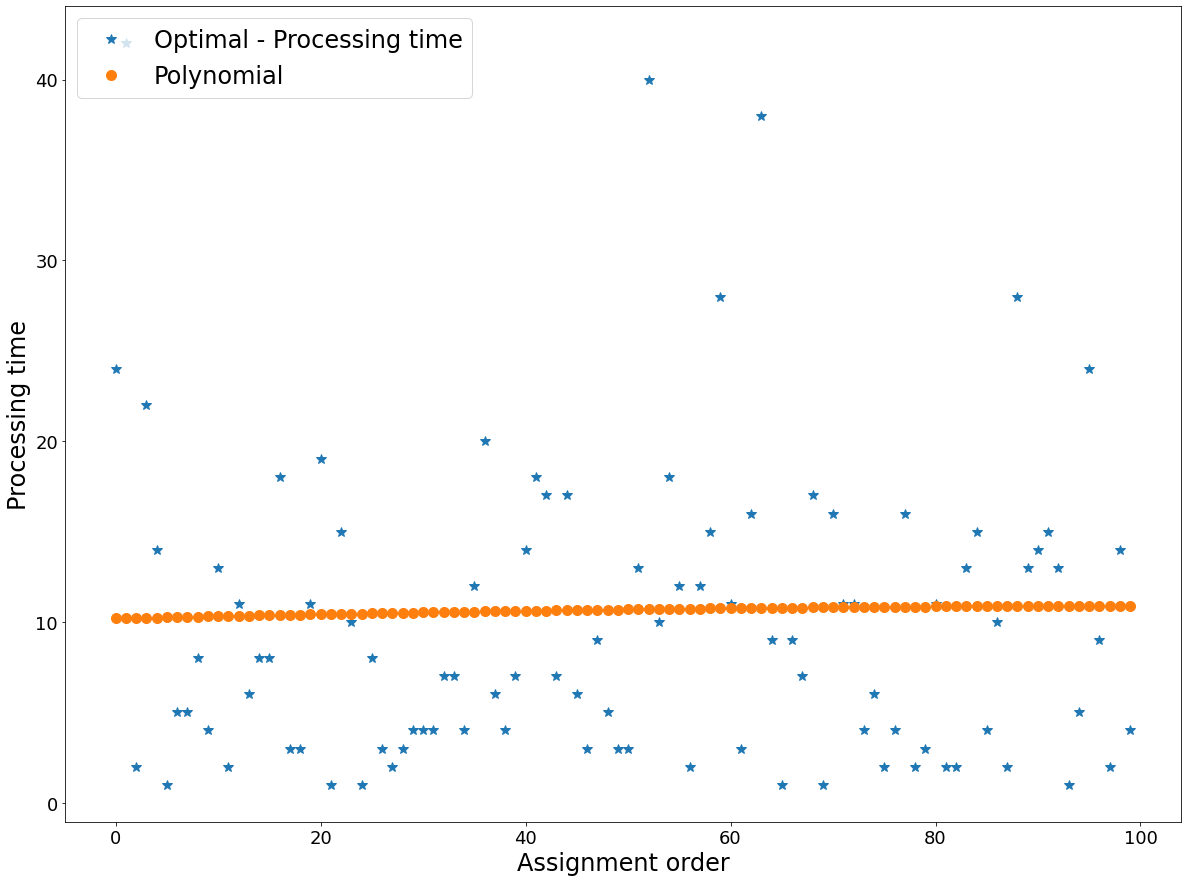

In [275]:
# import all datasets.

cases = ['2x50', '4x50', '5x20', '5x40', '5x80', '8x50', '100x10']

filenames_list = []
tests_list = []
results_list = []
test_results_list = []

for case in cases:
    path = './all_data/' + case
    filenames = glob.glob(path + "/*.csv")
    tests = []
    for filename in filenames:
        if filename[0] != 't':
            tests.append(filename)
    filenames.sort()
    tests.sort()
    
    filenames_list.append(filenames)
    tests_list.append(tests)

    path = './results/' + case
    results = glob.glob(path + "/*.csv")
    tests = []
    for result in results:
        if result[0] != 't':
            tests.append(result)
    results.sort()
    tests.sort()
    
    results_list.append(results)
    test_results_list.append(tests)


if __name__ == '__main__':
    polynomial_job_shop_main_optimal(filenames_list, results_list)

12
dataset: ./all_data/2x50/2x50-1.csv
dataset: ./all_data/2x50/2x50-2.csv
dataset: ./all_data/2x50/2x50-3.csv
dataset: ./all_data/2x50/2x50-4.csv
dataset: ./all_data/2x50/2x50-5.csv
Min-Min makespan: 909
process: [1, 2, 3, 4, 8, 4, 5, 10, 9, 11, 10, 14, 15, 18, 19, 21, 20, 22, 20, 22, 22, 24, 23, 28, 28, 30, 29, 33, 34, 37, 37, 40, 43, 45, 58, 46, 65, 52, 68, 53, 56, 69, 67, 75, 73, 77, 78, 81, 80, 91]

HASA makespan: 909
process: [18, 3, 22, 8, 9, 2, 1, 4, 10, 4, 5, 11, 10, 14, 15, 21, 19, 22, 20, 22, 20, 24, 23, 28, 28, 30, 29, 33, 34, 37, 37, 40, 43, 45, 58, 46, 65, 52, 68, 53, 56, 69, 67, 75, 73, 77, 78, 81, 80, 91]

Optimal makespan: 884
process: [56, 33, 20, 21, 24, 23, 2, 33, 10, 5, 19, 65, 37, 45, 22, 52, 1, 81, 79, 75, 29, 8, 28, 73, 9, 80, 22, 11, 15, 3, 53, 10, 18, 13, 4, 4, 34, 22, 20, 40, 77, 43, 58, 65, 28, 77, 37, 81, 56, 46]

Poly makespan: 909
process: [30, 29, 1, 2, 3, 4, 4, 8, 5, 10, 9, 11, 10, 14, 15, 18, 19, 21, 20, 22, 20, 22, 22, 24, 23, 28, 28, 33, 34, 37, 37, 

/tmp/ipykernel_395369/3150712127.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


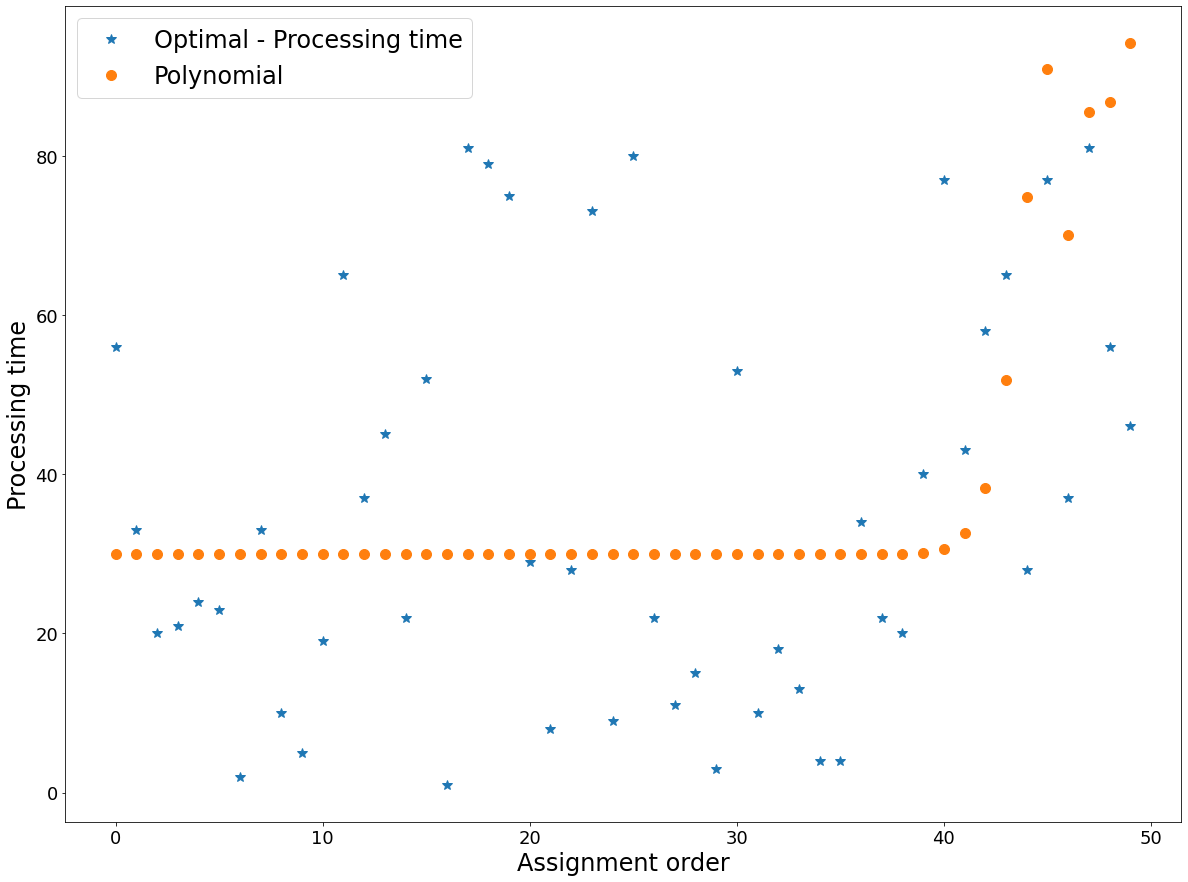

Min-Min makespan: 967
process: [1, 3, 2, 3, 3, 6, 9, 7, 7, 18, 8, 14, 23, 20, 24, 21, 25, 31, 25, 34, 25, 28, 38, 28, 40, 29, 41, 33, 38, 52, 38, 54, 41, 55, 46, 46, 57, 48, 57, 51, 74, 54, 77, 73, 80, 77, 80, 82, 84, 100]

HASA makespan: 967
process: [18, 3, 21, 9, 14, 1, 2, 3, 3, 6, 7, 23, 7, 8, 24, 20, 25, 31, 25, 34, 25, 28, 38, 28, 40, 29, 41, 33, 38, 52, 38, 54, 41, 55, 46, 46, 57, 48, 57, 51, 74, 54, 77, 73, 80, 77, 80, 82, 84, 100]

Optimal makespan: 951
process: [20, 28, 38, 7, 54, 41, 23, 88, 31, 74, 28, 54, 24, 55, 3, 46, 48, 25, 9, 1, 51, 73, 38, 14, 38, 57, 46, 8, 57, 52, 29, 40, 34, 84, 25, 3, 6, 77, 41, 82, 21, 25, 3, 18, 80, 82, 2, 77, 33, 7]

Poly makespan: 967
process: [29, 31, 3, 1, 2, 3, 3, 6, 9, 7, 7, 18, 8, 14, 23, 20, 24, 21, 25, 34, 25, 25, 38, 28, 40, 28, 41, 33, 38, 52, 38, 54, 41, 55, 46, 46, 57, 48, 57, 51, 74, 54, 77, 73, 80, 77, 80, 82, 84, 100]





/tmp/ipykernel_395369/3150712127.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


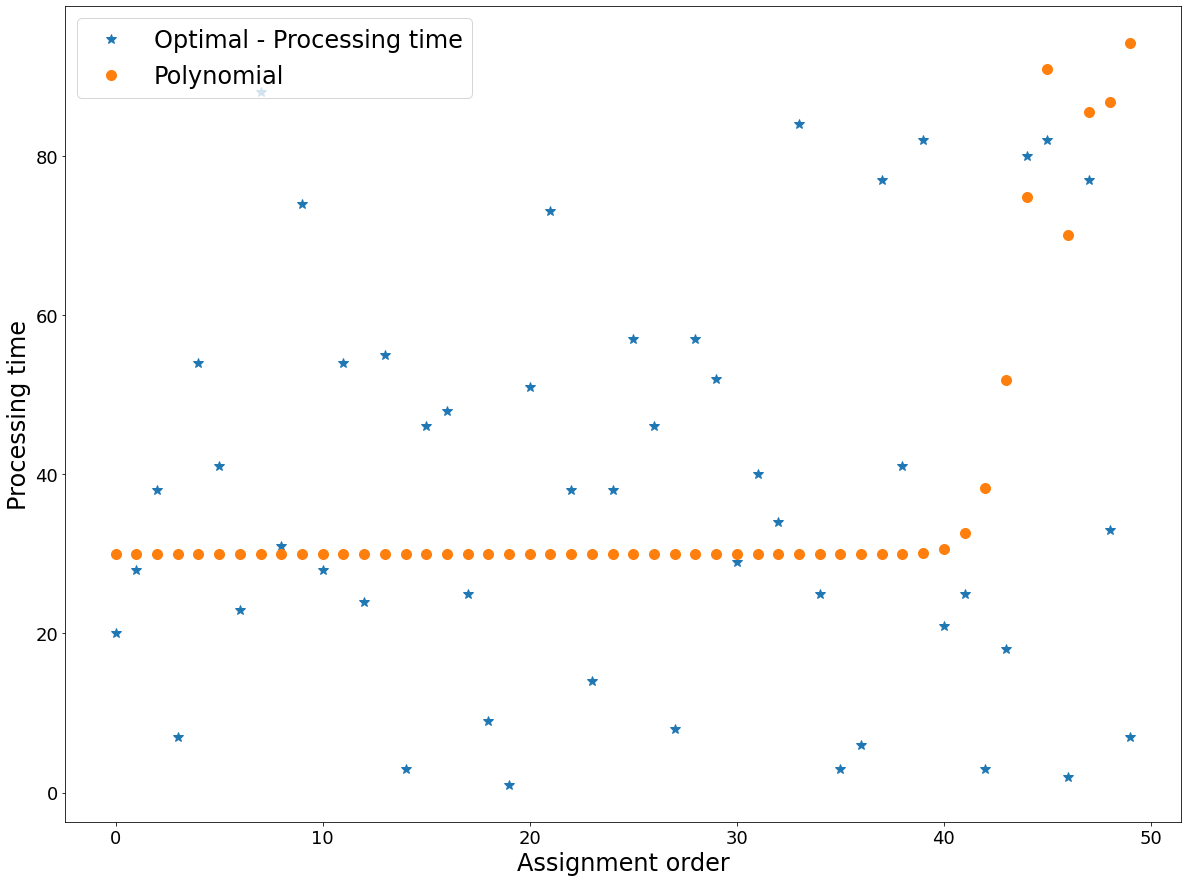

Min-Min makespan: 977
process: [1, 2, 4, 5, 4, 6, 7, 8, 8, 10, 17, 17, 21, 22, 23, 24, 25, 25, 28, 29, 34, 34, 34, 37, 35, 38, 37, 38, 39, 39, 41, 46, 47, 48, 47, 52, 50, 55, 55, 60, 57, 60, 65, 66, 65, 74, 80, 85, 83, 96]

HASA makespan: 977
process: [17, 22, 6, 4, 4, 21, 1, 2, 8, 5, 7, 10, 8, 17, 23, 24, 25, 25, 28, 29, 34, 34, 34, 37, 35, 38, 37, 38, 39, 39, 41, 46, 47, 48, 47, 52, 50, 55, 55, 60, 57, 60, 65, 66, 65, 74, 80, 85, 83, 96]

Optimal makespan: 944
process: [37, 41, 60, 4, 38, 47, 17, 55, 37, 24, 53, 55, 29, 39, 47, 6, 34, 2, 25, 22, 57, 52, 46, 21, 39, 34, 7, 25, 60, 35, 5, 91, 10, 28, 65, 23, 17, 48, 80, 1, 4, 81, 34, 38, 74, 90, 8, 66, 65, 8]

Poly makespan: 974
process: [29, 30, 1, 4, 2, 4, 5, 6, 7, 8, 8, 10, 17, 17, 21, 24, 23, 25, 25, 34, 28, 37, 34, 34, 38, 35, 38, 37, 39, 39, 46, 41, 48, 47, 52, 47, 53, 55, 55, 57, 60, 65, 60, 65, 66, 80, 74, 81, 91, 90]





/tmp/ipykernel_395369/3150712127.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


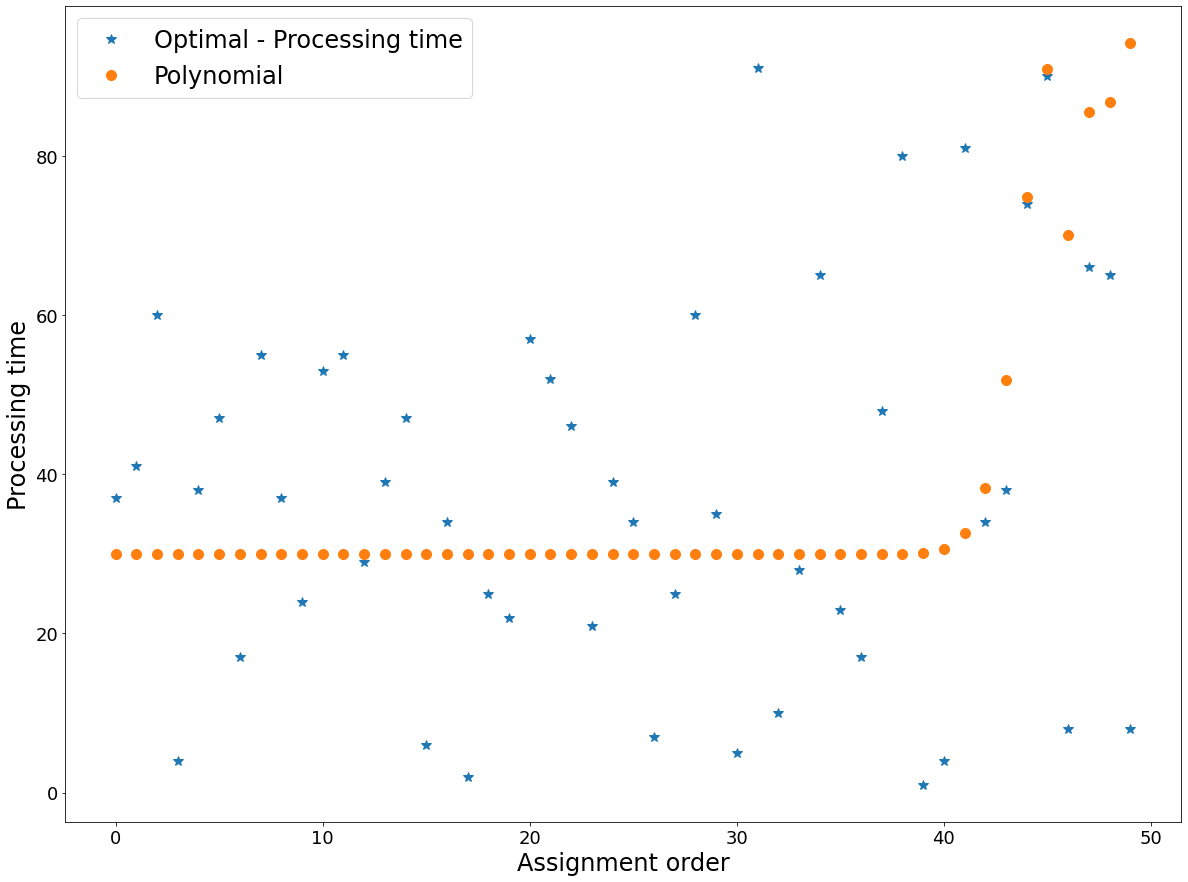

Min-Min makespan: 986
process: [2, 4, 3, 5, 6, 11, 7, 11, 11, 13, 13, 14, 17, 17, 19, 19, 20, 22, 21, 22, 28, 35, 34, 36, 35, 38, 35, 41, 54, 41, 55, 44, 56, 51, 55, 57, 56, 58, 56, 60, 68, 61, 63, 75, 74, 75, 76, 90, 96, 91]

HASA makespan: 1011
process: [19, 5, 25, 7, 4, 11, 3, 2, 6, 11, 11, 13, 17, 14, 20, 17, 21, 19, 22, 28, 22, 34, 35, 35, 36, 35, 38, 54, 41, 41, 55, 44, 56, 51, 57, 55, 58, 56, 60, 56, 61, 68, 63, 75, 74, 75, 76, 90, 96, 91]

Optimal makespan: 982
process: [63, 90, 3, 19, 58, 2, 54, 19, 32, 41, 11, 38, 35, 11, 7, 44, 55, 81, 35, 17, 74, 56, 57, 35, 75, 90, 60, 51, 4, 5, 56, 21, 56, 36, 20, 13, 22, 68, 41, 55, 13, 28, 61, 11, 34, 6, 17, 14, 91, 76]

Poly makespan: 1016
process: [28, 30, 2, 5, 3, 6, 11, 7, 11, 11, 13, 13, 14, 17, 17, 19, 19, 20, 22, 21, 22, 34, 35, 35, 36, 35, 38, 54, 41, 41, 55, 44, 56, 51, 57, 55, 58, 56, 60, 56, 61, 68, 63, 75, 74, 75, 76, 90, 96, 91]





/tmp/ipykernel_395369/3150712127.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


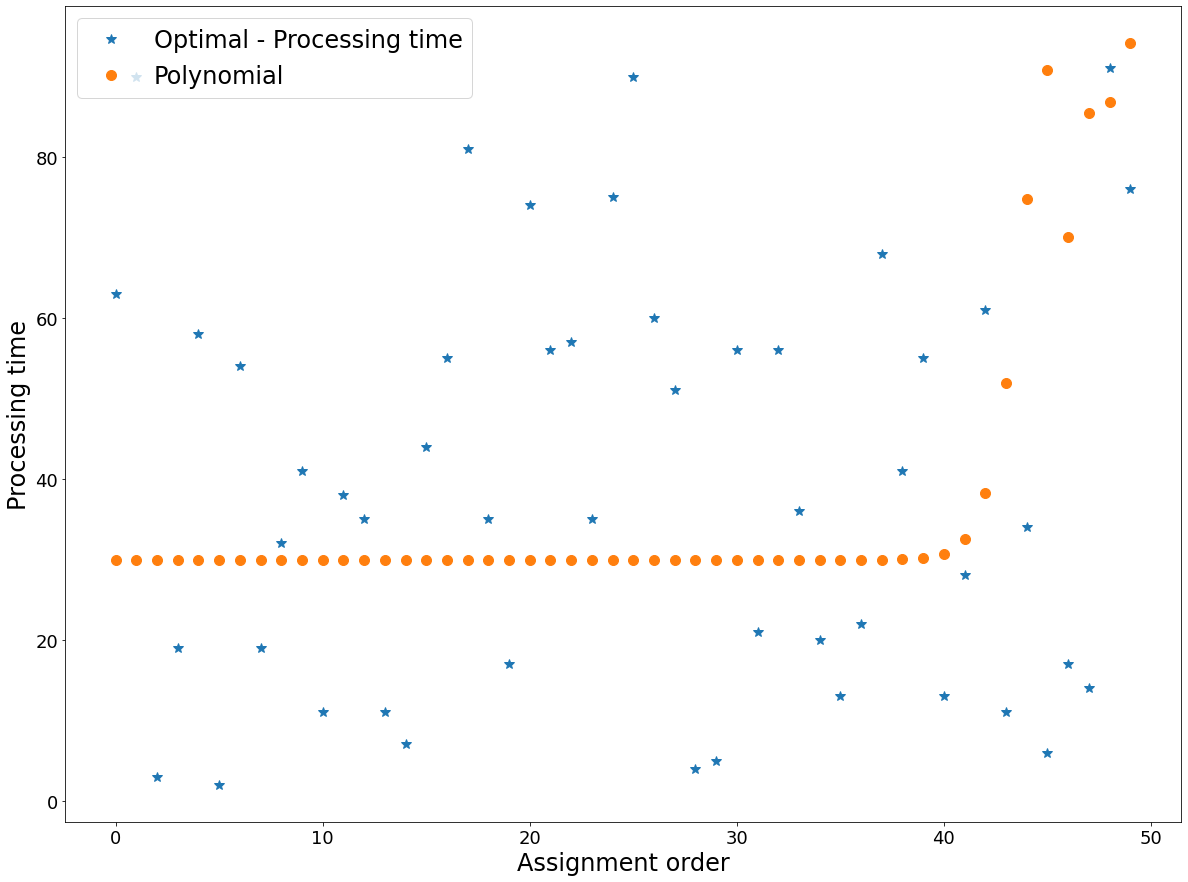

Min-Min makespan: 895
process: [1, 2, 2, 6, 3, 4, 5, 10, 6, 11, 7, 7, 8, 17, 13, 24, 15, 17, 26, 17, 18, 33, 19, 33, 23, 26, 36, 33, 37, 37, 39, 39, 50, 39, 51, 45, 49, 68, 50, 69, 50, 74, 57, 67, 75, 71, 87, 72, 90, 94]

HASA makespan: 898
process: [17, 19, 8, 2, 2, 11, 6, 1, 5, 3, 6, 10, 7, 7, 7, 24, 13, 15, 26, 17, 33, 17, 18, 33, 23, 26, 36, 33, 37, 37, 39, 39, 50, 39, 51, 45, 61, 50, 50, 68, 57, 69, 67, 74, 71, 75, 72, 87, 94, 90]

Optimal makespan: 858
process: [76, 17, 74, 33, 57, 4, 39, 33, 2, 23, 39, 6, 7, 53, 19, 26, 67, 36, 75, 93, 7, 37, 13, 17, 1, 7, 50, 18, 49, 15, 87, 39, 90, 26, 5, 6, 50, 3, 45, 2, 50, 8, 33, 68, 51, 17, 72, 37, 24, 10]

Poly makespan: 881
process: [33, 33, 1, 2, 2, 6, 3, 4, 5, 10, 6, 11, 7, 7, 8, 24, 13, 15, 26, 17, 17, 33, 18, 19, 36, 23, 37, 26, 39, 33, 37, 50, 39, 51, 39, 61, 45, 50, 68, 50, 69, 57, 74, 67, 75, 71, 72, 87, 94, 90]





/tmp/ipykernel_395369/3150712127.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


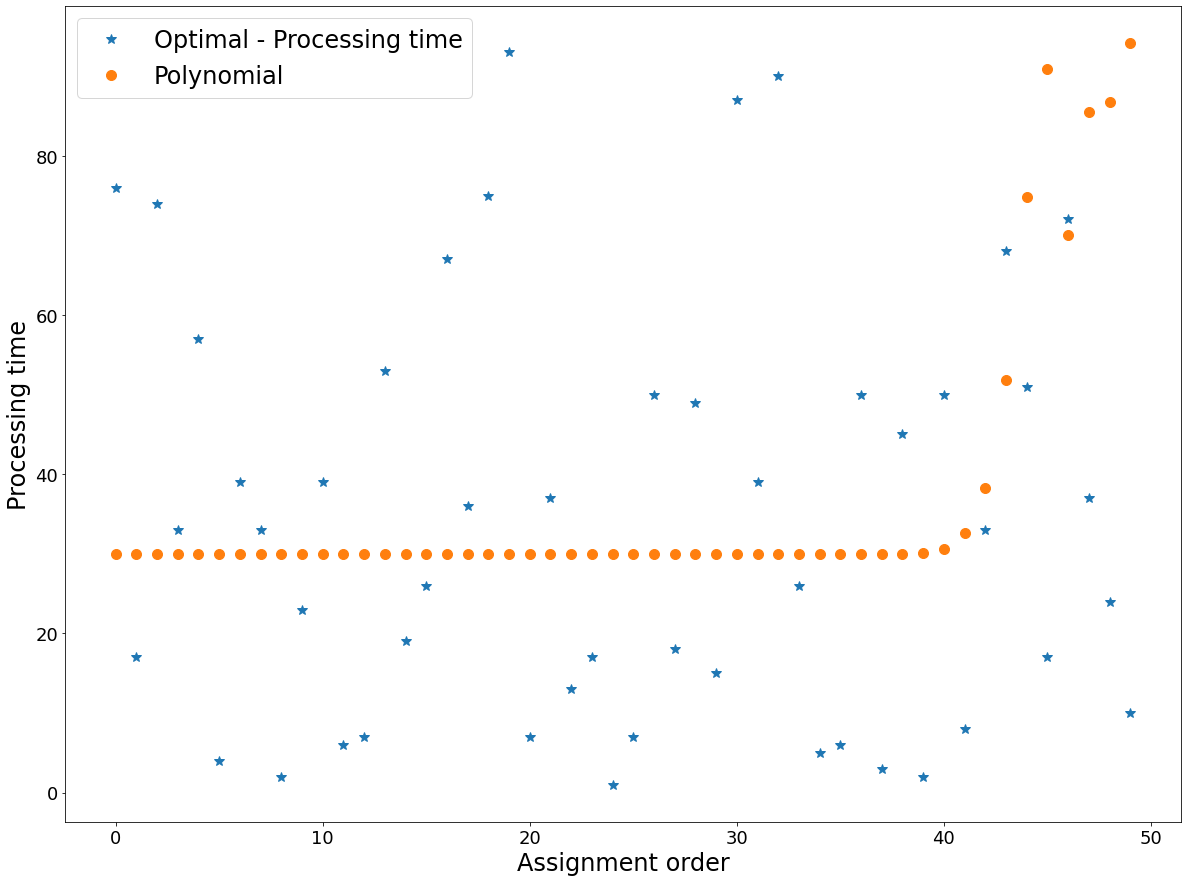

60
dataset: ./all_data/4x50/4x50-1.csv
dataset: ./all_data/4x50/4x50-2.csv
dataset: ./all_data/4x50/4x50-3.csv
dataset: ./all_data/4x50/4x50-4.csv
dataset: ./all_data/4x50/4x50-5.csv
Min-Min makespan: 307
process: [1, 1, 3, 3, 4, 4, 6, 6, 4, 11, 6, 6, 15, 8, 7, 14, 11, 15, 15, 13, 21, 18, 19, 14, 22, 19, 23, 20, 24, 26, 21, 29, 30, 26, 29, 34, 31, 34, 31, 35, 33, 40, 42, 46, 41, 42, 48, 53, 75, 62]

HASA makespan: 307
process: [11, 14, 15, 1, 15, 4, 3, 7, 3, 6, 1, 6, 4, 11, 4, 6, 6, 15, 8, 13, 21, 18, 19, 14, 22, 19, 23, 20, 24, 26, 21, 29, 30, 26, 29, 34, 31, 34, 31, 35, 33, 40, 42, 46, 41, 42, 48, 53, 75, 62]

Optimal makespan: 288
process: [30, 40, 23, 19, 4, 20, 42, 33, 18, 15, 34, 15, 26, 19, 14, 6, 11, 65, 22, 3, 14, 15, 6, 21, 34, 11, 6, 7, 13, 21, 41, 47, 4, 62, 1, 3, 35, 29, 42, 48, 1, 4, 31, 8, 6, 24, 46, 31, 26, 35]

Poly makespan: 322
process: [15, 16, 1, 15, 16, 3, 4, 4, 6, 6, 4, 6, 6, 11, 15, 7, 8, 14, 11, 18, 19, 13, 21, 14, 19, 23, 22, 20, 26, 29, 24, 21, 26, 34, 30, 29

/tmp/ipykernel_395369/3150712127.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


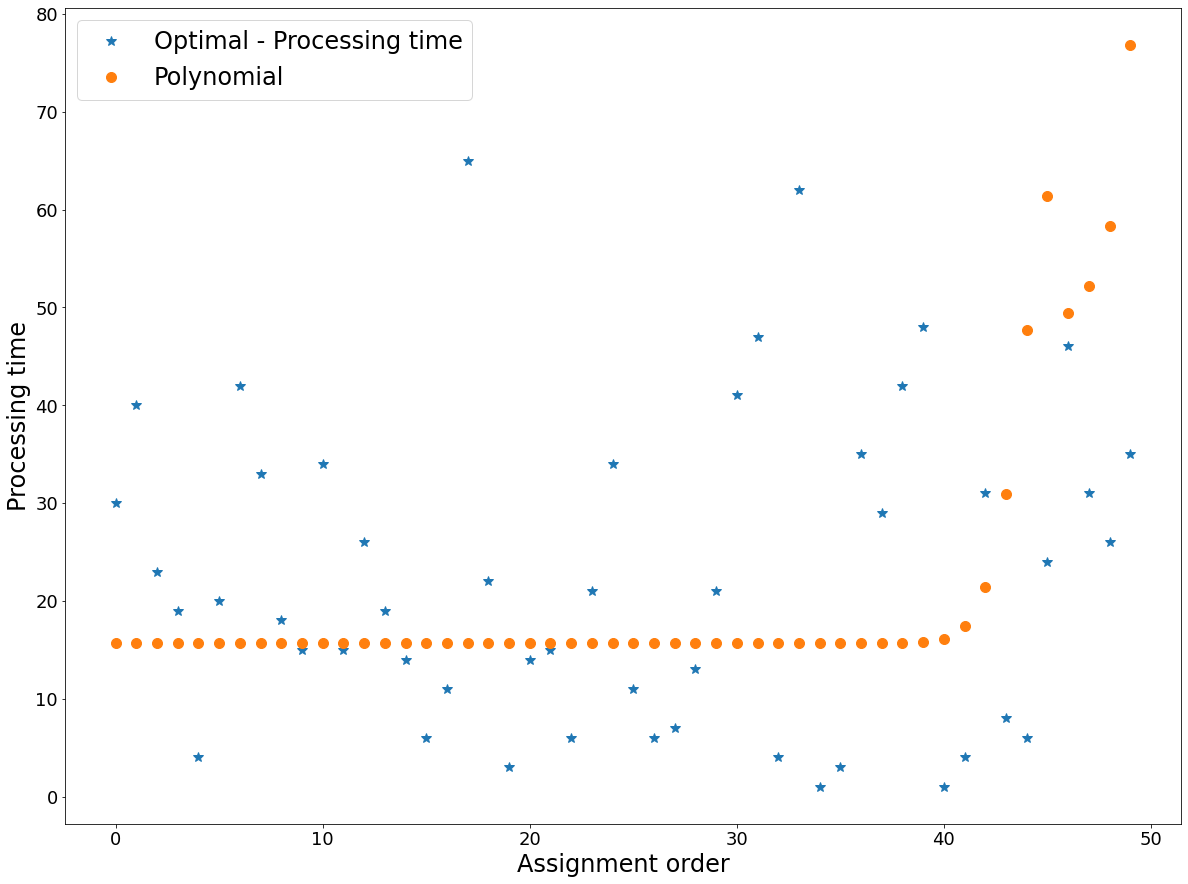

Min-Min makespan: 283
process: [1, 1, 2, 2, 3, 5, 6, 8, 7, 9, 8, 8, 10, 10, 9, 14, 10, 10, 11, 11, 14, 12, 15, 16, 16, 15, 17, 19, 19, 22, 18, 24, 21, 19, 32, 25, 22, 32, 32, 22, 33, 34, 27, 44, 50, 43, 42, 45, 54, 89]

HASA makespan: 283
process: [10, 11, 1, 1, 2, 14, 15, 3, 5, 6, 8, 1, 7, 9, 8, 10, 8, 10, 11, 14, 9, 10, 15, 16, 16, 12, 17, 17, 23, 22, 18, 21, 24, 19, 32, 32, 22, 25, 32, 22, 33, 34, 27, 44, 43, 50, 42, 45, 54, 89]

Optimal makespan: 251
process: [1, 45, 27, 50, 17, 32, 22, 64, 15, 22, 8, 10, 32, 9, 10, 10, 44, 1, 36, 22, 15, 11, 11, 5, 18, 7, 32, 25, 50, 3, 16, 24, 19, 32, 42, 2, 8, 14, 2, 8, 19, 11, 6, 54, 9, 12, 21, 16, 17, 14]

Poly makespan: 288
process: [16, 16, 15, 15, 1, 1, 3, 2, 2, 5, 6, 8, 9, 7, 8, 10, 8, 10, 14, 10, 9, 11, 14, 10, 11, 17, 12, 17, 23, 18, 22, 21, 24, 19, 32, 32, 22, 25, 22, 32, 34, 33, 27, 44, 43, 50, 42, 45, 54, 89]





/tmp/ipykernel_395369/3150712127.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


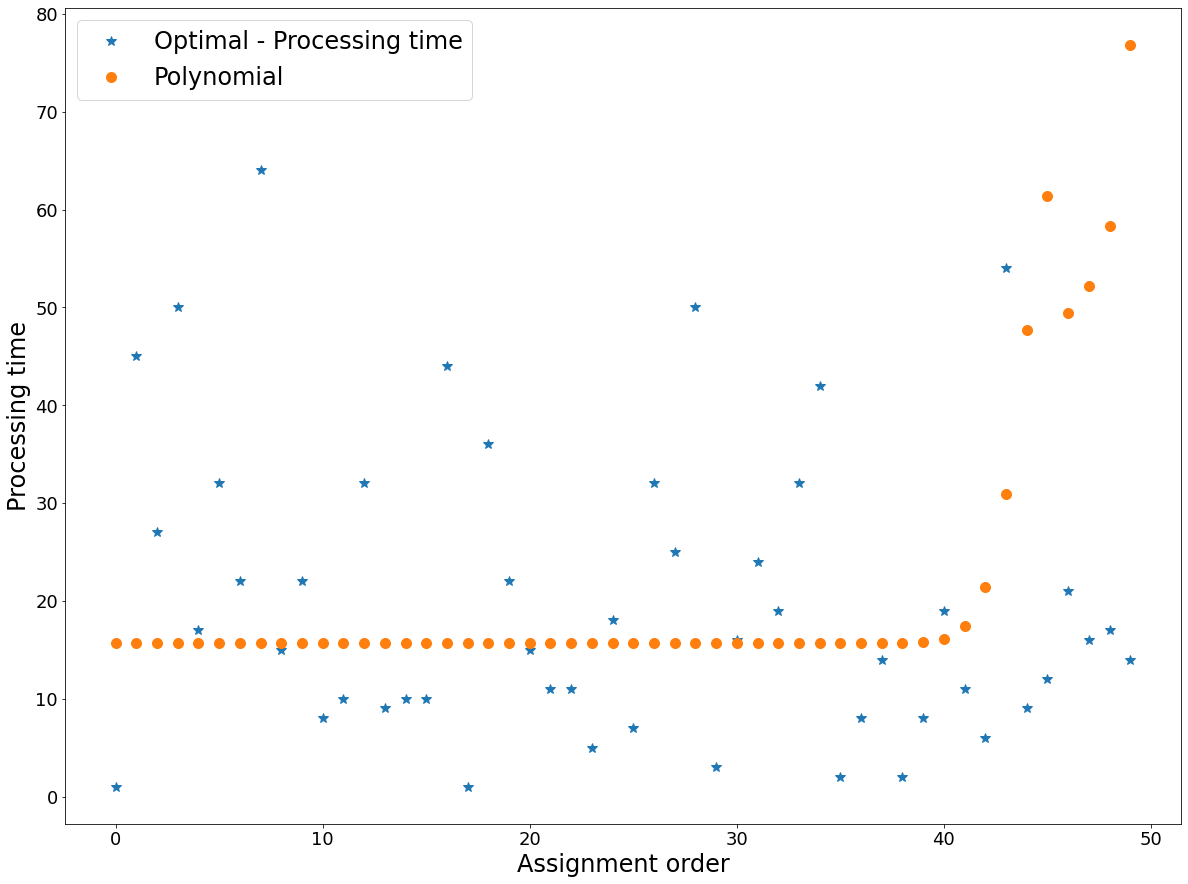

Min-Min makespan: 289
process: [1, 2, 3, 3, 2, 5, 3, 3, 5, 4, 4, 7, 5, 4, 9, 6, 5, 11, 8, 10, 11, 11, 12, 11, 15, 14, 12, 19, 12, 21, 20, 14, 22, 23, 26, 19, 25, 32, 33, 34, 32, 36, 34, 37, 38, 44, 68, 45, 44, 76]

HASA makespan: 289
process: [9, 10, 11, 12, 4, 4, 2, 3, 1, 3, 11, 5, 5, 3, 4, 5, 3, 7, 5, 4, 6, 11, 11, 8, 15, 12, 14, 19, 12, 21, 20, 14, 22, 23, 19, 26, 25, 32, 33, 34, 32, 36, 34, 37, 38, 68, 44, 45, 44, 76]

Optimal makespan: 240
process: [95, 12, 36, 25, 1, 39, 38, 2, 4, 26, 44, 15, 6, 5, 12, 14, 21, 19, 20, 3, 43, 3, 34, 10, 19, 12, 45, 14, 23, 3, 11, 44, 5, 11, 7, 21, 33, 8, 9, 32, 11, 5, 4, 2, 3, 4, 5, 34, 32, 22]

Poly makespan: 288
process: [15, 15, 14, 1, 3, 3, 19, 4, 2, 3, 5, 3, 5, 4, 5, 9, 7, 4, 6, 5, 11, 11, 8, 10, 11, 12, 11, 21, 12, 14, 12, 22, 23, 20, 19, 25, 26, 32, 34, 32, 33, 36, 36, 39, 38, 68, 45, 44, 44, 76]





/tmp/ipykernel_395369/3150712127.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


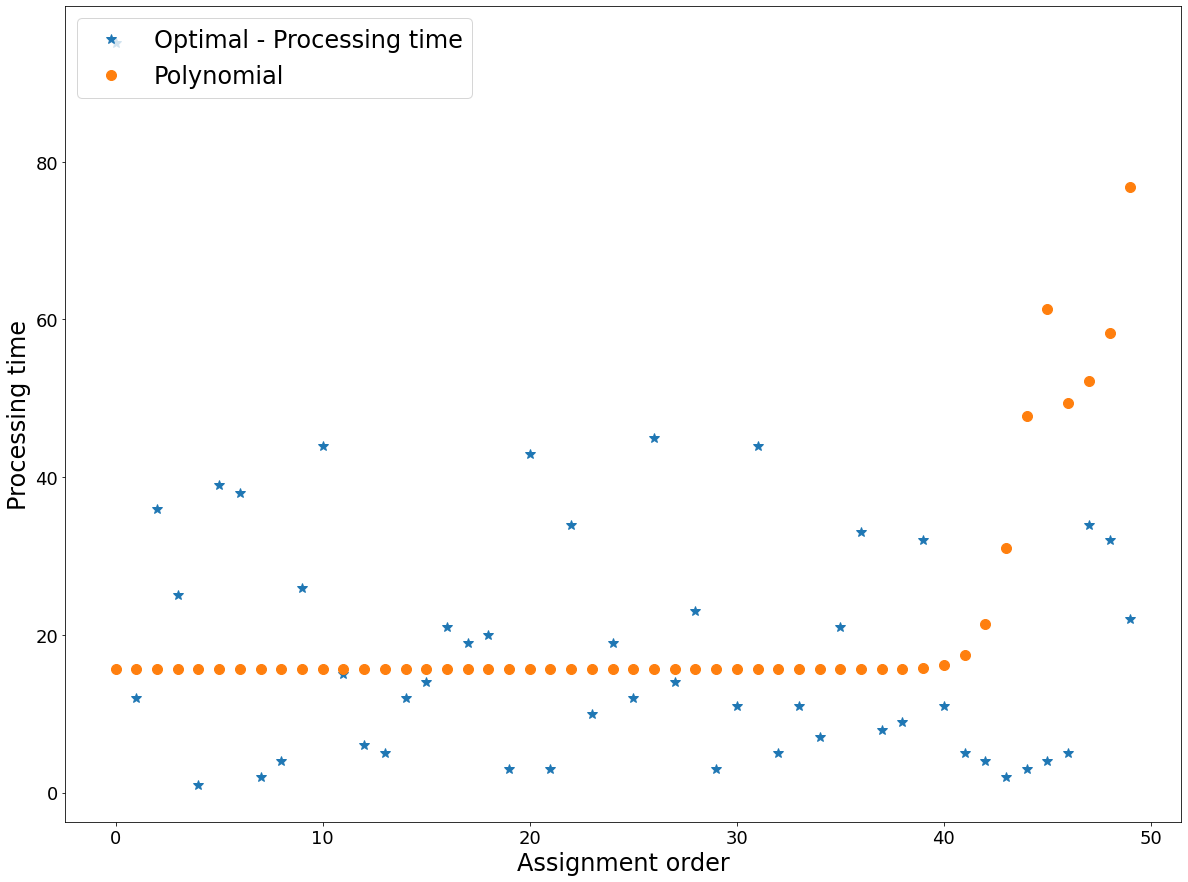

Min-Min makespan: 269
process: [1, 1, 1, 1, 1, 2, 2, 4, 3, 3, 3, 5, 3, 7, 4, 10, 7, 8, 6, 7, 8, 12, 16, 16, 9, 15, 17, 17, 14, 22, 15, 20, 25, 19, 28, 26, 28, 25, 29, 28, 35, 36, 36, 46, 47, 43, 60, 49, 60, 88]

HASA makespan: 266
process: [9, 10, 2, 12, 2, 14, 7, 4, 1, 4, 7, 3, 1, 1, 5, 3, 3, 16, 1, 6, 7, 3, 8, 8, 15, 17, 16, 14, 17, 22, 15, 25, 20, 19, 28, 28, 25, 26, 29, 28, 35, 36, 36, 46, 37, 56, 43, 60, 60, 90]

Optimal makespan: 246
process: [25, 10, 22, 36, 15, 2, 49, 1, 8, 28, 4, 5, 2, 8, 17, 7, 28, 1, 15, 7, 17, 7, 47, 37, 43, 3, 9, 35, 12, 7, 4, 60, 90, 26, 16, 19, 38, 20, 3, 3, 6, 14, 25, 36, 3, 16, 1, 1, 28, 60]

Poly makespan: 269
process: [16, 16, 15, 1, 15, 1, 1, 1, 1, 2, 2, 4, 3, 3, 3, 5, 3, 7, 4, 7, 10, 6, 8, 7, 8, 12, 17, 17, 9, 22, 14, 20, 25, 19, 28, 26, 28, 25, 29, 28, 35, 36, 36, 46, 47, 43, 60, 49, 60, 88]





/tmp/ipykernel_395369/3150712127.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


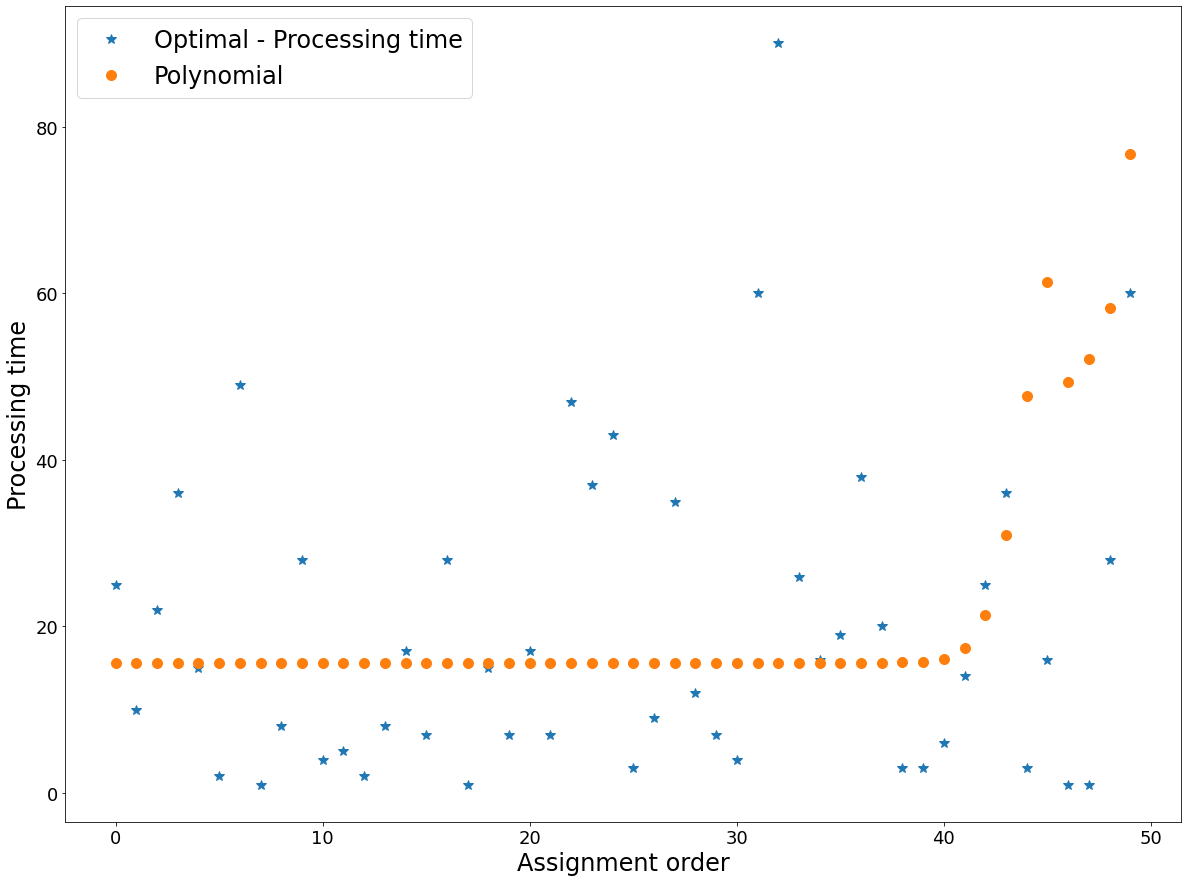

Min-Min makespan: 339
process: [1, 1, 1, 2, 2, 2, 2, 3, 5, 8, 3, 8, 6, 5, 6, 6, 10, 6, 8, 11, 23, 10, 12, 12, 12, 12, 25, 18, 18, 15, 15, 24, 29, 22, 34, 35, 46, 45, 47, 46, 49, 82, 47, 55, 57, 53, 86, 57, 65, 68]

HASA makespan: 360
process: [12, 1, 13, 1, 2, 2, 12, 6, 2, 5, 2, 23, 1, 3, 6, 11, 3, 8, 6, 5, 8, 6, 8, 12, 10, 14, 23, 18, 15, 24, 25, 15, 21, 22, 34, 45, 46, 35, 46, 49, 47, 82, 57, 55, 47, 86, 65, 57, 53, 68]

Optimal makespan: 303
process: [22, 1, 92, 57, 5, 45, 53, 46, 47, 61, 2, 24, 47, 2, 2, 1, 6, 58, 1, 12, 5, 12, 18, 82, 55, 6, 8, 11, 3, 18, 6, 60, 12, 55, 10, 25, 34, 8, 2, 35, 8, 15, 21, 10, 49, 15, 6, 3, 12, 14]

Poly makespan: 348
process: [15, 1, 14, 2, 1, 2, 18, 2, 11, 8, 1, 2, 5, 3, 10, 3, 6, 5, 6, 11, 6, 8, 24, 6, 12, 12, 10, 13, 14, 25, 21, 15, 24, 22, 34, 46, 45, 35, 73, 46, 47, 55, 47, 57, 57, 82, 53, 65, 60, 68]





/tmp/ipykernel_395369/3150712127.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


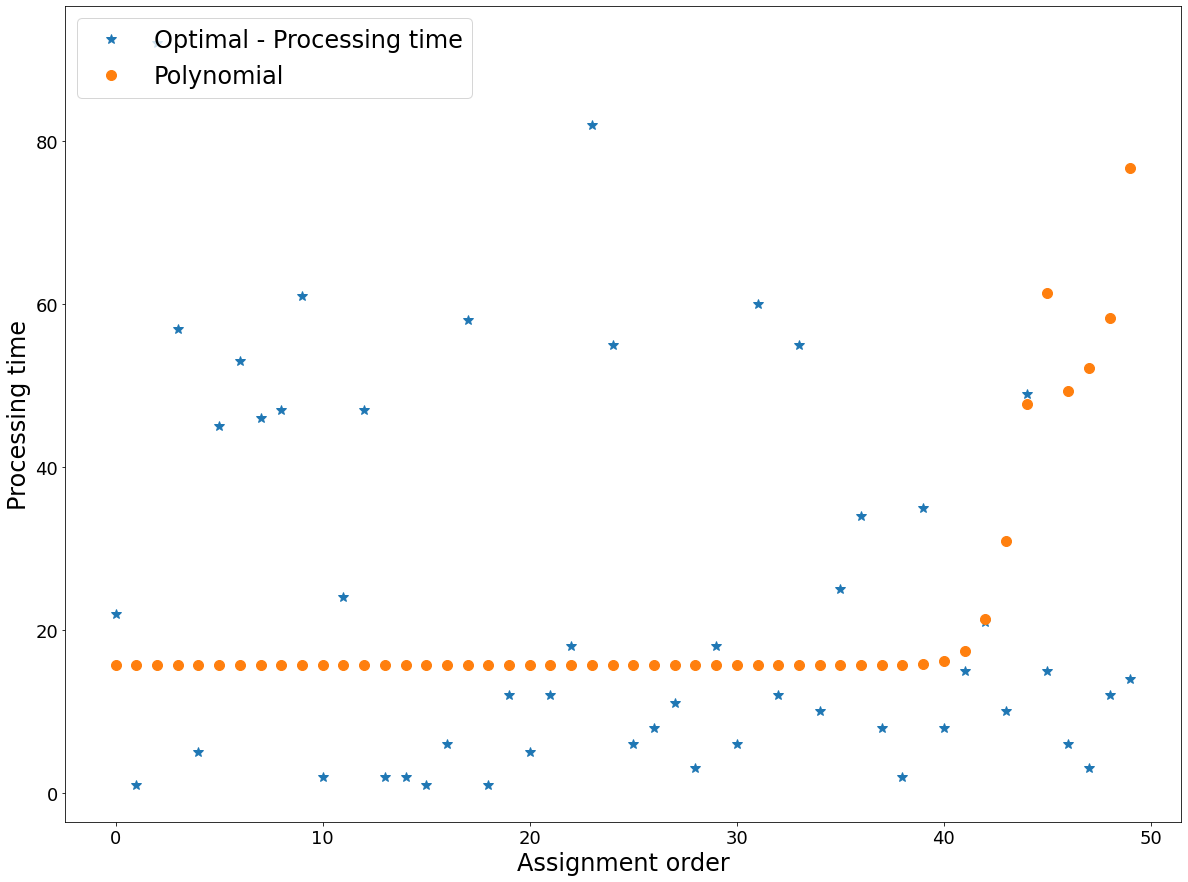

25
dataset: ./all_data/5x20/5x20-1.csv
dataset: ./all_data/5x20/5x20-2.csv
dataset: ./all_data/5x20/5x20-3.csv
dataset: ./all_data/5x20/5x20-4.csv
dataset: ./all_data/5x20/5x20-5.csv
Min-Min makespan: 139
process: [1, 2, 2, 5, 7, 9, 7, 8, 19, 11, 27, 25, 20, 40, 30, 29, 46, 48, 41, 41]

HASA makespan: 110
process: [11, 2, 9, 8, 18, 8, 23, 4, 7, 27, 19, 7, 29, 20, 43, 36, 40, 39, 60, 46]

Optimal makespan: 96
process: [2, 7, 2, 42, 40, 46, 17, 39, 20, 30, 11, 27, 7, 36, 29, 8, 4, 29, 60, 9]

Poly makespan: 110
process: [11, 2, 9, 8, 7, 7, 4, 18, 8, 27, 19, 23, 29, 20, 43, 36, 40, 39, 60, 46]





/tmp/ipykernel_395369/3150712127.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


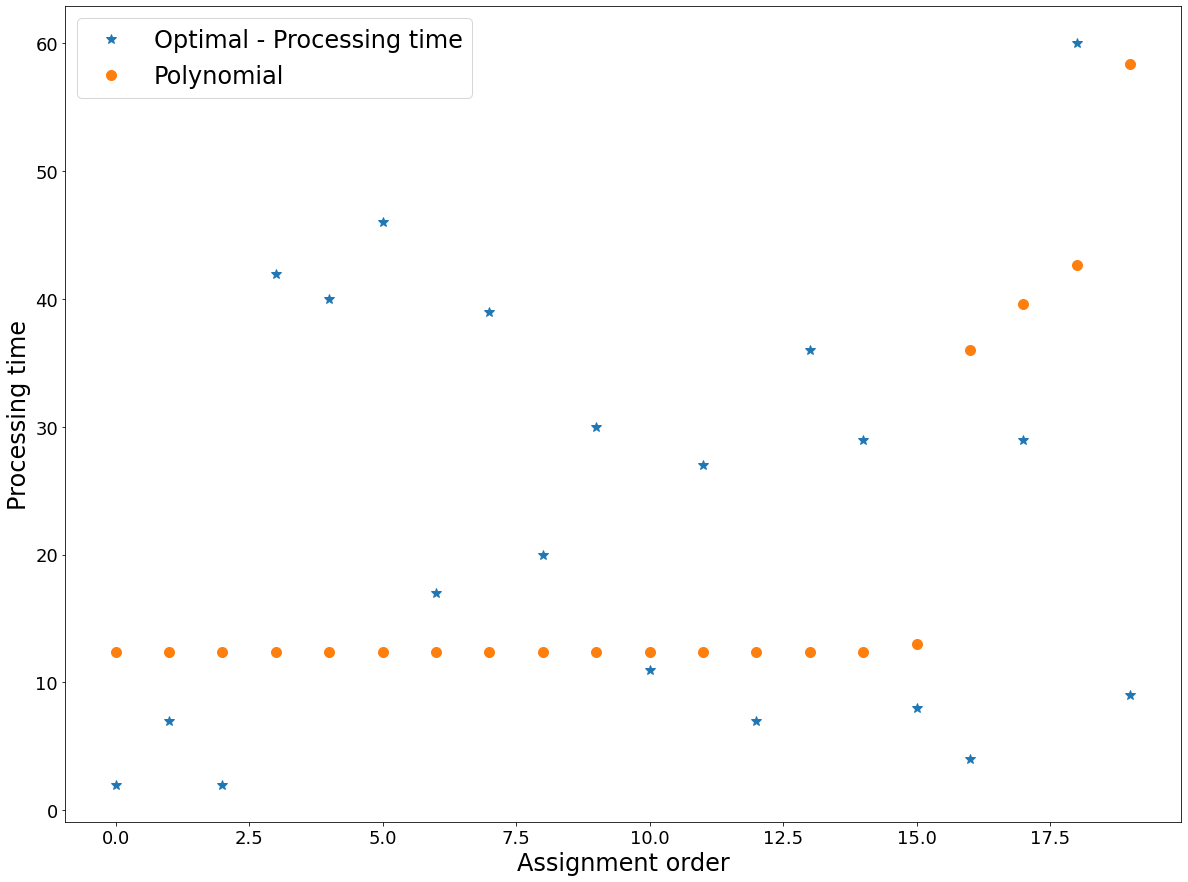

Min-Min makespan: 103
process: [1, 1, 3, 4, 6, 9, 13, 13, 12, 12, 20, 16, 12, 28, 20, 26, 36, 55, 33, 49]

HASA makespan: 103
process: [9, 1, 12, 13, 13, 1, 3, 20, 12, 4, 6, 16, 12, 28, 20, 26, 36, 55, 33, 49]

Optimal makespan: 80
process: [13, 20, 29, 13, 62, 9, 29, 22, 15, 26, 4, 28, 12, 20, 16, 6, 1, 1, 3, 54]

Poly makespan: 103
process: [12, 12, 13, 13, 1, 1, 3, 7, 6, 9, 16, 19, 12, 31, 29, 20, 26, 33, 55, 49]





/tmp/ipykernel_395369/3150712127.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


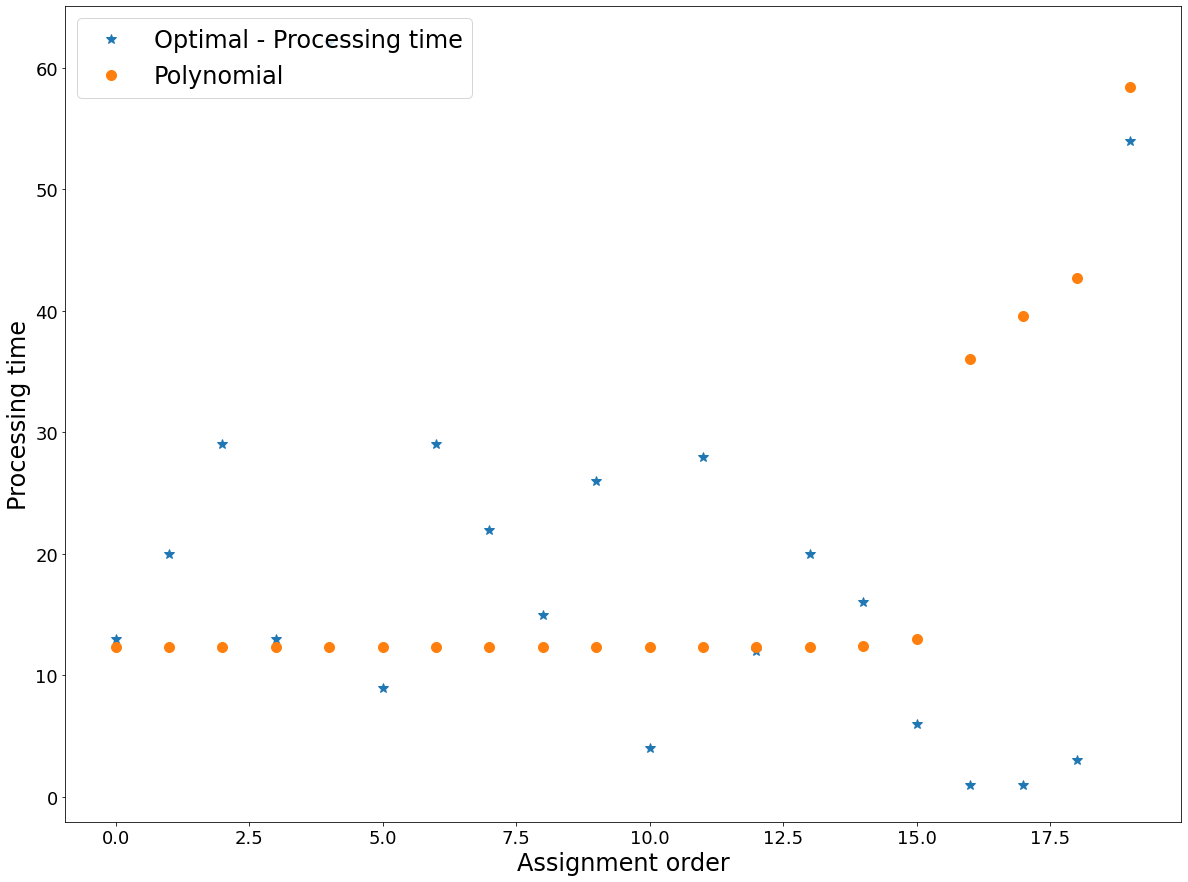

Min-Min makespan: 136
process: [1, 2, 4, 5, 5, 5, 4, 4, 10, 14, 18, 20, 30, 19, 21, 52, 44, 37, 51, 97]

HASA makespan: 131
process: [10, 14, 5, 1, 8, 4, 2, 20, 5, 30, 6, 18, 4, 19, 21, 52, 44, 37, 51, 97]

Optimal makespan: 85
process: [4, 20, 8, 30, 5, 18, 51, 14, 10, 44, 5, 1, 51, 2, 37, 4, 5, 70, 19, 21]

Poly makespan: 131
process: [14, 10, 5, 1, 8, 4, 2, 5, 4, 4, 20, 18, 19, 30, 21, 52, 44, 37, 51, 97]





/tmp/ipykernel_395369/3150712127.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


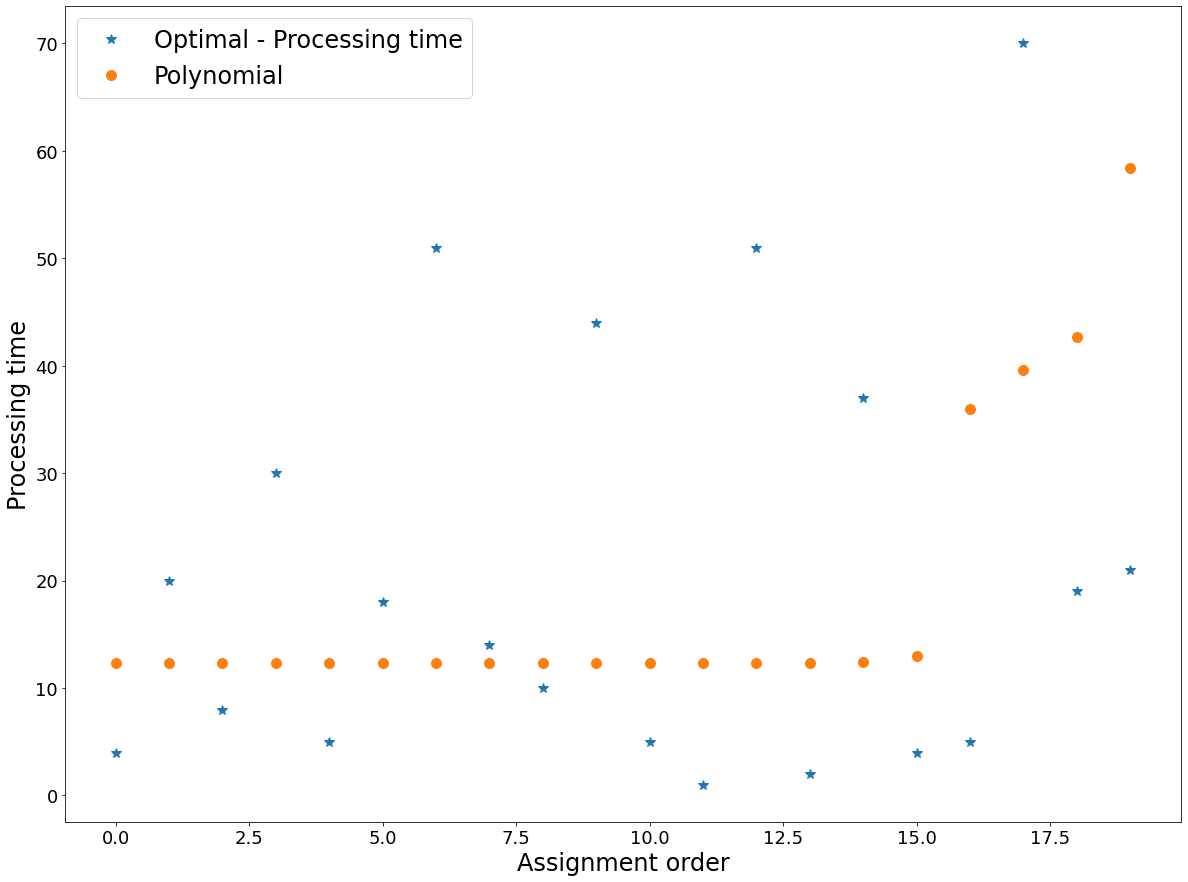

Min-Min makespan: 86
process: [2, 4, 4, 7, 7, 6, 13, 11, 9, 13, 12, 10, 18, 18, 16, 16, 13, 19, 34, 50]

HASA makespan: 86
process: [7, 7, 2, 9, 11, 13, 4, 4, 6, 13, 12, 10, 18, 18, 16, 16, 13, 19, 34, 50]

Optimal makespan: 64
process: [18, 2, 50, 15, 13, 13, 7, 4, 13, 11, 12, 10, 24, 4, 27, 6, 34, 7, 16, 13]

Poly makespan: 106
process: [12, 13, 13, 13, 11, 2, 4, 4, 7, 7, 6, 18, 9, 18, 16, 10, 13, 19, 36, 50]





/tmp/ipykernel_395369/3150712127.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


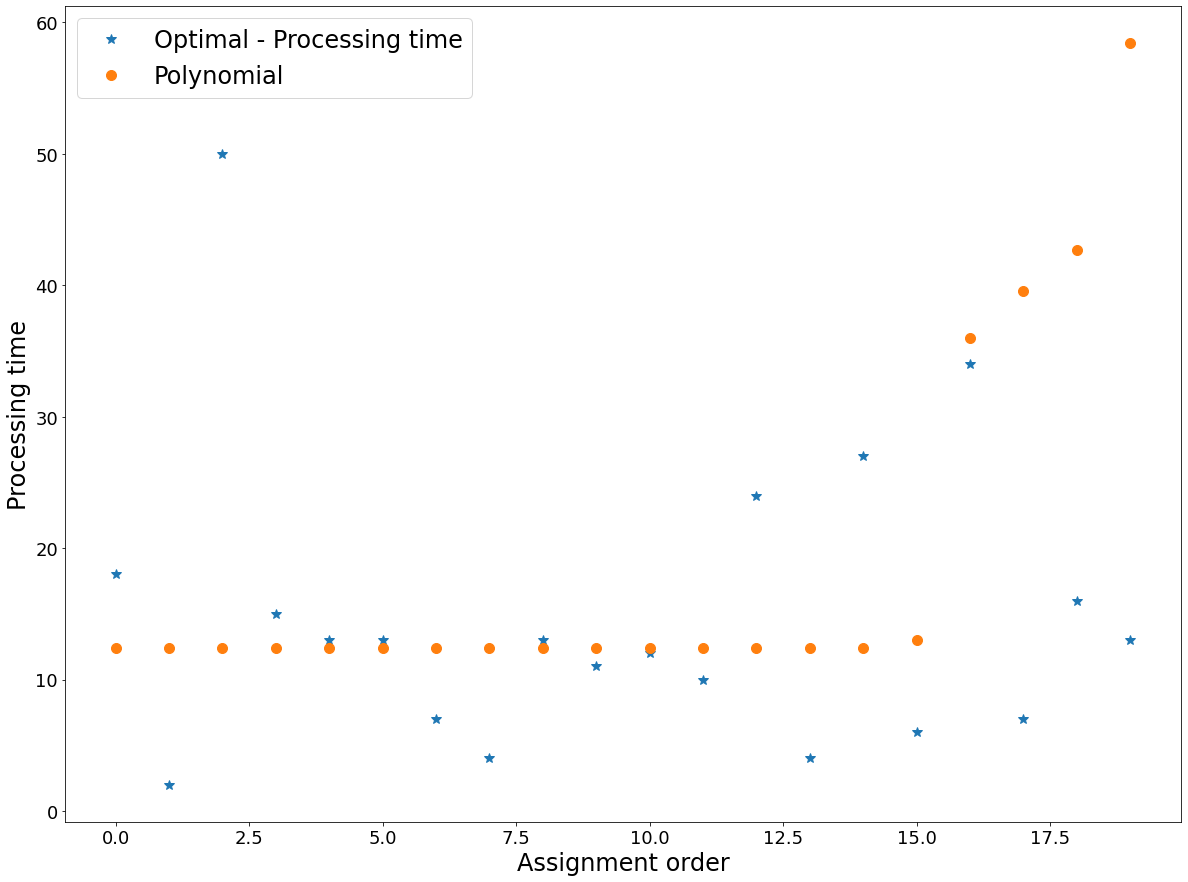

Min-Min makespan: 95
process: [1, 2, 2, 2, 2, 2, 2, 3, 9, 10, 6, 9, 19, 17, 25, 45, 46, 37, 45, 59]

HASA makespan: 88
process: [9, 9, 2, 1, 2, 3, 18, 3, 19, 6, 9, 4, 2, 25, 36, 17, 37, 50, 45, 46]

Optimal makespan: 77
process: [17, 50, 2, 2, 18, 19, 37, 10, 45, 3, 4, 2, 9, 35, 1, 46, 2, 2, 9, 25]

Poly makespan: 88
process: [9, 3, 2, 9, 1, 2, 18, 3, 19, 6, 4, 2, 9, 25, 36, 17, 37, 50, 45, 46]





/tmp/ipykernel_395369/3150712127.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


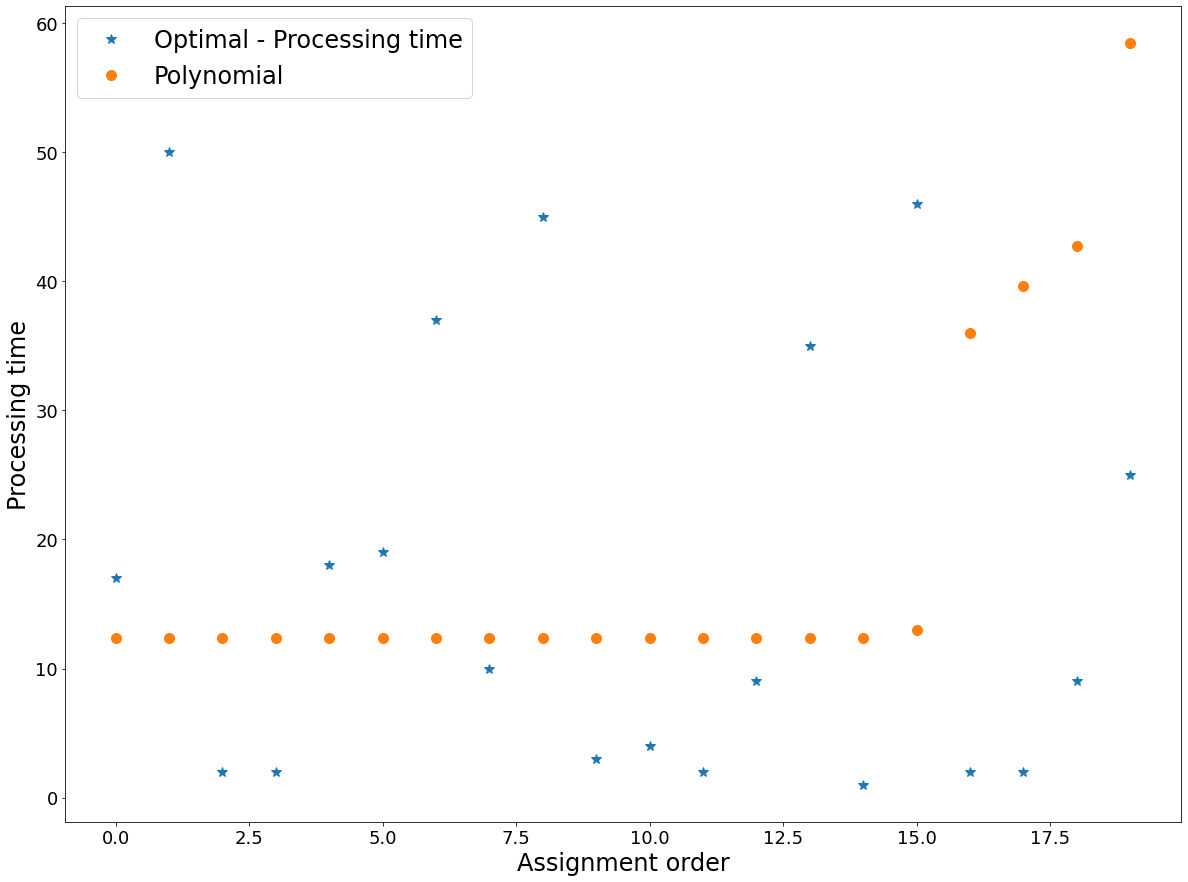

35
dataset: ./all_data/5x40/5x40-1.csv
dataset: ./all_data/5x40/5x40-2.csv
dataset: ./all_data/5x40/5x40-3.csv
dataset: ./all_data/5x40/5x40-4.csv
dataset: ./all_data/5x40/5x40-5.csv
Min-Min makespan: 144
process: [1, 1, 1, 2, 2, 3, 1, 2, 3, 3, 3, 6, 5, 4, 5, 5, 7, 5, 13, 7, 7, 14, 19, 13, 15, 18, 20, 23, 15, 17, 17, 34, 19, 18, 38, 46, 41, 56, 51, 57]

HASA makespan: 144
process: [7, 2, 7, 3, 1, 3, 1, 1, 13, 14, 4, 3, 2, 5, 2, 19, 1, 5, 3, 7, 5, 6, 5, 13, 15, 18, 20, 23, 15, 17, 17, 34, 19, 18, 38, 46, 41, 56, 51, 57]

Optimal makespan: 134
process: [56, 1, 56, 32, 4, 13, 7, 34, 3, 5, 46, 3, 1, 41, 3, 18, 1, 7, 15, 2, 1, 15, 2, 3, 5, 57, 23, 26, 7, 24, 17, 2, 13, 19, 20, 18, 7, 19, 5, 17]

Poly makespan: 161
process: [13, 13, 13, 13, 1, 1, 2, 3, 3, 2, 3, 6, 1, 4, 3, 5, 5, 5, 19, 7, 5, 7, 7, 18, 14, 15, 23, 15, 20, 17, 17, 34, 30, 18, 46, 41, 26, 56, 57, 56]





/tmp/ipykernel_395369/3150712127.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


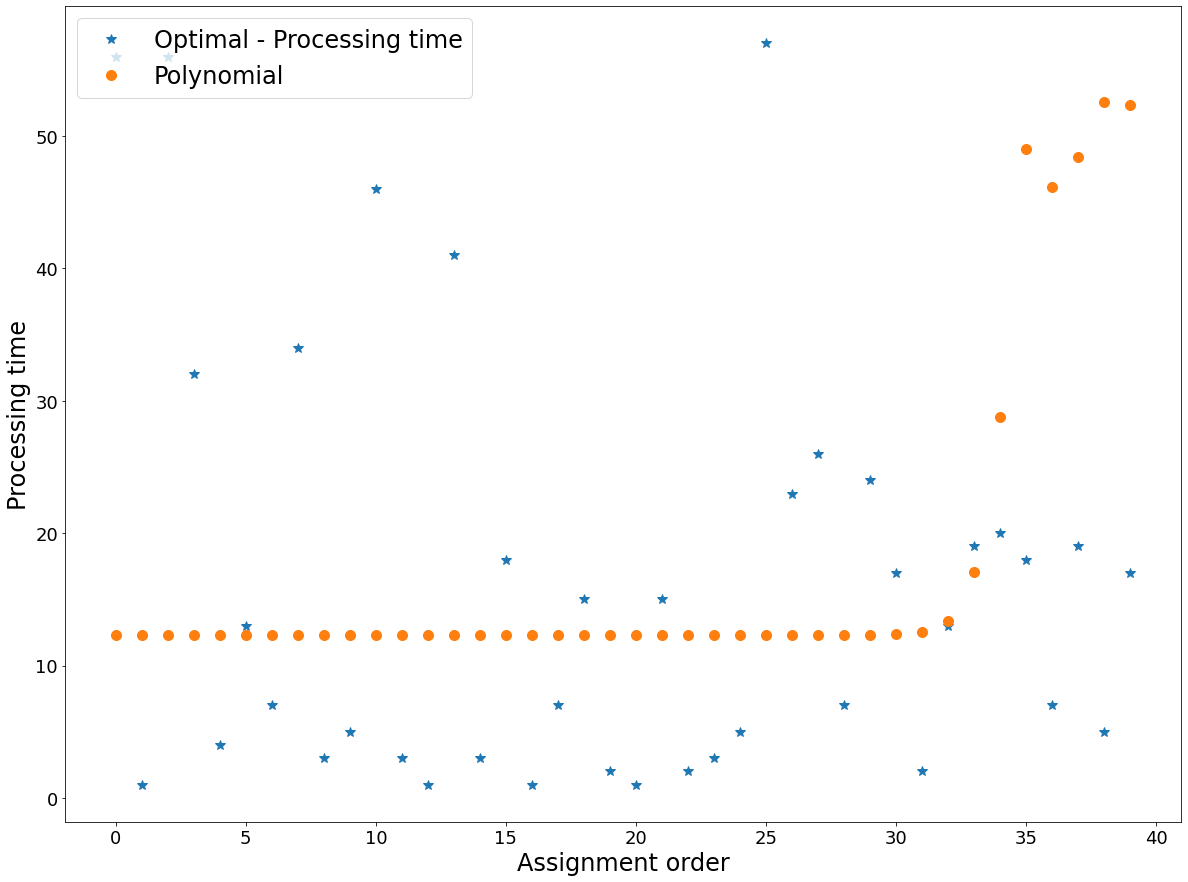

Min-Min makespan: 160
process: [1, 1, 1, 3, 4, 4, 6, 3, 6, 4, 4, 4, 7, 7, 4, 12, 5, 8, 8, 6, 11, 11, 17, 11, 16, 13, 14, 15, 17, 23, 18, 28, 26, 33, 39, 43, 54, 33, 77, 54]

HASA makespan: 158
process: [8, 8, 7, 11, 4, 12, 6, 1, 7, 4, 1, 4, 1, 3, 6, 4, 4, 3, 11, 4, 9, 5, 17, 6, 16, 13, 14, 15, 17, 23, 18, 28, 26, 33, 43, 39, 54, 33, 77, 54]

Optimal makespan: 137
process: [33, 9, 4, 33, 11, 7, 54, 36, 17, 11, 8, 54, 19, 18, 23, 1, 14, 9, 4, 1, 3, 77, 16, 13, 6, 7, 22, 6, 28, 5, 39, 4, 4, 25, 6, 4, 1, 17, 17, 8]

Poly makespan: 160
process: [13, 13, 12, 11, 1, 1, 4, 1, 16, 6, 4, 4, 3, 6, 3, 4, 4, 4, 7, 11, 8, 5, 17, 8, 6, 14, 11, 17, 28, 23, 18, 15, 26, 33, 39, 43, 54, 33, 77, 54]





/tmp/ipykernel_395369/3150712127.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


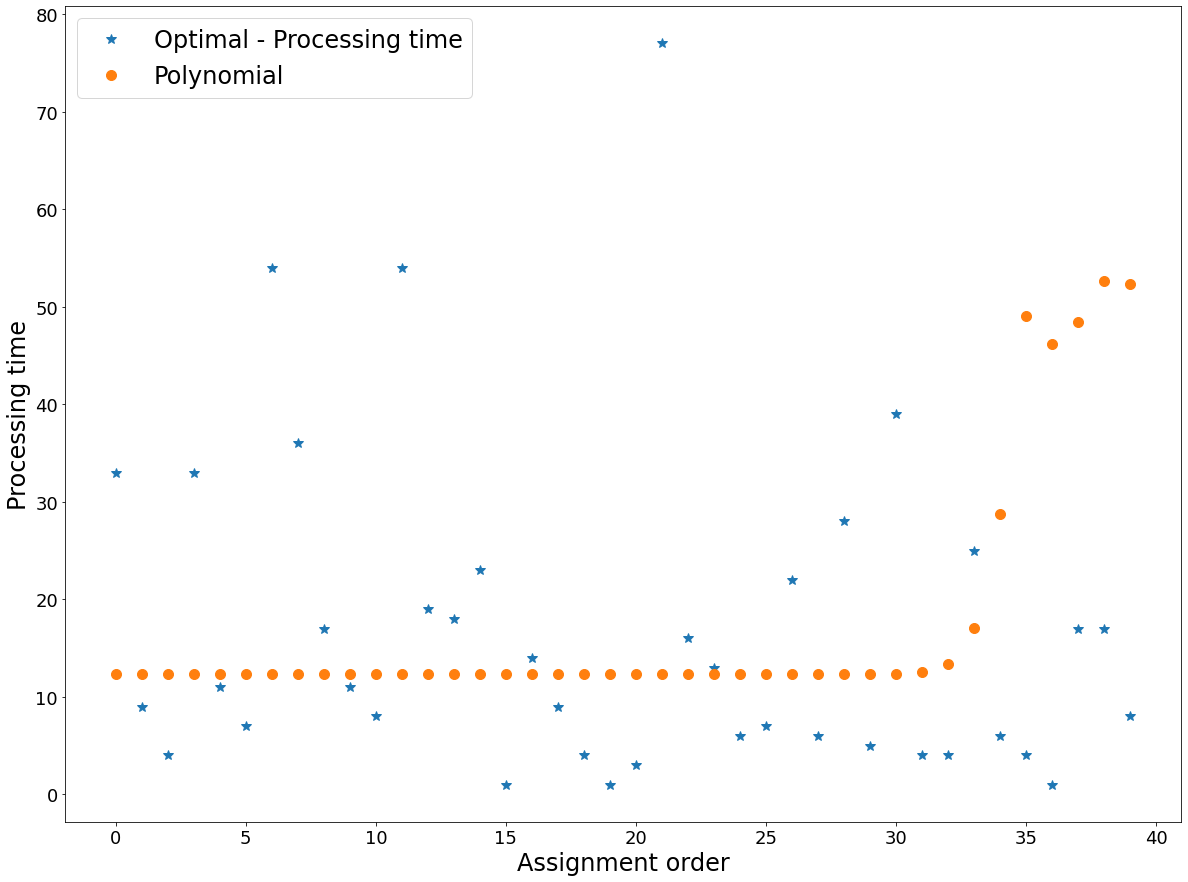

Min-Min makespan: 192
process: [2, 2, 2, 5, 3, 6, 5, 4, 8, 9, 5, 8, 6, 16, 17, 10, 8, 16, 11, 18, 18, 21, 21, 22, 22, 26, 41, 22, 27, 37, 31, 41, 38, 43, 42, 39, 72, 61, 44, 48]

HASA makespan: 192
process: [10, 11, 2, 5, 3, 16, 17, 16, 4, 6, 5, 8, 2, 9, 5, 2, 6, 8, 8, 18, 18, 21, 21, 22, 22, 26, 41, 22, 27, 37, 31, 41, 38, 43, 42, 39, 72, 61, 44, 48]

Optimal makespan: 177
process: [8, 61, 21, 72, 39, 17, 2, 6, 18, 2, 5, 31, 35, 3, 6, 44, 22, 48, 26, 6, 11, 51, 22, 9, 41, 8, 13, 38, 4, 5, 22, 37, 43, 27, 21, 12, 18, 6, 16, 5]

Poly makespan: 192
process: [11, 2, 10, 5, 3, 16, 16, 13, 2, 4, 5, 6, 8, 9, 5, 6, 8, 17, 8, 18, 21, 18, 21, 22, 26, 41, 22, 22, 37, 31, 27, 41, 38, 43, 42, 39, 61, 72, 44, 48]





/tmp/ipykernel_395369/3150712127.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


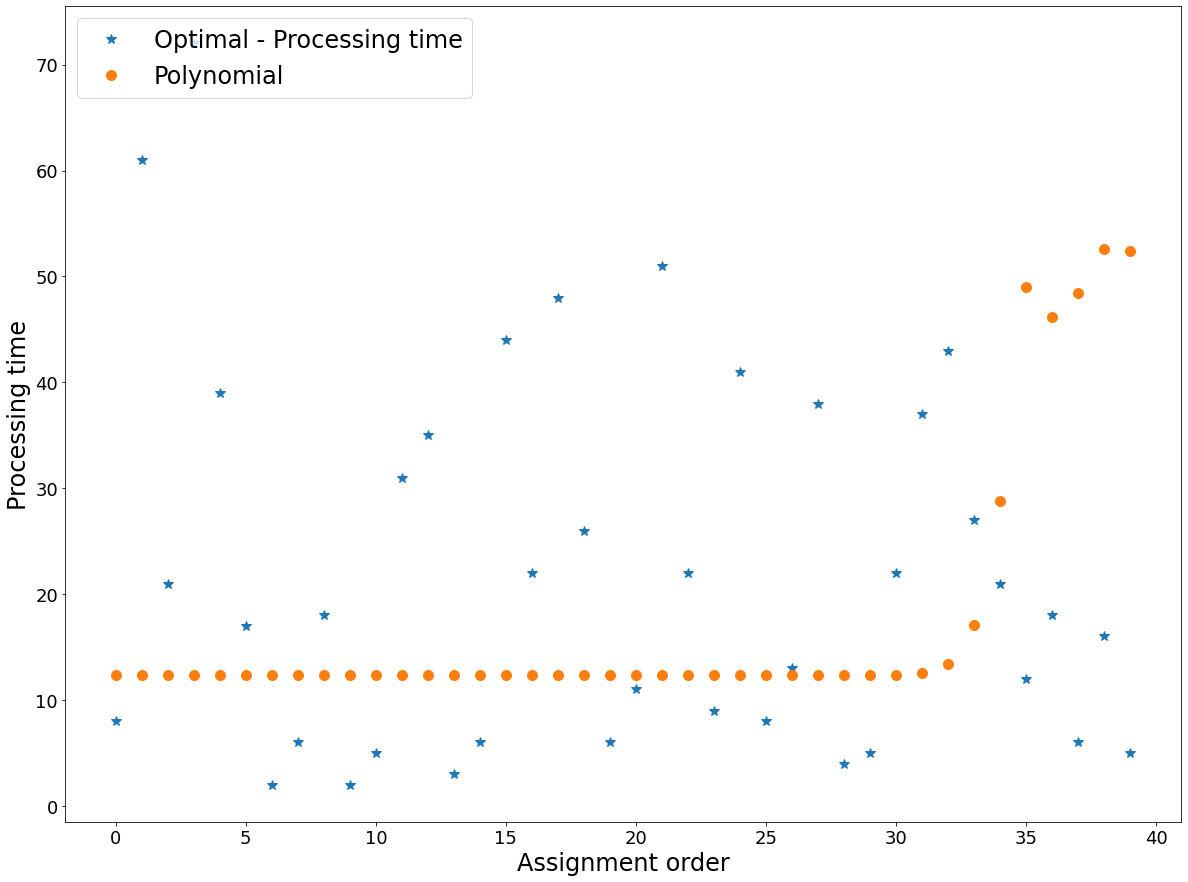

Min-Min makespan: 179
process: [1, 1, 1, 2, 1, 6, 5, 6, 7, 10, 7, 7, 8, 14, 7, 8, 12, 7, 14, 10, 15, 13, 22, 11, 19, 19, 18, 22, 29, 26, 19, 22, 24, 30, 27, 39, 44, 46, 40, 62]

HASA makespan: 179
process: [8, 2, 10, 13, 1, 14, 1, 14, 6, 1, 1, 5, 6, 7, 7, 12, 7, 8, 10, 7, 15, 15, 11, 19, 18, 19, 22, 22, 19, 26, 22, 29, 24, 31, 27, 39, 44, 53, 40, 62]

Optimal makespan: 148
process: [10, 5, 22, 24, 2, 6, 15, 11, 18, 6, 8, 1, 1, 14, 62, 7, 31, 21, 22, 1, 8, 41, 7, 40, 47, 14, 10, 26, 12, 46, 44, 19, 29, 7, 19, 15, 13, 22, 22, 1]

Poly makespan: 179
process: [12, 13, 1, 11, 2, 14, 13, 1, 1, 1, 6, 5, 7, 10, 7, 7, 8, 15, 8, 7, 15, 14, 10, 22, 18, 19, 19, 22, 19, 22, 29, 26, 24, 31, 27, 39, 44, 53, 40, 62]





/tmp/ipykernel_395369/3150712127.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


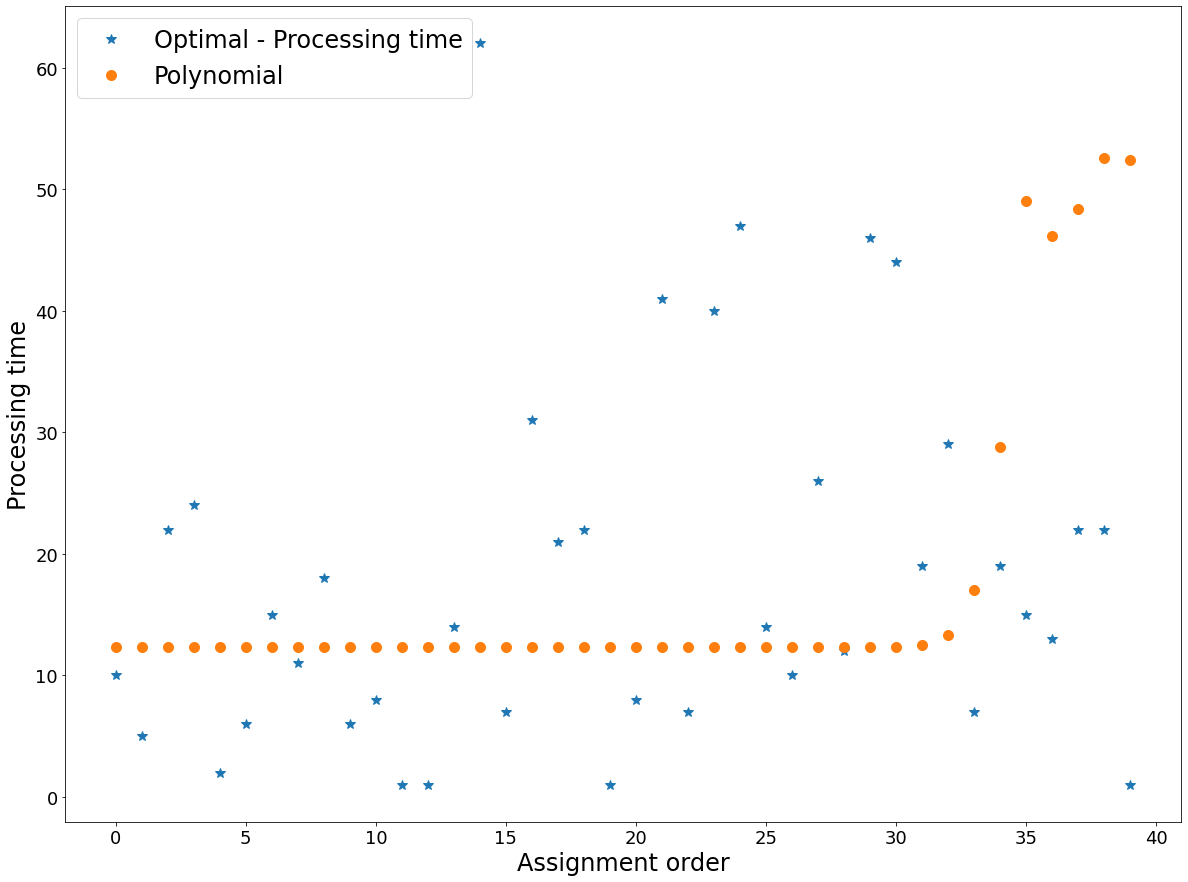

Min-Min makespan: 168
process: [1, 1, 2, 2, 1, 3, 3, 5, 6, 6, 6, 6, 13, 8, 9, 12, 12, 8, 11, 11, 21, 15, 17, 16, 17, 21, 19, 30, 20, 19, 26, 26, 31, 23, 54, 41, 34, 28, 51, 40]

HASA makespan: 168
process: [8, 9, 10, 2, 12, 13, 3, 3, 5, 1, 8, 6, 6, 6, 6, 1, 1, 11, 11, 12, 21, 17, 16, 15, 21, 19, 30, 17, 20, 19, 28, 26, 31, 23, 41, 34, 28, 54, 51, 40]

Optimal makespan: 139
process: [34, 2, 29, 19, 3, 13, 6, 28, 37, 45, 23, 21, 15, 19, 23, 16, 3, 12, 9, 6, 40, 20, 1, 28, 34, 2, 1, 21, 17, 8, 35, 6, 11, 5, 6, 1, 12, 8, 31, 30]

Poly makespan: 168
process: [12, 12, 12, 13, 1, 11, 2, 2, 1, 1, 3, 3, 5, 6, 8, 6, 6, 8, 9, 21, 15, 17, 11, 16, 17, 21, 19, 20, 30, 19, 26, 26, 23, 31, 54, 41, 34, 28, 51, 40]





/tmp/ipykernel_395369/3150712127.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


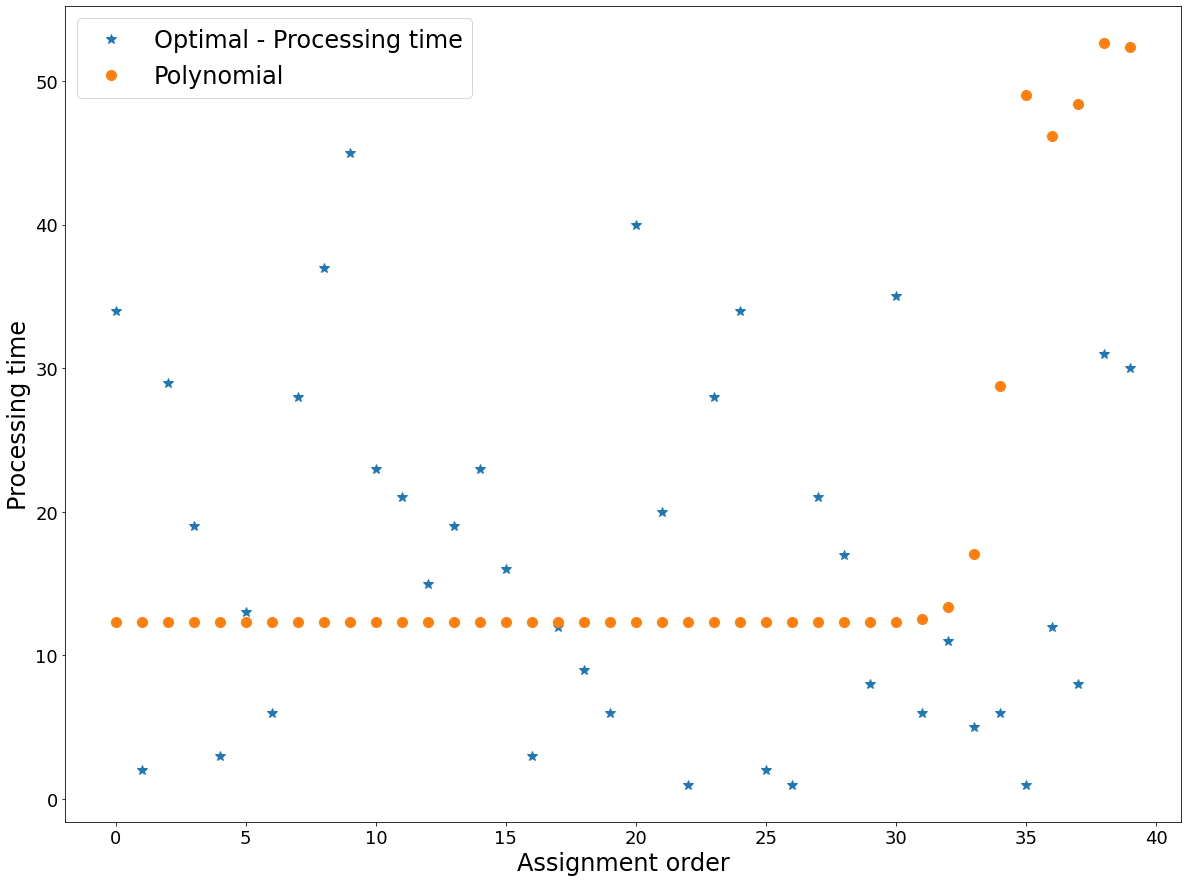

18
dataset: ./all_data/5x80/5x80-1.csv
dataset: ./all_data/5x80/5x80-2.csv
dataset: ./all_data/5x80/5x80-3.csv
dataset: ./all_data/5x80/5x80-4.csv
dataset: ./all_data/5x80/5x80-5.csv
Min-Min makespan: 279
process: [1, 1, 1, 2, 1, 3, 2, 3, 3, 3, 4, 3, 3, 6, 4, 4, 3, 5, 4, 6, 7, 5, 6, 6, 6, 8, 8, 11, 8, 7, 8, 8, 7, 8, 11, 9, 9, 9, 9, 14, 14, 13, 11, 10, 14, 17, 13, 19, 16, 18, 15, 22, 18, 25, 17, 27, 19, 23, 19, 25, 23, 24, 27, 22, 28, 23, 27, 29, 24, 28, 27, 27, 29, 37, 29, 37, 45, 40, 61, 59]

HASA makespan: 276
process: [7, 8, 9, 10, 3, 1, 3, 12, 6, 2, 3, 1, 3, 4, 1, 3, 3, 6, 3, 5, 1, 4, 6, 3, 6, 4, 5, 8, 11, 6, 6, 8, 8, 7, 8, 11, 8, 7, 9, 9, 9, 10, 17, 11, 14, 13, 16, 13, 18, 22, 19, 15, 18, 23, 17, 27, 25, 19, 19, 23, 27, 24, 25, 22, 23, 27, 29, 28, 24, 27, 27, 29, 28, 37, 37, 29, 35, 44, 55, 59]

Optimal makespan: 246
process: [19, 15, 9, 6, 8, 44, 8, 3, 3, 29, 4, 7, 40, 30, 6, 8, 1, 17, 2, 3, 9, 37, 2, 37, 6, 23, 1, 3, 17, 25, 17, 28, 27, 6, 16, 27, 3, 13, 19, 7, 9, 4, 28, 3, 29, 

/tmp/ipykernel_395369/3150712127.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


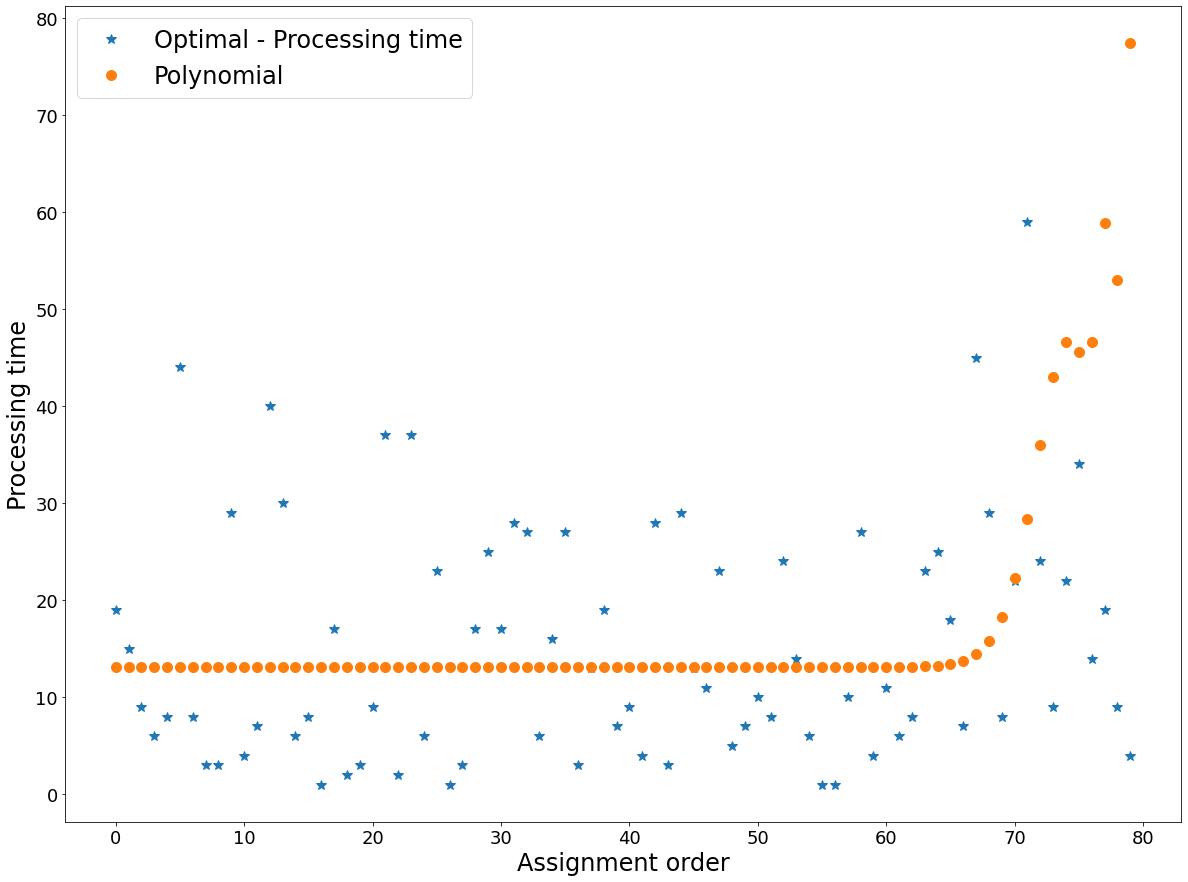

Min-Min makespan: 320
process: [1, 1, 2, 2, 1, 1, 2, 4, 4, 4, 5, 3, 5, 4, 5, 6, 7, 5, 5, 6, 5, 9, 6, 9, 5, 7, 8, 10, 7, 9, 7, 13, 10, 10, 11, 11, 11, 12, 16, 13, 19, 13, 15, 15, 20, 14, 26, 16, 19, 16, 22, 18, 17, 21, 33, 23, 25, 18, 24, 24, 20, 37, 27, 25, 21, 29, 30, 27, 25, 29, 51, 33, 36, 31, 57, 57, 43, 45, 61, 77]

HASA makespan: 334
process: [9, 9, 10, 11, 4, 13, 5, 2, 4, 1, 2, 7, 1, 5, 2, 1, 5, 1, 4, 3, 5, 4, 5, 6, 5, 10, 6, 6, 9, 5, 7, 10, 8, 7, 11, 7, 11, 16, 13, 13, 19, 12, 14, 15, 20, 15, 26, 16, 19, 16, 22, 17, 21, 18, 33, 23, 18, 24, 25, 20, 24, 37, 25, 21, 30, 29, 25, 25, 39, 29, 49, 35, 45, 31, 51, 43, 57, 53, 57, 100]

Optimal makespan: 284
process: [11, 27, 10, 24, 61, 5, 7, 1, 11, 27, 45, 5, 15, 17, 2, 7, 4, 24, 25, 2, 5, 12, 6, 14, 26, 21, 5, 4, 15, 5, 18, 21, 2, 30, 12, 25, 22, 13, 10, 9, 20, 5, 33, 29, 36, 6, 43, 43, 16, 9, 19, 57, 7, 1, 28, 25, 1, 18, 20, 37, 6, 10, 16, 9, 4, 16, 63, 11, 31, 29, 51, 33, 9, 13, 4, 8, 26, 3, 7, 1]

Poly makespan: 339
process: [13, 

/tmp/ipykernel_395369/3150712127.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


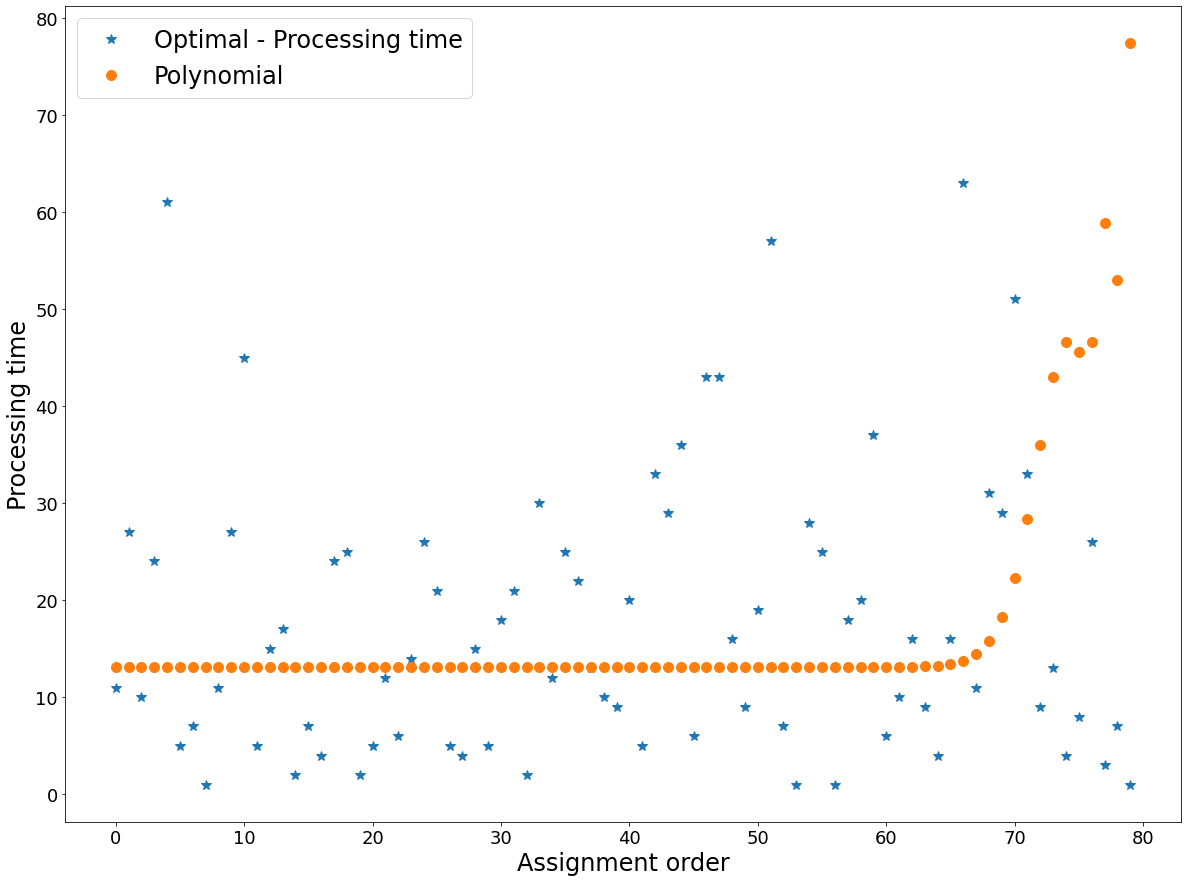

Min-Min makespan: 309
process: [1, 1, 1, 2, 1, 3, 3, 3, 3, 4, 4, 4, 3, 5, 4, 4, 11, 10, 5, 5, 6, 6, 6, 8, 10, 12, 6, 8, 8, 10, 8, 8, 14, 9, 11, 10, 11, 11, 16, 13, 15, 13, 11, 17, 16, 14, 12, 16, 16, 18, 15, 15, 16, 15, 16, 21, 21, 28, 24, 24, 21, 32, 31, 26, 28, 29, 35, 28, 30, 36, 42, 35, 31, 32, 31, 47, 71, 63, 37, 94]

HASA makespan: 309
process: [8, 9, 10, 1, 3, 2, 1, 12, 1, 13, 4, 4, 3, 4, 4, 3, 1, 5, 3, 3, 5, 4, 10, 11, 6, 5, 6, 8, 10, 6, 8, 14, 6, 8, 11, 8, 11, 11, 16, 10, 15, 13, 11, 17, 16, 14, 12, 16, 16, 18, 15, 15, 16, 15, 16, 21, 21, 28, 24, 24, 21, 32, 31, 26, 28, 29, 35, 28, 30, 36, 42, 35, 31, 32, 31, 47, 71, 63, 37, 94]

Optimal makespan: 275
process: [16, 24, 4, 35, 8, 8, 8, 8, 1, 14, 5, 4, 3, 3, 11, 10, 32, 10, 42, 11, 1, 47, 32, 5, 13, 24, 10, 4, 11, 16, 2, 15, 3, 6, 31, 10, 18, 38, 32, 6, 11, 16, 8, 4, 15, 13, 21, 15, 26, 17, 88, 21, 36, 5, 16, 28, 37, 14, 9, 11, 1, 6, 3, 21, 3, 28, 6, 12, 31, 4, 16, 21, 15, 64, 12, 1, 30, 15, 41, 36]

Poly makespan: 321
process: 

/tmp/ipykernel_395369/3150712127.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


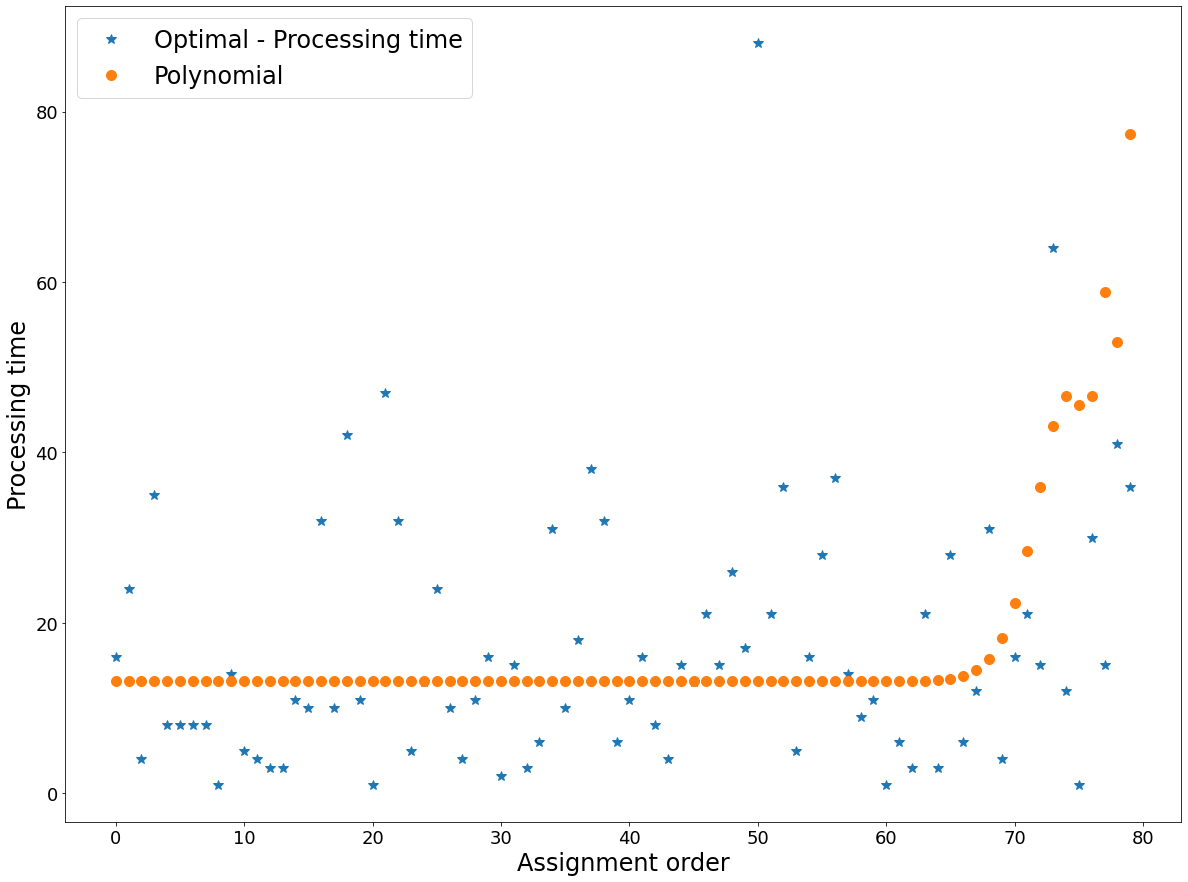

Min-Min makespan: 335
process: [1, 1, 3, 3, 3, 5, 6, 3, 3, 5, 3, 4, 6, 7, 4, 5, 8, 6, 4, 5, 9, 7, 6, 8, 5, 6, 8, 11, 10, 8, 18, 12, 8, 13, 14, 10, 14, 19, 16, 17, 16, 15, 19, 17, 21, 18, 19, 26, 19, 22, 29, 22, 22, 31, 26, 30, 26, 27, 34, 27, 31, 32, 28, 27, 36, 28, 36, 44, 28, 37, 31, 38, 32, 49, 41, 44, 58, 48, 61, 56]

HASA makespan: 330
process: [10, 10, 11, 1, 12, 3, 5, 3, 1, 5, 17, 3, 5, 4, 3, 3, 6, 6, 3, 4, 8, 4, 6, 7, 5, 8, 5, 7, 9, 6, 14, 8, 13, 8, 8, 18, 14, 17, 16, 16, 15, 19, 17, 21, 18, 19, 19, 26, 22, 29, 19, 22, 31, 22, 26, 30, 27, 26, 34, 27, 28, 32, 31, 27, 36, 28, 44, 28, 36, 31, 37, 32, 38, 49, 41, 58, 48, 44, 56, 61]

Optimal makespan: 313
process: [7, 8, 8, 31, 58, 3, 26, 1, 36, 14, 40, 5, 11, 30, 32, 6, 32, 26, 5, 28, 21, 11, 49, 6, 10, 18, 19, 1, 7, 48, 3, 56, 5, 3, 17, 9, 27, 32, 44, 8, 19, 22, 31, 61, 3, 6, 27, 8, 38, 16, 3, 16, 27, 10, 8, 4, 22, 17, 29, 5, 25, 18, 37, 5, 19, 37, 4, 3, 22, 19, 15, 14, 12, 15, 31, 28, 38, 6, 34, 4]

Poly makespan: 346
process: [

/tmp/ipykernel_395369/3150712127.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


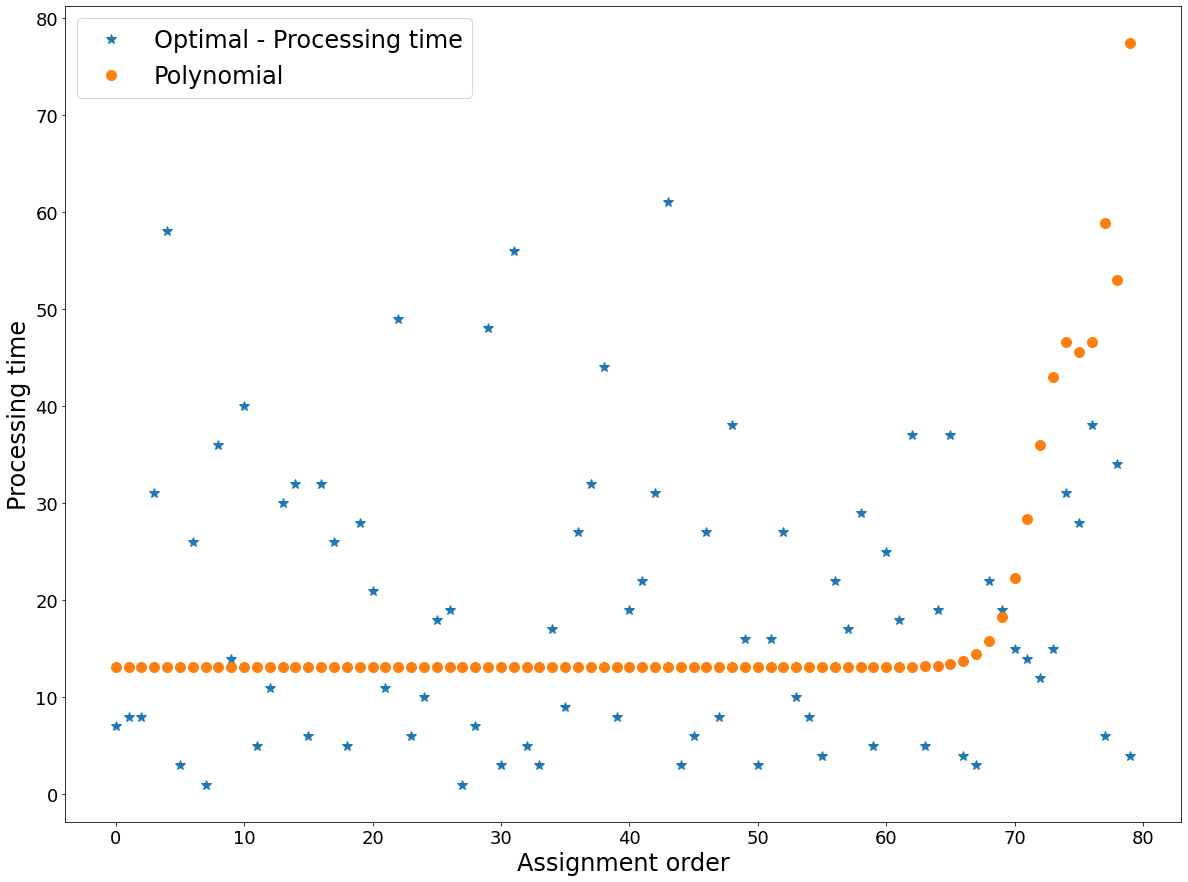

Min-Min makespan: 302
process: [1, 1, 2, 2, 1, 1, 1, 2, 2, 4, 4, 3, 4, 3, 4, 5, 7, 4, 4, 4, 5, 5, 7, 5, 11, 6, 6, 5, 7, 6, 6, 8, 8, 11, 7, 8, 8, 11, 10, 13, 12, 10, 14, 19, 15, 17, 10, 18, 12, 16, 20, 25, 12, 24, 19, 13, 22, 27, 20, 16, 27, 24, 18, 25, 34, 20, 33, 34, 27, 35, 28, 36, 34, 43, 31, 61, 49, 70, 60, 89]

HASA makespan: 315
process: [8, 8, 9, 2, 11, 2, 1, 12, 4, 3, 7, 4, 2, 4, 1, 1, 1, 2, 4, 1, 4, 3, 7, 4, 5, 5, 4, 5, 5, 6, 7, 11, 6, 5, 6, 6, 10, 7, 11, 8, 17, 10, 14, 15, 10, 20, 25, 18, 10, 15, 12, 22, 20, 16, 26, 13, 20, 16, 24, 24, 27, 18, 25, 27, 33, 20, 34, 27, 34, 28, 34, 35, 36, 31, 49, 43, 70, 61, 60, 83]

Optimal makespan: 259
process: [11, 10, 20, 18, 75, 6, 16, 61, 18, 15, 36, 8, 5, 2, 3, 7, 2, 17, 49, 43, 34, 24, 10, 7, 1, 12, 25, 34, 27, 5, 8, 36, 15, 25, 4, 5, 13, 28, 14, 1, 31, 55, 20, 20, 12, 16, 7, 8, 1, 5, 27, 17, 6, 27, 12, 10, 28, 4, 2, 33, 61, 2, 11, 4, 11, 5, 3, 4, 4, 8, 4, 6, 4, 19, 7, 10, 1, 22, 6, 1]

Poly makespan: 282
process: [13, 14, 13, 13, 1, 1

/tmp/ipykernel_395369/3150712127.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


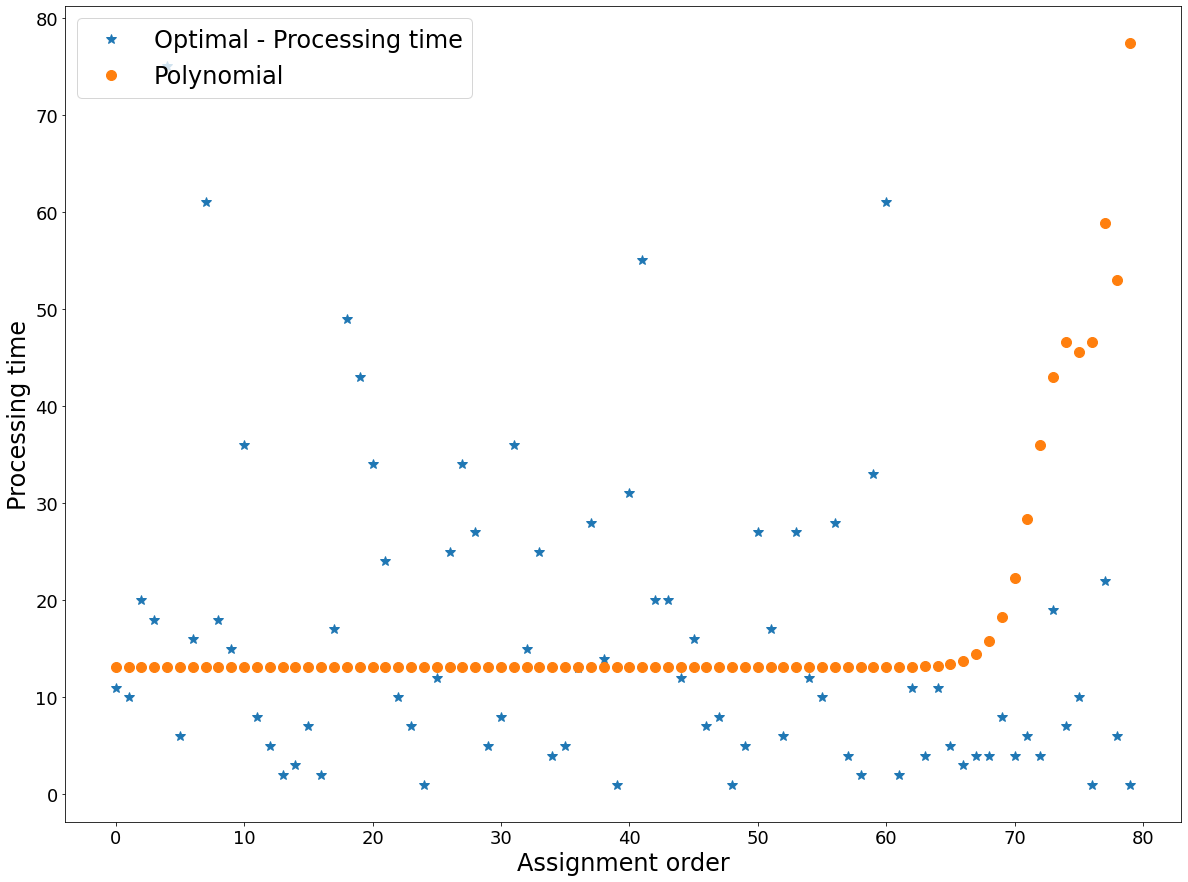

70
dataset: ./all_data/8x50/8x50-1.csv
dataset: ./all_data/8x50/8x50-2.csv
dataset: ./all_data/8x50/8x50-3.csv
dataset: ./all_data/8x50/8x50-4.csv
dataset: ./all_data/8x50/8x50-5.csv
Min-Min makespan: 115
process: [1, 1, 1, 2, 2, 1, 1, 4, 4, 4, 3, 4, 4, 6, 4, 3, 6, 5, 6, 8, 6, 8, 6, 9, 8, 7, 9, 12, 11, 10, 11, 12, 11, 11, 14, 11, 13, 17, 22, 16, 18, 25, 16, 31, 18, 25, 20, 26, 33, 59]

HASA makespan: 115
process: [6, 6, 6, 6, 7, 1, 2, 8, 1, 9, 1, 1, 4, 11, 1, 4, 2, 4, 3, 3, 4, 4, 11, 12, 5, 7, 8, 6, 10, 8, 12, 9, 11, 11, 11, 22, 14, 13, 17, 18, 31, 16, 18, 18, 25, 20, 25, 26, 49, 59]

Optimal makespan: 81
process: [59, 6, 4, 6, 12, 16, 26, 2, 11, 18, 4, 4, 33, 1, 2, 1, 20, 33, 8, 11, 25, 10, 22, 1, 6, 14, 11, 9, 4, 25, 15, 8, 9, 7, 21, 1, 13, 31, 6, 26, 1, 6, 4, 20, 8, 5, 6, 17, 3, 18]

Poly makespan: 115
process: [8, 8, 7, 1, 9, 1, 1, 6, 6, 6, 2, 6, 2, 4, 1, 1, 3, 4, 4, 4, 4, 3, 4, 11, 5, 6, 9, 12, 11, 10, 8, 12, 11, 11, 11, 14, 13, 17, 22, 18, 31, 18, 16, 18, 25, 20, 25, 26, 33, 59]


/tmp/ipykernel_395369/3150712127.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


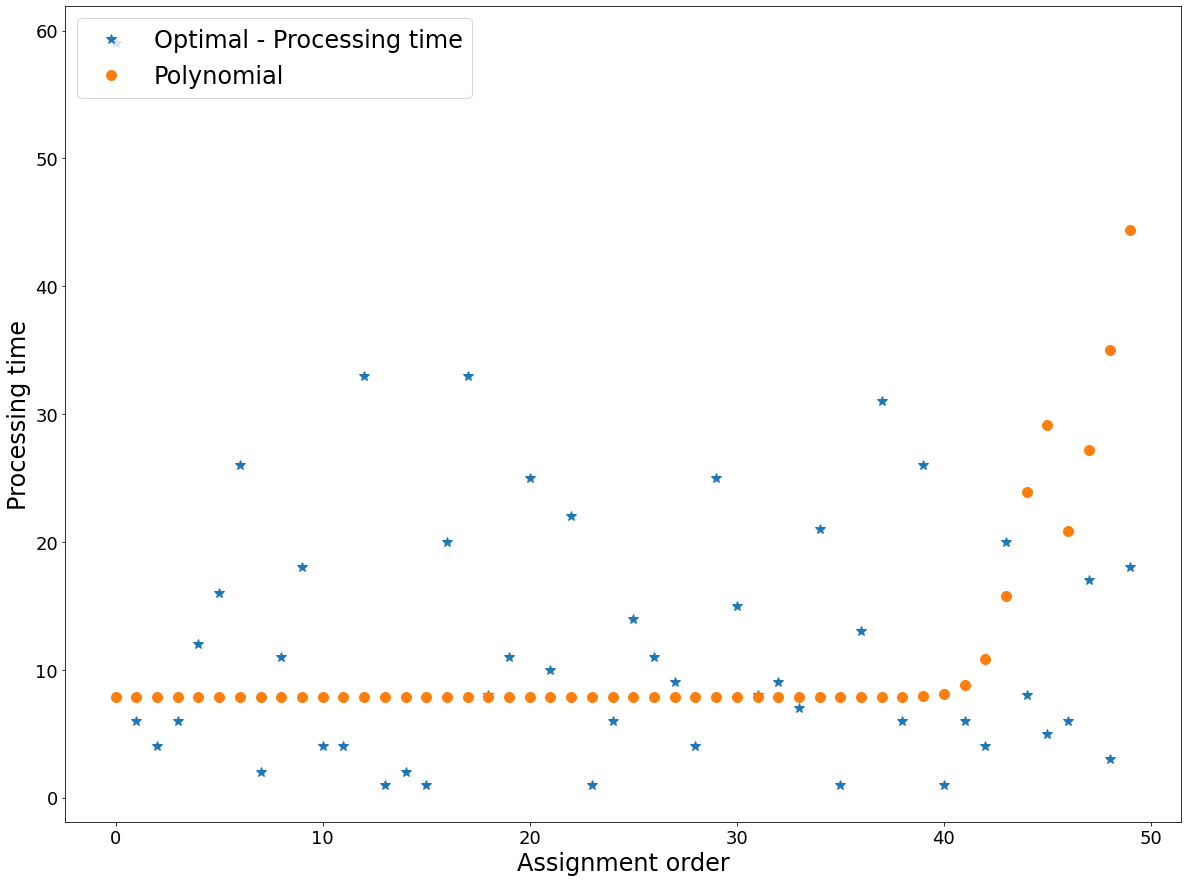

Min-Min makespan: 96
process: [1, 1, 1, 2, 1, 1, 3, 3, 4, 5, 3, 4, 3, 3, 4, 4, 4, 5, 5, 5, 8, 7, 7, 7, 5, 5, 10, 8, 9, 6, 8, 13, 12, 12, 11, 11, 11, 13, 17, 15, 12, 16, 17, 24, 18, 29, 20, 45, 37, 60]

HASA makespan: 96
process: [5, 5, 5, 1, 1, 7, 7, 7, 1, 1, 8, 1, 10, 3, 5, 3, 4, 4, 3, 2, 3, 4, 4, 5, 3, 5, 4, 8, 9, 6, 8, 13, 12, 12, 11, 11, 11, 13, 17, 15, 12, 16, 17, 24, 18, 29, 20, 45, 37, 60]

Optimal makespan: 67
process: [1, 37, 8, 2, 11, 17, 18, 7, 19, 11, 4, 5, 12, 13, 3, 7, 23, 4, 1, 6, 3, 5, 5, 13, 3, 4, 20, 25, 2, 17, 5, 4, 5, 1, 5, 29, 28, 16, 1, 14, 12, 19, 3, 4, 15, 8, 3, 5, 10, 24]

Poly makespan: 86
process: [8, 8, 7, 7, 1, 9, 1, 6, 1, 6, 2, 6, 2, 1, 3, 4, 3, 4, 5, 3, 4, 4, 7, 5, 5, 5, 13, 5, 11, 5, 8, 10, 9, 12, 12, 11, 15, 13, 11, 19, 17, 16, 12, 18, 29, 24, 20, 25, 60, 37]





/tmp/ipykernel_395369/3150712127.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


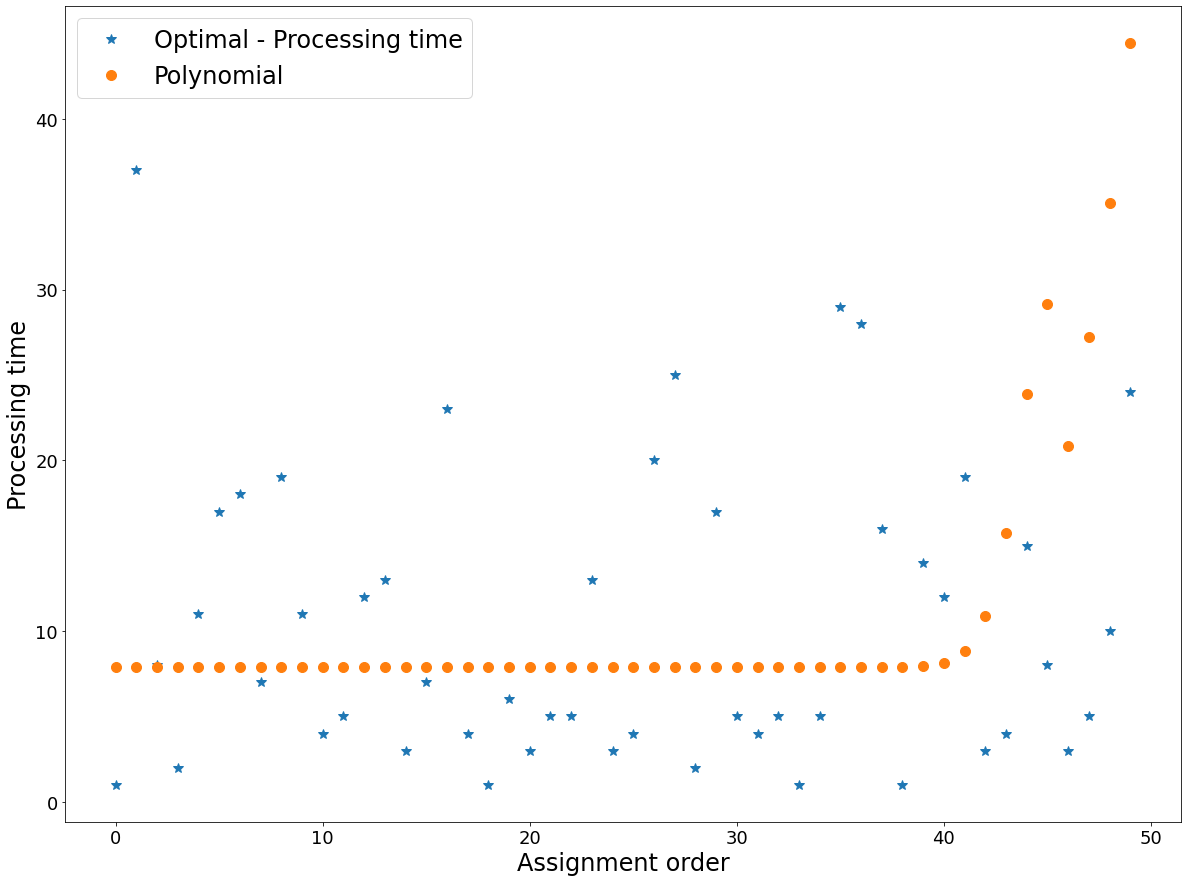

Min-Min makespan: 107
process: [1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 4, 2, 2, 5, 6, 3, 4, 5, 5, 7, 6, 6, 11, 8, 9, 7, 7, 13, 7, 9, 9, 13, 9, 13, 18, 27, 16, 19, 15, 27, 25, 28, 19, 29, 32, 27, 19, 51, 60]

HASA makespan: 110
process: [5, 6, 6, 7, 8, 1, 6, 2, 9, 1, 1, 4, 1, 10, 1, 6, 2, 2, 3, 2, 1, 4, 7, 11, 4, 2, 7, 5, 9, 7, 13, 11, 9, 13, 18, 16, 13, 25, 27, 15, 27, 28, 19, 19, 32, 27, 29, 19, 51, 26]

Optimal makespan: 75
process: [12, 18, 6, 5, 6, 4, 8, 13, 23, 9, 33, 19, 9, 5, 1, 19, 26, 4, 22, 2, 1, 25, 6, 27, 6, 1, 2, 28, 18, 19, 4, 16, 12, 2, 27, 9, 32, 29, 3, 7, 2, 1, 28, 1, 11, 9, 1, 1, 2, 13]

Poly makespan: 112
process: [8, 7, 7, 7, 1, 9, 1, 6, 6, 2, 1, 1, 10, 1, 2, 1, 2, 4, 2, 2, 3, 2, 5, 4, 7, 5, 11, 9, 6, 6, 11, 13, 9, 13, 16, 18, 13, 25, 27, 15, 27, 19, 28, 19, 32, 27, 29, 19, 51, 26]





/tmp/ipykernel_395369/3150712127.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


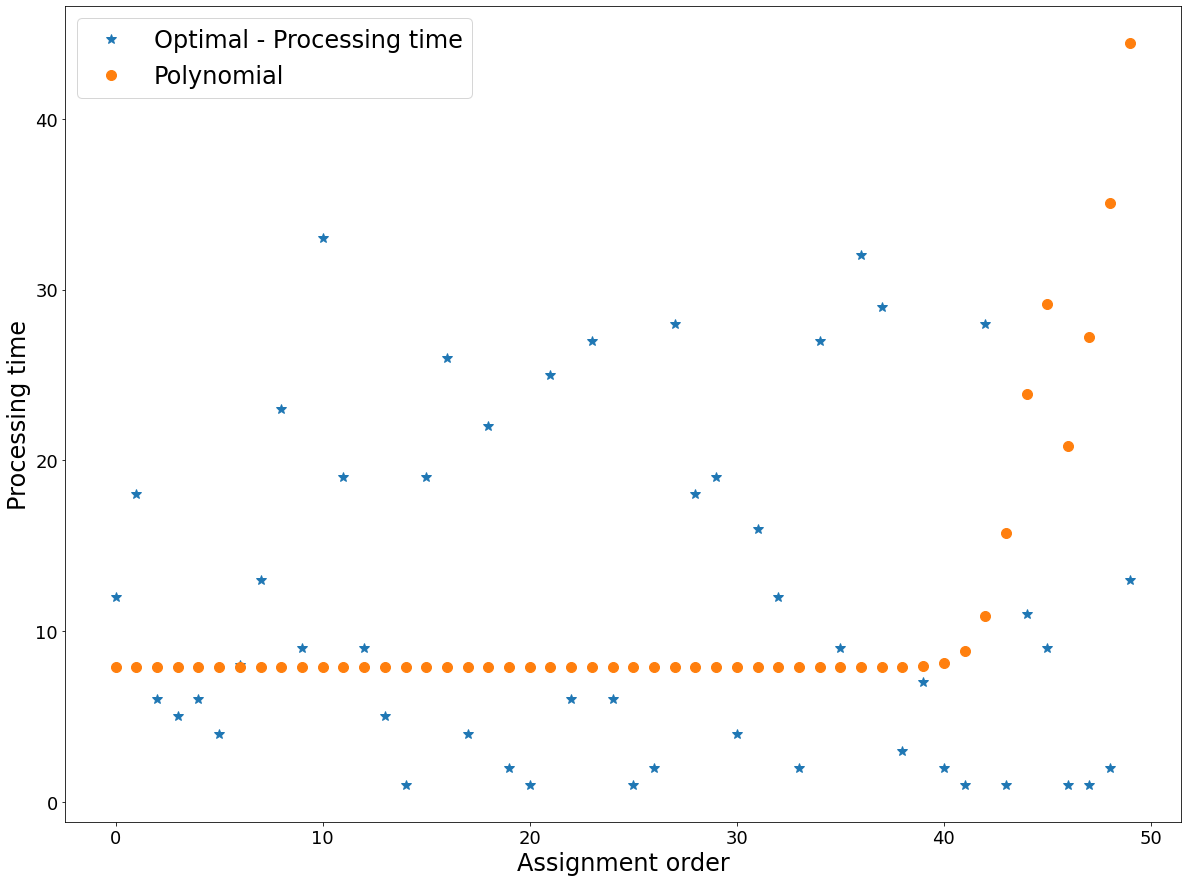

Min-Min makespan: 78
process: [1, 1, 1, 1, 2, 1, 2, 3, 3, 3, 5, 6, 3, 8, 5, 6, 4, 5, 9, 5, 5, 6, 5, 7, 10, 12, 9, 9, 8, 10, 9, 15, 13, 12, 10, 11, 18, 26, 23, 14, 14, 16, 20, 17, 30, 22, 30, 28, 19, 29]

HASA makespan: 78
process: [5, 6, 6, 6, 1, 7, 7, 3, 8, 9, 2, 1, 3, 5, 1, 1, 3, 6, 2, 1, 5, 4, 5, 10, 9, 12, 9, 8, 10, 9, 9, 15, 13, 10, 12, 11, 18, 26, 14, 16, 23, 14, 20, 17, 30, 30, 22, 19, 28, 29]

Optimal makespan: 72
process: [30, 13, 12, 3, 9, 9, 30, 15, 7, 8, 15, 1, 5, 12, 9, 2, 5, 7, 3, 23, 6, 10, 11, 14, 2, 6, 9, 6, 4, 6, 28, 16, 26, 7, 22, 10, 5, 20, 19, 26, 9, 1, 10, 29, 22, 1, 8, 17, 3, 1]

Poly makespan: 80
process: [8, 8, 7, 8, 8, 9, 1, 9, 6, 2, 1, 2, 1, 1, 3, 3, 5, 6, 3, 6, 9, 4, 5, 12, 5, 9, 5, 5, 10, 10, 10, 9, 13, 12, 11, 18, 15, 14, 14, 16, 26, 23, 17, 20, 30, 22, 19, 29, 30, 28]





/tmp/ipykernel_395369/3150712127.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


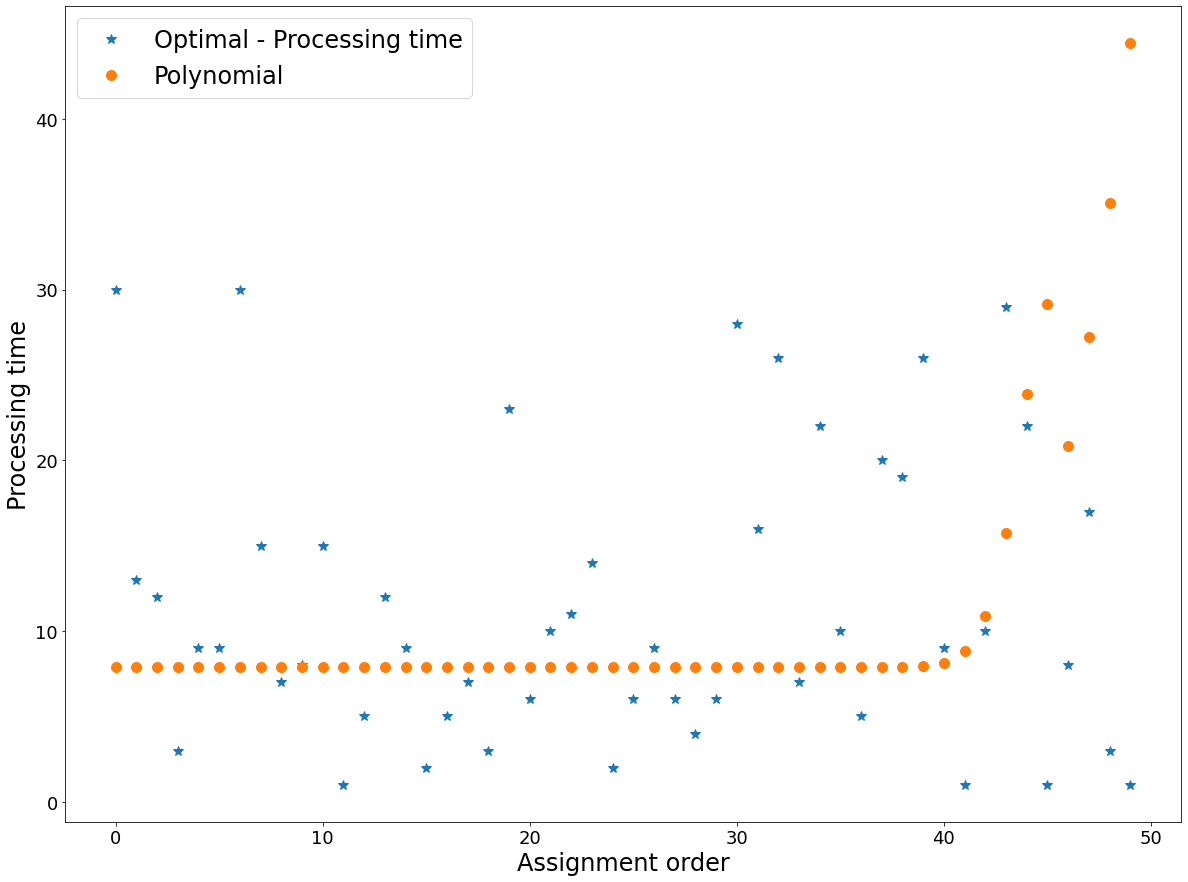

Min-Min makespan: 97
process: [1, 1, 1, 1, 1, 3, 3, 3, 2, 2, 5, 5, 5, 3, 3, 4, 5, 4, 5, 6, 6, 5, 6, 11, 4, 8, 7, 8, 6, 9, 13, 9, 13, 8, 17, 11, 11, 9, 14, 21, 18, 19, 17, 12, 18, 22, 19, 18, 23, 31]

HASA makespan: 97
process: [4, 5, 5, 1, 6, 1, 6, 1, 3, 1, 8, 1, 2, 2, 11, 3, 5, 6, 3, 4, 15, 4, 5, 8, 7, 4, 6, 9, 11, 11, 5, 9, 8, 11, 13, 13, 9, 17, 18, 14, 21, 18, 17, 12, 19, 17, 18, 22, 23, 31]

Optimal makespan: 62
process: [18, 2, 16, 31, 5, 27, 3, 12, 18, 1, 10, 4, 11, 8, 3, 9, 11, 5, 6, 3, 1, 3, 3, 17, 1, 3, 7, 19, 11, 17, 9, 14, 19, 6, 5, 4, 8, 6, 1, 13, 22, 4, 1, 21, 2, 18, 25, 5, 16, 5]

Poly makespan: 97
process: [8, 8, 8, 8, 7, 7, 9, 1, 1, 1, 3, 5, 5, 3, 3, 1, 2, 5, 2, 5, 4, 4, 3, 5, 6, 4, 5, 6, 11, 6, 13, 9, 6, 11, 11, 9, 13, 17, 14, 18, 21, 12, 17, 18, 17, 19, 22, 18, 23, 31]





/tmp/ipykernel_395369/3150712127.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


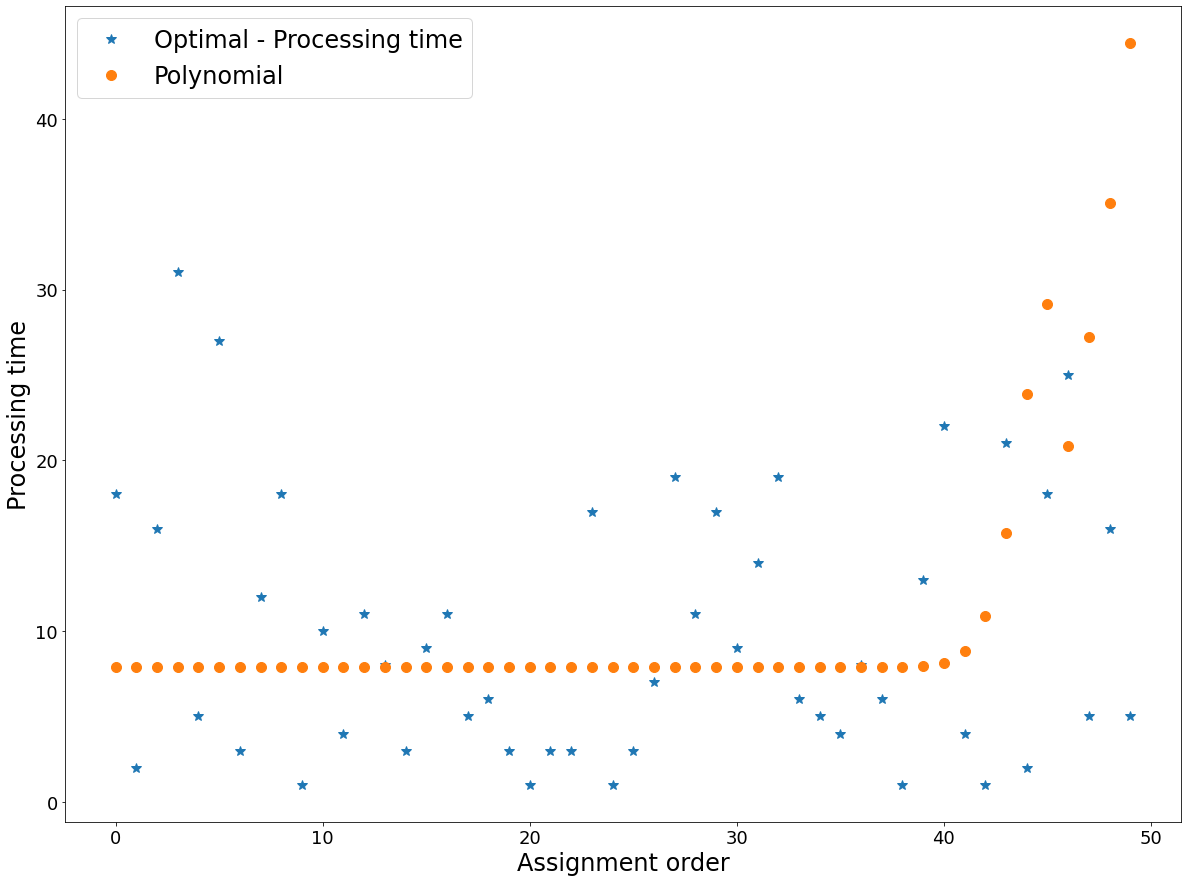

3
dataset: ./all_data/100x10/100x10-1.csv
dataset: ./all_data/100x10/100x10-2.csv
dataset: ./all_data/100x10/100x10-3.csv
dataset: ./all_data/100x10/100x10-4.csv
dataset: ./all_data/100x10/100x10-5.csv
Min-Min makespan: 128
process: [1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 4, 2, 4, 5, 4, 3, 3, 5, 3, 5, 5, 4, 4, 4, 5, 5, 4, 6, 8, 5, 6, 5, 6, 8, 4, 7, 6, 5, 8, 7, 13, 11, 10, 9, 8, 12, 9, 7, 9, 10, 12, 12, 12, 8, 9, 15, 13, 10, 10, 18, 13, 12, 12, 11, 14, 11, 17, 18, 21, 12, 14, 18, 16, 16, 18, 31, 26, 13, 19, 26, 19, 27, 20, 19, 19, 27, 31, 27, 43, 36, 30, 34, 37]

HASA makespan: 130
process: [5, 5, 6, 6, 6, 1, 2, 1, 1, 8, 8, 8, 2, 1, 1, 2, 2, 2, 1, 1, 5, 4, 1, 1, 12, 2, 13, 4, 2, 4, 1, 6, 5, 4, 4, 5, 2, 4, 7, 4, 3, 7, 5, 6, 4, 8, 5, 5, 10, 9, 8, 7, 5, 9, 10, 11, 9, 8, 12, 12, 9, 15, 13, 10, 10, 12, 18, 14, 12, 12, 11, 17, 11, 18, 13, 21, 16, 12, 18, 16, 14, 18, 31, 26, 13, 26, 19, 27, 23, 20, 19, 19, 31, 36, 35, 27, 30, 34, 37, 42]

Optimal makespan: 113
process: [4, 6, 8, 43

/tmp/ipykernel_395369/3150712127.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


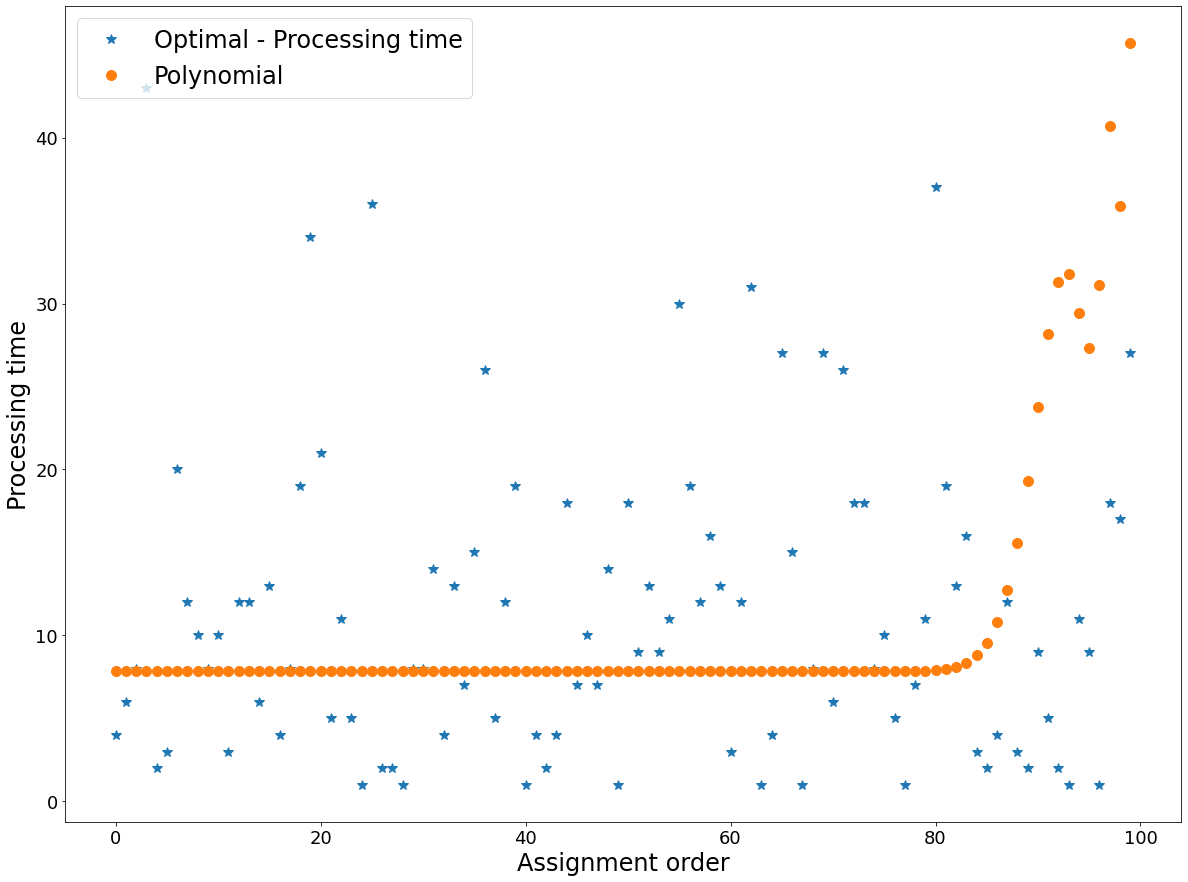

Min-Min makespan: 140
process: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 3, 3, 5, 3, 3, 3, 3, 5, 4, 3, 7, 4, 4, 4, 5, 3, 5, 8, 6, 8, 3, 4, 5, 8, 8, 6, 6, 8, 7, 7, 8, 8, 9, 7, 10, 10, 6, 8, 9, 11, 7, 10, 6, 11, 15, 11, 7, 16, 10, 12, 13, 13, 14, 13, 16, 11, 16, 13, 17, 19, 16, 19, 13, 21, 19, 14, 17, 17, 30, 22, 17, 23, 23, 20, 32, 21, 18, 20, 21, 52, 37, 38, 32, 35, 37, 34]

HASA makespan: 144
process: [6, 6, 6, 6, 1, 7, 7, 1, 8, 1, 8, 1, 3, 9, 1, 3, 1, 1, 3, 5, 11, 3, 1, 1, 3, 7, 5, 3, 3, 4, 3, 3, 5, 4, 3, 4, 4, 3, 5, 7, 6, 8, 8, 4, 8, 5, 8, 6, 7, 7, 8, 9, 10, 8, 6, 10, 11, 10, 15, 7, 10, 12, 13, 11, 14, 14, 16, 11, 16, 16, 13, 13, 19, 19, 13, 16, 17, 21, 14, 17, 22, 17, 19, 17, 17, 23, 32, 20, 35, 18, 23, 32, 21, 52, 35, 34, 32, 37, 37, 38]

Optimal makespan: 118
process: [18, 13, 17, 17, 12, 3, 1, 3, 8, 1, 10, 22, 1, 1, 20, 16, 7, 8, 3, 4, 6, 14, 8, 3, 1, 6, 23, 3, 16, 19, 9, 5, 23, 28, 13, 1, 10, 11, 8, 3, 8, 1, 3, 16, 19, 3, 7, 15, 32, 13, 13, 7, 9, 19, 7, 6, 37, 5, 7, 35, 16, 1,

/tmp/ipykernel_395369/3150712127.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


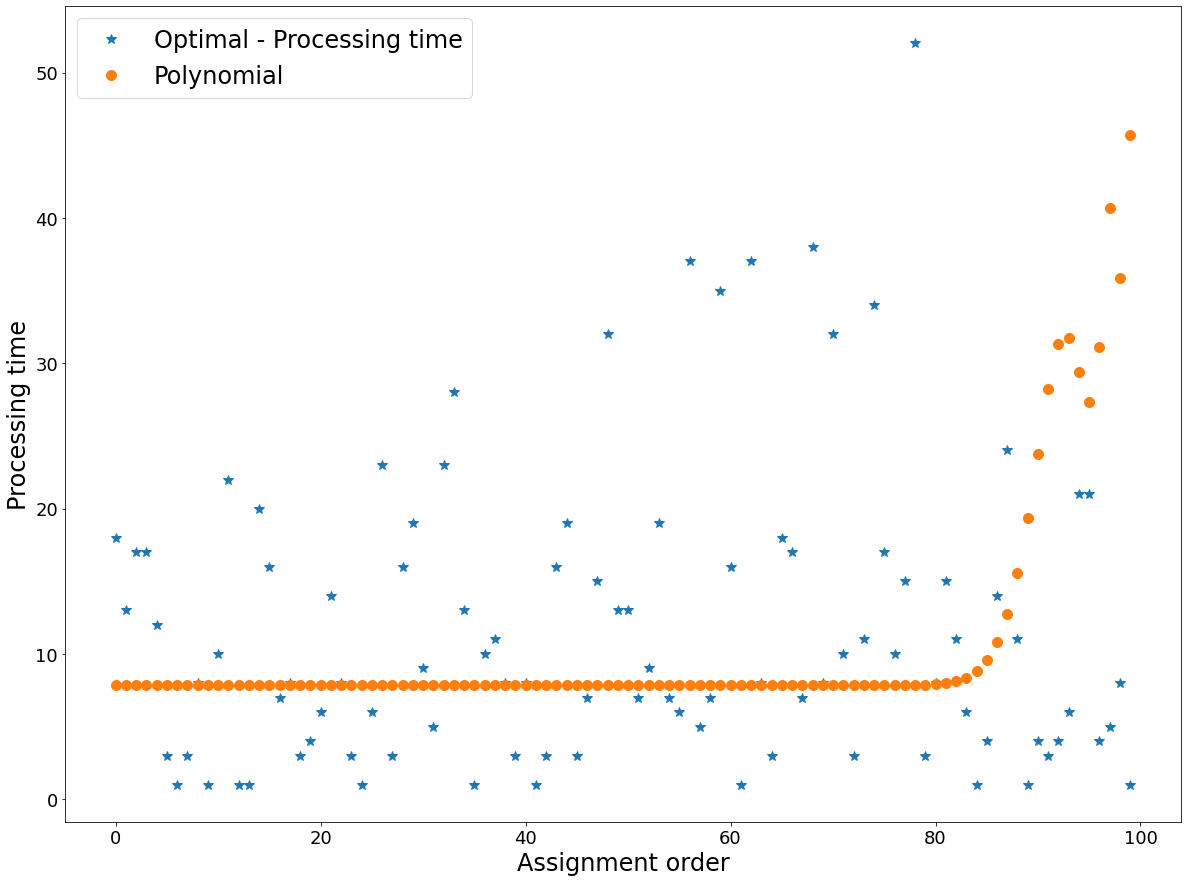

Min-Min makespan: 122
process: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 2, 3, 2, 2, 3, 2, 3, 3, 2, 2, 2, 2, 2, 3, 4, 4, 2, 3, 3, 4, 4, 3, 3, 4, 5, 5, 3, 4, 4, 8, 12, 5, 8, 4, 9, 8, 10, 6, 5, 4, 7, 9, 12, 9, 7, 9, 7, 11, 14, 7, 14, 8, 7, 10, 13, 14, 12, 18, 8, 14, 16, 13, 11, 19, 15, 13, 18, 15, 13, 20, 22, 19, 14, 23, 16, 22, 26, 22, 29, 21, 33, 37, 38, 34, 43, 37, 46]

HASA makespan: 128
process: [5, 5, 5, 6, 1, 5, 6, 7, 2, 1, 2, 1, 2, 2, 8, 1, 9, 4, 3, 3, 1, 2, 2, 2, 1, 3, 12, 1, 2, 2, 1, 2, 4, 3, 1, 4, 2, 3, 2, 4, 4, 8, 1, 4, 3, 3, 4, 5, 3, 8, 7, 4, 7, 9, 7, 12, 12, 9, 14, 9, 8, 7, 7, 10, 9, 12, 13, 8, 8, 14, 16, 11, 14, 18, 14, 13, 13, 20, 18, 13, 19, 15, 19, 15, 14, 22, 23, 16, 22, 21, 26, 22, 29, 33, 37, 43, 38, 34, 46, 41]

Optimal makespan: 105
process: [33, 4, 1, 3, 21, 1, 19, 5, 1, 3, 3, 2, 1, 15, 38, 3, 11, 2, 1, 2, 37, 2, 14, 9, 10, 7, 23, 20, 15, 9, 15, 16, 3, 7, 22, 4, 1, 13, 7, 12, 4, 11, 26, 3, 13, 4, 6, 4, 3, 1, 1, 9, 4, 4, 5, 10, 14, 7, 2, 30, 10, 8, 18, 5, 8, 9, 2, 3,

/tmp/ipykernel_395369/3150712127.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


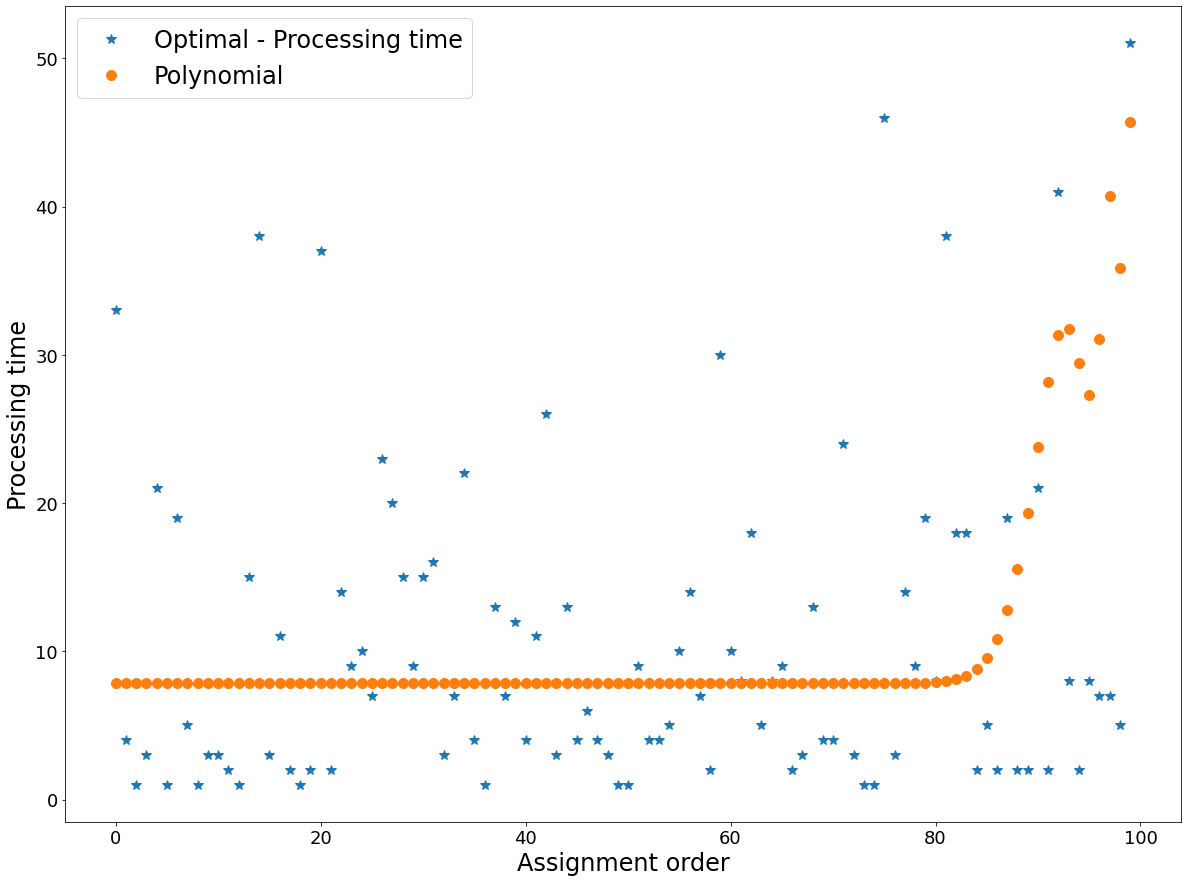

Min-Min makespan: 116
process: [1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 3, 3, 4, 3, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 4, 5, 5, 6, 6, 4, 6, 5, 8, 6, 6, 5, 6, 7, 5, 5, 7, 7, 6, 6, 7, 6, 5, 11, 8, 6, 9, 6, 8, 13, 13, 9, 8, 7, 7, 9, 8, 14, 11, 9, 9, 13, 9, 14, 12, 12, 12, 9, 14, 15, 16, 14, 21, 13, 12, 19, 16, 14, 20, 16, 24, 23, 17, 23, 29, 18, 15, 27, 18, 27, 32, 27, 35, 43]

HASA makespan: 124
process: [5, 5, 5, 6, 6, 6, 7, 1, 7, 7, 1, 1, 1, 3, 2, 3, 3, 1, 3, 1, 1, 2, 10, 1, 4, 1, 2, 3, 3, 3, 3, 3, 5, 4, 6, 5, 4, 6, 8, 6, 4, 7, 6, 5, 6, 6, 5, 13, 7, 7, 5, 11, 6, 7, 9, 9, 8, 8, 8, 7, 13, 13, 9, 8, 12, 11, 9, 14, 9, 9, 14, 14, 12, 12, 9, 14, 13, 15, 16, 21, 12, 16, 14, 19, 16, 20, 24, 23, 17, 23, 15, 18, 29, 27, 18, 20, 32, 40, 27, 47]

Optimal makespan: 101
process: [12, 6, 5, 4, 7, 43, 25, 23, 11, 14, 6, 21, 13, 9, 6, 4, 7, 8, 3, 29, 5, 13, 1, 1, 1, 15, 5, 10, 9, 6, 7, 1, 1, 1, 24, 4, 3, 21, 32, 4, 3, 5, 3, 2, 17, 2, 14, 8, 3, 18, 18, 27, 19, 8, 5, 11, 7, 6, 7, 14, 12, 20, 9, 28, 16, 6, 7, 4, 3

/tmp/ipykernel_395369/3150712127.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


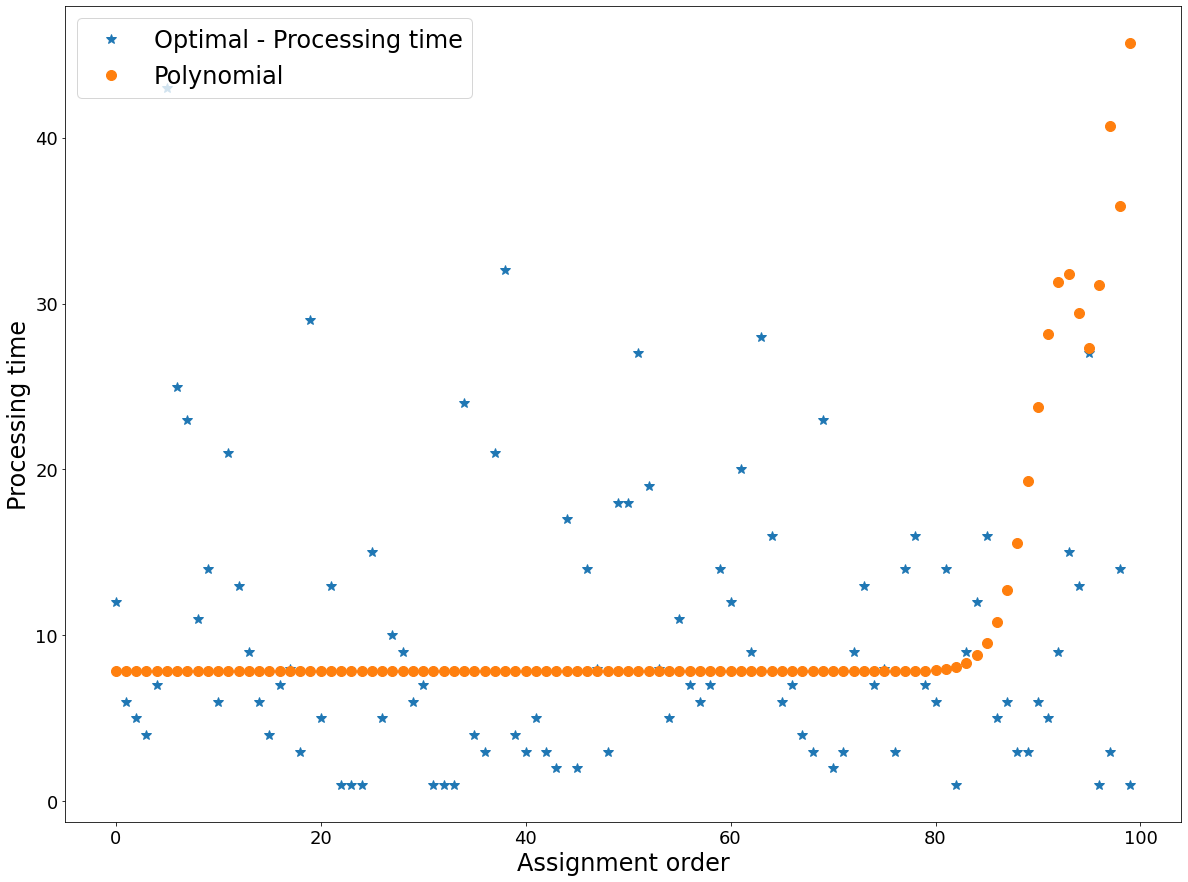

Min-Min makespan: 129
process: [1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 3, 2, 3, 3, 3, 2, 2, 2, 4, 2, 3, 3, 2, 2, 3, 4, 4, 3, 5, 5, 3, 4, 4, 4, 4, 4, 5, 4, 4, 6, 6, 7, 6, 7, 7, 4, 5, 6, 8, 7, 8, 5, 8, 6, 9, 8, 12, 11, 11, 8, 11, 11, 9, 13, 12, 16, 13, 9, 11, 15, 11, 15, 13, 13, 11, 14, 16, 20, 13, 17, 19, 14, 14, 13, 17, 20, 17, 20, 19, 14, 16, 15, 37, 18, 18, 29, 40, 28, 38, 53]

HASA makespan: 132
process: [5, 5, 5, 5, 1, 1, 6, 6, 2, 7, 7, 1, 2, 1, 2, 2, 3, 9, 4, 1, 3, 10, 1, 2, 2, 2, 3, 2, 3, 3, 3, 4, 4, 2, 6, 6, 4, 4, 6, 4, 4, 4, 4, 4, 4, 6, 7, 4, 8, 9, 7, 6, 8, 5, 8, 11, 8, 8, 11, 11, 12, 12, 13, 11, 9, 9, 16, 15, 11, 15, 13, 13, 11, 13, 11, 12, 20, 16, 17, 14, 17, 13, 14, 18, 17, 14, 19, 20, 20, 15, 16, 37, 19, 18, 29, 18, 28, 38, 46, 53]

Optimal makespan: 100
process: [24, 42, 2, 22, 14, 1, 5, 5, 8, 4, 13, 2, 11, 6, 8, 8, 18, 3, 3, 11, 19, 1, 15, 10, 1, 8, 3, 2, 3, 4, 4, 4, 7, 7, 4, 12, 20, 6, 4, 7, 14, 18, 17, 7, 17, 6, 3, 9, 5, 3, 3, 13, 40, 10, 18, 12, 2, 12, 15, 28, 11, 3, 16, 38, 9,

/tmp/ipykernel_395369/3150712127.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y4 = np.array(poly_plot)[:,1].reshape(-1,1)


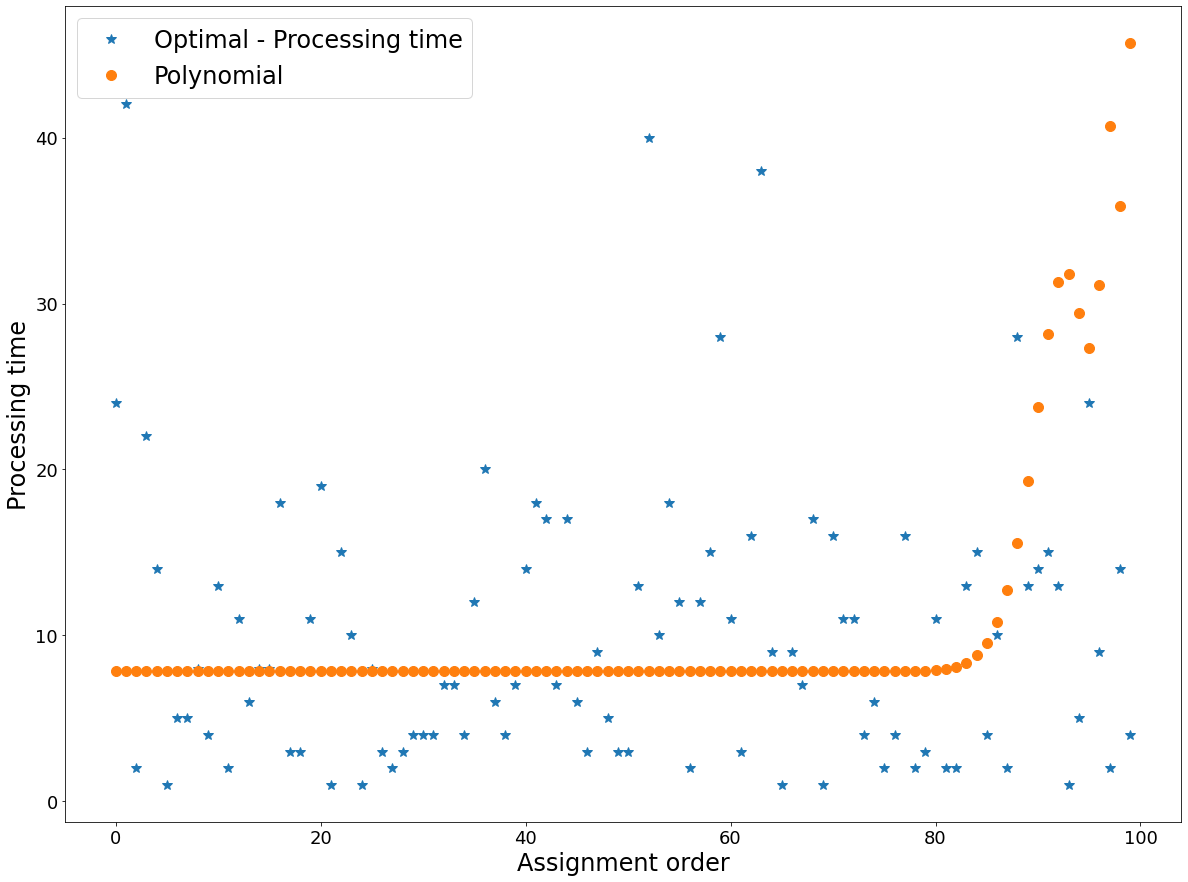

In [305]:
# import all datasets.

cases = ['2x50', '4x50', '5x20', '5x40', '5x80', '8x50', '100x10']

filenames_list = []
tests_list = []
results_list = []
test_results_list = []

for case in cases:
    path = './all_data/' + case
    filenames = glob.glob(path + "/*.csv")
    tests = []
    for filename in filenames:
        if filename[0] != 't':
            tests.append(filename)
    filenames.sort()
    tests.sort()
    
    filenames_list.append(filenames)
    tests_list.append(tests)

    path = './results/' + case
    results = glob.glob(path + "/*.csv")
    tests = []
    for result in results:
        if result[0] != 't':
            tests.append(result)
    results.sort()
    tests.sort()
    
    results_list.append(results)
    test_results_list.append(tests)


if __name__ == '__main__':
    polynomial_job_shop_main_mh(filenames_list, results_list)